# Вводная часть

Цель исследования – выявить ключевые тенденции, сегменты жертвователей и предложить рекомендации по улучшению маркетинговых стратегий фонда «Синдром любви». Для анализа предоставлены файлы выгрузки из Битрикс по полугодиям. Судя по всему, это выгрузки в одну общую таблицу данных из нескольких таблиц – CRM системы, таблицы транзакций и т.д. В файлах исходных данных более 200 колонок, поэтому требуется провести разведочный анализ для выявления колонок, по которым можно строить основной анализ. Приоритет данным по успешным транзакциям, а не данным из CRM системы.

**Ключевые вопросы исследования:**
- Общие и средние основные показатели и метрики.
- Динамика показателей. Есть ли факторы роста, паттерны в привязке с календарю?
- Портрет пользователей.
- Приток новых жертвователей. Сколько новых доноров приходит ежемесячно и откуда?
- RFM-анализ
- Когортный анализ
- Сегментация транзакций. Определить параметры, по которым можно провести сегментацию
- Категоризация пользователей. Определить параметры, по которым можно провести категоризацию.

**Ход исследования:**

- Загрузка данных
- Разведочный анализ исходных данных
- Формирование датасета для основного анализа
- Определение основных метрик и их динамики
- Определение наиболее успешных параметров донатов
- Первые пожертвования - откуда приходят пользователи
- Проведение RFM-анализа
- Проведение когортного анализа
- Сегментация транзакций по параметрам
- Кагоризация пользователей, динамика показателей в категориях
- Итоговый выводы и рекомендации


## Начальные установки

In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pytz
import datetime
import os
from io import StringIO
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps
import seaborn as sns

In [2]:
pd.options.display.precision=2
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
tz = pytz.timezone('Europe/Samara')
start = datetime.datetime.now(tz)

In [5]:
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/'):
  from google.colab import drive
  drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/love_sindrome/

/content/drive/My Drive/Colab Notebooks/love_sindrome


## Процедуры и функции

Здесь собраны все процедуры и функции, которые затем будут использоваться в исследовании

### chek_table

In [6]:
#Функция проверки датасета
# выводит на экран колво уникальных, процент nan
# возвращает список пустых колонок, которые можно удалить
# raw_table - таблица сырых данных
#-----------------
def chek_table(raw_table):
  emp_col = []
  len_d = len(raw_table)
  print(f'Количество уникальных - Доля nan - Название колонки')
  print(f'Всего строк: {len(raw_table)}, всего колонок {len(raw_table.columns)}')
  for col in range(len(raw_table.columns)):
      emp = ''
      nunq = raw_table.iloc[:, col].nunique()
      nan_c = raw_table.iloc[:, col].isna().sum()
      if nunq < 2:
          uniq = raw_table.iloc[:, col].unique()

          if uniq[0] == '' or uniq[0] != uniq[0]:
              emp = 'Полностью пустая!'
          emp_col.append(col)
      print(f'уник - {nunq} \t na - {nan_c / len_d:.1%} \t {raw_table.columns[col]}  {emp}')

  print(f'Всего строк: {len(raw_table)}, всего колонок {len(raw_table.columns)}')
  return #emp_col

### check_bool_col

In [7]:
#Функция проверки датасета
# выводит на экран колво уникальных в логических колонках
# с двумя значениями ДА/НЕТ
# raw_table - таблица сырых данных
#-----------------
def check_bool_col(raw_table):
  for col in raw_table.columns:
    if raw_table[col].nunique() ==2 :
        vals = list(raw_table[col].value_counts())
        per1 = vals[1] / (vals[1] + vals[0])
        if per1 > 0.05 :  print(f'{vals} \t {per1:.1%} \t {col}')

### par_rank_table

In [8]:
#функция построения таблицы рангов значений в заданной колонке
# tr_table - таблица транзакций
# col - параметр по которому стротся график
#-----------
def par_rank_table(tr_table, col='code'):
  dd = tr_table.groupby(col).agg({'id' : 'count', 'user_id' : 'nunique', 'donate' : 'sum'})
  dd.columns = ('tr_count', 'users_count', 'donate_sum')
  dd['don_on_tr'] = dd['donate_sum'] / dd['tr_count']
  dd['don_on_user'] = dd['donate_sum'] / dd['users_count']
  dd['tc_rank'] = dd['tr_count'].rank(method = 'first', ascending=False)
  dd['uc_rank'] = dd['users_count'].rank(method = 'first', ascending=False)
  dd['ds_rank'] = dd['donate_sum'].rank(method = 'first', ascending=False)
  dd['rank_sum'] = dd['tc_rank'] + dd['uc_rank'] + dd['ds_rank']
  return dd

### get_user_table

In [9]:
#функция построения таблицы пользоваателей по таблице транзакций
# tr_table - таблица транзакций
def get_user_table(tr_table):
  user_table = tr_table.groupby('user_id', as_index=False).agg({'date' : ['min', 'max'], 'donate' : 'sum', 'id' : 'count'})
  user_table.columns = ('user_id', 'first_date', 'last_date', 'donate_sum', 'tr_count')
  user_table['first_month'] = user_table['first_date'].dt.month
  user_table['first_year'] = user_table['first_date'].dt.year
  user_table['first_ym'] = (user_table['first_year'] - user_table['first_year'].min()) * 12 + user_table['first_month']

  user_table['day_on'] = user_table['last_date'] - user_table['first_date']
  user_table['day_on'] = user_table['day_on'].dt.days
  user_table['month_on'] = 1 + user_table['day_on'] // 30
  user_table['oper_frec'] = user_table['tr_count'] / user_table['month_on']

  day_on_zero = user_table.query('day_on == 0')['user_id'].unique()
  #regul_users = tranz.query('comment.str.contains("Ежемесячное пожертвование")')['user_id'].unique()
  regul_users = tranz.query('code.str.contains("Регулярные")')['user_id'].unique()
  user_table['type'] = user_table['user_id'].apply(lambda x: 'Подписчик' if x in regul_users else ('Разовый' if x in day_on_zero else 'Простой'))


  maxdate = tranz.query('date.notna()')['date'].max()
  user_table['day_last'] = user_table['last_date'].apply(lambda x: pd.to_datetime(maxdate) - x)
  user_table['day_last'] = user_table['day_last'].dt.days
  return user_table

### graf_dynamik_by_par

In [10]:
#Функция построения графика динамики ТОП значений в заданной колонке
# tr_table - таблица транзакций
# col - параметр по которому строится график
# t - количество линий для вывода
# type - типа графика: pik - пики по дням, cumsum - накоплением
#----------------
def graf_dynamik_by_par(tr_table, col='site', t=5, type='pik'):
  par = col
  if col == 'site': par = 'Сайт источинк'
  if col == 'code': par = 'Код'
  if col == 'comment': par = 'Комментарий'
  if col == 'action': par = 'Метка ссылки'
  fig = plt.figure(figsize=(12, 8))
  top = tr_table[col].value_counts().head(t).index
  qst = col + '.isin(@top)'
  dd = tr_table.query(qst).groupby(['date', col], as_index=False)['id'].count()
  dd = dd.pivot_table(index='date', columns=col, values='id').fillna(0)

  date_range = pd.date_range(start=dd.index.min(), end=dd.index.max(), freq='D')
  dd = dd.reindex(date_range, fill_value=0)

  if type == 'cumsum' : dd = dd.cumsum()

  plt.plot(dd, label=dd.columns)
  plt.legend()
  plt.title(f'Динамика транзакции по параметру {par}')
  plt.xlabel('Дата')
  plt.ylabel('Количество транзакций')
  plt.show()
  return

### graf_dynamik_by_par_subplot

In [11]:
#Функция построения сразу двух графиков динамики ТОП значений
# в заданной колонке - пики по дням и накоплением
# tr_table - таблица транзакций
# col - параметр по которому строится график
# t - количество линий для вывода
#----------------
def graf_dynamik_by_par_subplot(tr_table, col='site', t=5):
  par = col
  if col == 'site': par = 'Сайт источинк'
  if col == 'code': par = 'Код'
  if col == 'comment': par = 'Комментарий'
  if col == 'action': par = 'Метка ссылки'
  top = tr_table[col].value_counts().head(t).index
  qst = col + '.isin(@top)'
  dd = tr_table.query(qst).groupby(['date', col], as_index=False)['id'].count()
  dd = dd.pivot_table(index='date', columns=col, values='id').fillna(0)

  date_range = pd.date_range(start=dd.index.min(), end=dd.index.max(), freq='D')
  dd = dd.reindex(date_range, fill_value=0)

  fig, ax = plt.subplots(1, 2, figsize=(16, 6))
  ax[0].plot(dd, label=dd.columns)
  ax[0].set_xlabel('Дата')
  ax[0].set_ylabel('Количество транзакций')
  #ax[0].set_xticks([dd.index[::2]])
  ax[0].set_xticks(np.array(dd.index[::180]))

  dd = dd.cumsum()
  ax[1].plot(dd, label=dd.columns)
  ax[1].set_xlabel('Дата')
  ax[1].set_ylabel('Количество транзакций')
  ax[1].set_xticks(np.array(dd.index[::180]))

  plt.legend(loc='best', bbox_to_anchor=(0.1, -0.1))
  plt.suptitle(f'Динамика транзакции по параметру {par}')

  plt.show()
  return

### graf_dynamik_first_donate_by_col

In [12]:
#Функция построения графика динамики первых пожертвований
# от ТОП значений заданной колонки
# tr_table - таблица транзакций
# col - параметр по которому строися график
# t - количество линий для вывода
#----------------
def graf_dynamik_first_donate_by_col(tr_table, col = 'code',  t = 5, type='pik'):
  if col == 'site': par = 'Сайт источинк'
  if col == 'code': par = 'Код'
  if col == 'comment': par = 'Комментарий'
  if col == 'action': par = 'Метка ссылки'

  fig = plt.figure(figsize=(12, 8))
  top = tr_table[col].value_counts().head(t).index
  qst = col + '.isin(@top)'
  dd = tr_table.query(qst).groupby(['first_date', col], as_index=False)['user_id'].count()
  dd = dd.pivot_table(index='first_date', columns=col, values='user_id').fillna(0)

  date_range = pd.date_range(start=dd.index.min(), end=dd.index.max(), freq='D')
  dd = dd.reindex(date_range, fill_value=0)

  if type == 'cumsum' : dd = dd.cumsum()

  plt.plot(dd, label=dd.columns)
  plt.legend()
  plt.title(f'Динамика первых пожертвований по параметру {par}')
  plt.xlabel('Дата')
  plt.ylabel('Количество первых пожертвований')
  plt.show()
  return

### get_rfm_table

In [13]:
#Функция построения RFM таблицы
# tr_table - таблица транзакций
# rfm_rank - список границ рангов [r1, r2, f1, f2, m1, m2]
# r1 < r2, f1 > f2, m1 > m2
#------------------
def get_rfm_table(tr_table, rfm_ranks):
  users_rfm = get_user_table(tr_table)
  users_rfm['R'] = users_rfm['day_last'].apply(lambda x: '1' if x < rfm_ranks[0] else ('2' if x < rfm_ranks[1] else '3'))
  users_rfm['F'] = users_rfm['oper_frec'].apply(lambda x: '1' if x > rfm_ranks[2] else ('2' if x > rfm_ranks[3] else '3'))
  users_rfm['M'] = users_rfm['donate_sum'].apply(lambda x: '1' if x > rfm_ranks[4] else ('2' if x > rfm_ranks[5] else '3'))
  users_rfm['RFM'] = users_rfm['R'] + users_rfm['F'] + users_rfm['M']

  rfm_table = users_rfm.groupby(['R', 'F', 'M'], as_index = False).agg({'RFM' : 'first', 'tr_count' : ['count', 'sum'], 'donate_sum' : 'sum'})
  rfm_table.columns = ['R', 'F', 'M', 'RFM', 'rfm_users', 'rfm_tr', 'rfm_sum']

  #фокус к рангами рангов... чтото так себе =(
  #rfm_table['t_rank'] = rfm_table['rfm_tr'].rank(method = 'first', ascending=False)
  #rfm_table['u_rank'] = rfm_table['rfm_users'].rank(method = 'first', ascending=False)
  #rfm_table['d_rank'] = rfm_table['rfm_sum'].rank(method = 'first', ascending=False)
  #rfm_table['rank_sum'] = rfm_table['t_rank'] + rfm_table['u_rank'] + rfm_table['d_rank']


  return rfm_table

### show_rfm_table_sns

In [14]:
#Функция показа матрицы RFM в виде heatmap от sns
# rfm_table - rfm таблица
# col - показатель по которому строится таблица
#------------------
def show_rfm_table_sns(rfmtable, col = 'rfm_sum'):
    rfm_table = rfmtable.copy()
    rfm_table['R'] = rfm_table['R'].replace({'1':'1/Недавние', '2' : '2/Спящие', '3': '3/Уходящие'})
    rfm_table['F'] = rfm_table['F'].replace({'1':'1/Частые', '2' : '2/Редкие', '3': '3/Разовые'})
    rfm_table['M'] = rfm_table['M'].replace({'1':'1/Большой чек', '2' : '2/Средний чек', '3': '3/Малый чек'})
    rfm_table['RF'] = rfm_table['R'] + rfm_table['F']

    fig = plt.figure(figsize = (12, 6))
    rfm_pivot = rfm_table.pivot(index = ['R', 'F'], columns = 'M', values = col).fillna(0)
    rfm_pivot.rename(index={'1':'Недавние(1)', '2' : 'Спящие(2)', '3': 'Уходящие(3)'}, level=0, inplace=True)
    rfm_pivot.rename(index={'1':'Частые(1)', '2' : 'Редкие(2)', '3': 'Разовые(3)'}, level=1, inplace=True)
    rfm_pivot.rename(columns={'1':'Большой чек(1)', '2' : 'Средний чек(2)', '3': 'Малый чек(3)'}, inplace=True)
    par = ''
    if col == 'rfm_sum': par = 'Сумма транзакций'
    if col == 'rfm_users': par = 'Количество пользователей'
    if col == 'rfm_tr': par = 'Количество транзакций'

    sns.heatmap(rfm_pivot, cmap='RdYlGn', annot=True, cbar=False, fmt=',.0f')
    plt.title(f'Тепловая карта RFM анализа по параметру "{par}"')
    plt.show()
    return

### get_chogort_table

In [15]:
#Функция построения таблицы когорт
# tr_table - таблица транзакций
#------------------
def get_chogort_table(tr_table):
  user_table = get_user_table(tr_table)
  chogort_table = pd.DataFrame([])
  for m in sorted(user_table ['first_ym'].unique()):
    ch_u = user_table .query('first_ym == @m')['user_id'].unique()
    dd = tr_table.query('user_id.isin(@ch_u) and donate < @rfm_donate_lim').groupby('tr_ym', as_index=False)\
        .agg({'user_id': 'nunique', 'id' : 'count', 'donate' : 'sum', 'tr_y':'first', 'tr_m': 'first'})
    dd['ch_m'] = f"{dd['tr_y'][0]}_{dd['tr_m'][0]:0>2}"
    dd['m_live'] = dd['tr_ym'] - m + 1
    dd['ltv'] = dd['donate'].cumsum()
    dd['ltv_m'] = round(dd['ltv'] / dd['m_live'])
    dd['rr'] = round(100 * dd['user_id'] / len(ch_u), 2)
    dd['cr'] =round(dd['user_id'] / dd['user_id'].shift(1), 2)
    dd['cr'] = dd['cr'].fillna(1)

    chogort_table = pd.concat([chogort_table, dd])

  chogort_table.columns = ('tr_mon', 'user_count', 'tr_count', 'donate_sum',
                          'tr_y',  'tr_m',  'ch', 'm_live',
                          'ltv', 'ltv_m', 'rr', 'cr')
  return chogort_table

### show_chogort_table_sns

In [16]:
#Функция показа таблицы динамики по когортам в виде heatmap sns
# chogort_table - таблица когорт
# col - показатель по которому строится таблица
# pr - количество разрядов при округлении
# ml - горизонт когортного анализа
#------------------
def show_chogort_table_sns(chogort_table, col='user_count', pr=0, ml=12):

    dd = chogort_table.pivot(index = 'ch', columns = 'm_live', values = col)
    dd = dd.iloc[ -ml:, 0:ml]
    par = ''
    if col == 'donate_sum': par = 'Сумма транзакций'
    if col == 'user_count': par = 'Количество пользователей'
    if col == 'tr_count': par = 'Количество транзакций'
    if col == 'ltv': par = 'LTV'
    if col == 'ltv_m': par = 'LTV в месяц'
    if col == 'rr': par = 'Коэф. удержания (%)'
    if col == 'cr': par = 'Коэф. оттока'

    fig = plt.figure(figsize = (16, 10))
    hm = sns.heatmap(dd, cmap='RdYlGn', annot = True, cbar=False, fmt=f',.{pr}f')
    plt.title(f'Тепловая карта когортного анализа по параметру "{par}"')
    plt.yticks(rotation = 0)
    plt.ylabel('Когорта')
    plt.xlabel('Мeсяцы жизни когорты')
    plt.show()

    return

### graf_chogort

In [17]:
#Функция показа таблицы в виде heatmap и графика динамики когорт
# chogort_table - таблица когорт
# col - показатель по которому строится таблица
# pr - количество разрядов при округлении
# ml - горизонт когортного анализа
#------------------
def graf_chogort(chogort_table, col='user_count', pr=0, ml=12):
    par = ''
    if col == 'donate_sum': par = 'Сумма транзакций'
    if col == 'user_count': par = 'Количество пользователей'
    if col == 'tr_count': par = 'Количество транзакций'
    if col == 'ltv': par = 'LTV'
    if col == 'ltv_m': par = 'LTV в месяц'
    if col == 'rr': par = 'Коэф. удержания'
    if col == 'cr': par = 'Коэф. оттока'

    fig = plt.figure(figsize = (20, 10))

    dd = chogort_table.pivot(index='m_live', columns='ch', values=col)
    dd = dd.iloc[0:ml, -ml:]
    plt.plot(dd, label = dd.columns)

    plt.title(f'График динамики параметра "{par}" по когортнам')
    plt.ylabel('')
    plt.xlabel('Мeсяцы жизни когорты')
    plt.legend()
    plt.show()
    return

### graf_chogort_subplot

In [18]:
#Функция показа таблицы в виде heatmap и графика динамики когорт
# chogort_table - таблица когорт
# col - показатель по которому строится таблица
# pr - количество разрядов при округлении
# ml - горизонт когортного анализа
#------------------
def graf_chogort_subplot(chogort_table, col='user_count', pr=0, ml=12):
    par = ''
    if col == 'donate_sum': par = 'Сумма транзакций'
    if col == 'user_count': par = 'Количество пользователей'
    if col == 'tr_count': par = 'Количество транзакций'
    if col == 'ltv': par = 'LTV'
    if col == 'ltv_m': par = 'LTV в месяц'
    if col == 'rr': par = 'Коэф. удержания (%)'
    if col == 'cr': par = 'Коэф. оттока'

    f, ax = plt.subplots(1, 2, figsize=(16,5))

    dd = chogort_table.pivot(index='ch', columns='m_live', values=col)
    dd = dd.iloc[ -ml:, 0:ml]
    sns.heatmap(dd, xticklabels=dd.columns, cmap='RdYlGn', annot = True, fmt=f'.{pr}f', cbar=False, ax = ax[0])
    ax[1].plot(dd.T, label = dd.index)

    ax[0].set_xlabel('Когорта')
    ax[0].set_ylabel('Месяц жизни')
    ax[0].tick_params(axis='y', labelrotation = 00)
    ax[1].set_xlabel('Месяц жизни')
    ax[1].set_ylabel(f'{par}')
    ax[1].legend(title='Когорты')
    plt.suptitle(f'Динамика параметра "{par}" в когортах по месяцам жизни')
    plt.show()
    return

### graf_dynamik_seg

In [19]:
#Функция показа графика динамики по параметру в сегментах
# tr_table - таблица транзакций
#------------------
def graf_dynamik_seg(tr_table):
  seg_dynamik = tr_table.groupby('tr_month').agg({'date' : 'min', 'id' : 'count', 'donate' : ['sum', 'mean'], 'user_id' : 'nunique'})

  seg_dynamik.columns = ['date', 'tr_count', 'donate_sum', 'donate_mean', 'user_count']
  seg_dynamik['d_cumsum'] = seg_dynamik['donate_sum'].cumsum()
  seg_dynamik['date'] = pd.to_datetime(seg_dynamik['date'], format = '%Y-%m-%d', errors = 'coerce')

  seg_dynamik['u_newcount'] = tr_table[['tr_month','user_id']].drop_duplicates(['user_id']).groupby('tr_month').count()
  seg_dynamik['u_newcount'] = seg_dynamik['u_newcount'].fillna(0)
  seg_dynamik['u_cumcount'] = tr_table[['tr_month','user_id']].drop_duplicates(['user_id']).groupby('tr_month').count().cumsum()
  seg_dynamik['u_cumcount'] = seg_dynamik['u_cumcount'].ffill()

  f, ax = plt.subplots(1, 2, figsize=(20,6))
  ax[0].plot(month_dynamik['date'], month_dynamik['user_count'], color='tab:green', label='Все пользователи')
  ax[0].plot(seg_dynamik['date'], seg_dynamik['user_count'], color='tab:pink', label=f'Все в категории')
  ax[0].plot(seg_dynamik['date'], seg_dynamik['u_newcount'], color='tab:blue', label=f'Новые в категории')
  ax[0].set_ylabel('Количество донаторов')
  ax[0].set_title(f'Пользователи по месяцам')
  ax[0].legend()

  ax[1].plot(month_dynamik['date'], month_dynamik['u_cumcount'], color='tab:orange', linewidth = 3, label='Все пользователи нарастанием')
  ax[1].plot(seg_dynamik['date'], seg_dynamik['u_cumcount'], color='tab:red', linewidth = 3, label=f'Все в категории нарастанием')
  ax[1].set_title(f'Рост количества пользователей')
  ax[1].set_ylabel('Количество донаторов')
  ax[1].legend()

  plt.suptitle(f'Динамика количества донаторов по месяцам')
  plt.show()
  return

# Разведочный анализ

Из-за большого количества колонок в файлах исходных данных проведем предварительную разведку исходных данных, чтобы отобрать какие именно колонки пойдут в дальнейший анализ.

Загрузка по одному файлу

In [20]:
#path = 'd:/newwork/-=love_sindrom=-/'
path = 'data/'

#загрузка данных из исходников
#datafile = '01.07.2024-31.12.2024.xls'
#rawdata = pd.read_html(path + datafile, skiprows=0, header=0)[0]  # а это ЕЩЕ быстрее =)


#загрузка данных из сохраненных ранее csv
#datafile = '01.01.2024-30.06.2024.csv'
#datafile = '01.07.2024-31.12.2024.csv'
#rawdata = pd.read_csv(path + datafile)

#сохранение в csv, чтобы каждый раз не парсить исходные файлы
#rawdata.to_csv(path + os.path.splitext(datafile)[0] + '.csv', sep=',', index=False, encoding='utf-8')

Загрукза всех файлов из папки

In [21]:
all = 0
rawdata = pd.DataFrame([])
for ff in os.listdir(path):
  filename, fileexp = os.path.splitext(ff)
#  if fileexp == '.xls':
#    dd = pd.read_html(path + ff, skiprows=0, header=0)[0]
  if fileexp == '.csv':
    dd = pd.read_csv(path + ff)
    dd['file'] = ff
    l = len(dd)
    all = all + l
    rawdata = pd.concat([rawdata, dd])
    print(f'Загрузка {l} строк данных из файла {ff}')

print(f'Всего загружено {all} строк')

Загрузка 8928 строк данных из файла 01.01.2024-30.06.2024.csv
Загрузка 7930 строк данных из файла 01.01.2023-30.06.2023.csv
Загрузка 8917 строк данных из файла 01.07.2023-31.12.2023.csv
Загрузка 8580 строк данных из файла 01.07.2024-31.12.2024.csv
Всего загружено 34355 строк


In [22]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-16 20:37:02.913569+04:00
 От начала рассчета прошло 0:00:08.152531


In [23]:
rawdata.head()

ID  Название (Количество уникальных)  \
0  382389                              1.00   
1  382391                              1.00   
2  382399                              1.00   
3  382423                              1.00   
4  382427                              1.00   

   Стадия сделки (Количество уникальных)  \
0                                   1.00   
1                                   1.00   
2                                   1.00   
3                                   1.00   
4                                   1.00   

   Ответственный (Количество уникальных) Дата начала (Минимальное)  \
0                                   1.00                05.06.2024   
1                                   1.00                05.06.2024   
2                                   1.00                05.06.2024   
3                                   1.00                05.06.2024   
4                                   1.00                05.06.2024   

                                      Комментарий Направление сделки  \
0  Ежемесячное пожертвование в БФ "Синдром любви"      Пожертвования   
1                         Поддержать соревнование      Пожертвования   
2  Ежемесячное пожертвование в БФ "Синдром любви"      Пожертвования   
3                         Поддержать соревнование      Пожертвования   
4      Разовое пожертвование в БФ "Синдром любви"      Пожертвования   

  Стадия сделки В стадии: В работе В стадии: Удачно  ... SITE_NAME  \
0   Prospecting                Нет              Нет  ...       NaN   
1        Posted                Нет               Да  ...       NaN   
2        Posted                Нет               Да  ...       NaN   
3        Posted                Нет               Да  ...       NaN   
4        Posted                Нет               Да  ...       NaN   

  Тип пожертвования Источник пожертвования Мероприятие Дата рождения ребенка  \
0               NaN                    NaN         NaN                   NaN   
1               NaN                    NaN         NaN                   NaN   
2               NaN                    NaN         NaN                   NaN   
3               NaN                    NaN         NaN                   NaN   
4               NaN                    NaN         NaN                   NaN   

  Информация о родстве Служебное: Copy ID Служебное: Таргеты: Цикл ожидания  \
0                  NaN          382389.00                               Нет   
1                  NaN          382391.00                               Нет   
2                  NaN          382399.00                               Нет   
3                  NaN          382423.00                               Нет   
4                  NaN          382427.00                               Нет   

                        file  \
0  01.01.2024-30.06.2024.csv   
1  01.01.2024-30.06.2024.csv   
2  01.01.2024-30.06.2024.csv   
3  01.01.2024-30.06.2024.csv   
4  01.01.2024-30.06.2024.csv   

   Контакт: Аналитика:Количество пожертвований за этот ФИНАНСОВЫЙ год (1 июля-30 июня)  
0                                                                                  NaN  
1                                                                                  NaN  
2                                                                                  NaN  
3                                                                                  NaN  
4                                                                                  NaN  

[5 rows x 229 columns]

## Разведка данных ProfileReport

In [24]:
#Разведка данных ProfileReport

#from ydata_profiling import ProfileReport
#profile = ProfileReport(rawdata, title="Profiling Report")
#profile.to_notebook_iframe()

Много колонок - много букв, но в целом понятно, к чему надо присмотреться =)

## Разделение таблиц

Похоже, исходные данные - итог соединения нескольких таблиц по full join. Попробуем разделить таблицы

### Таблица Контактов

Выделяем колонки из CRM системы. Они начинаются с "Контакт:"

In [25]:
koncol = []
for col in rawdata.columns:
    if col.split(':')[0] == 'Контакт':
        koncol.append(col)

#оставляем user_id для связности таблиц
rawdata['user_id'] = rawdata['Контакт: ID']
kontact = rawdata[koncol].copy()
kontact = kontact.drop_duplicates()
kontact = kontact.reset_index(drop=True)

#удаляем из исходного датасета колонки CRM
rawdata.drop(columns=koncol, inplace=True)
rawdata = rawdata.reset_index(drop=True)

In [26]:
kontact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11180 entries, 0 to 11179
Columns: 119 entries, Контакт: ID to Контакт: Аналитика:Количество пожертвований за этот ФИНАНСОВЫЙ год (1 июля-30 июня)
dtypes: float64(19), int64(4), object(96)
memory usage: 10.2+ MB


### Таблица Компании

Аналогично с колонками начинающимися с "Компания:"

In [27]:
compcol = []
for col in rawdata.columns:
    if col.split(':')[0] == 'Компания':
        compcol.append(col)

rawdata['comp_id'] = rawdata['Компания: ID']
company = rawdata[compcol].copy()
company = company.drop_duplicates()
company = company.reset_index(drop=True)

rawdata.drop(columns=compcol, inplace=True)
rawdata = rawdata.reset_index(drop=True)

In [28]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 15 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Компания: ID                                                                      87 non-null     float64
 1   Компания: Тип                                                                     82 non-null     object 
 2   Компания: Сфера деятельности                                                      37 non-null     object 
 3   Компания: Комментарий                                                             79 non-null     object 
 4   Компания: Дата создания                                                           87 non-null     object 
 5   Компания: Отрасль                                                                 49 non-null     object 
 6   Комп

### Таблица транзакций

После отделения предыдущих таблиц осталась таблица транзакций. Ну не совсем, все равно есть «примеси» других таблиц, но в целом уже проще разобраться в колонках. =)

In [29]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34355 entries, 0 to 34354
Data columns (total 97 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID                                     34355 non-null  int64  
 1   Название (Количество уникальных)       25775 non-null  float64
 2   Стадия сделки (Количество уникальных)  25775 non-null  float64
 3   Ответственный (Количество уникальных)  25775 non-null  float64
 4   Дата начала (Минимальное)              34355 non-null  object 
 5   Комментарий                            28694 non-null  object 
 6   Направление сделки                     34355 non-null  object 
 7   Стадия сделки                          34355 non-null  object 
 8   В стадии: В работе                     34355 non-null  object 
 9   В стадии: Удачно                       34355 non-null  object 
 10  В стадии: Не удачно                    34355 non-null  object 
 11  Сд

## Разведка данных вручную

Для выполнения задач дальнейшего исследования нужны колонки с индификатором платежа (id), датой платежа, суммой платежа, параметрами платежа (назначение, примечания, источник, успешно/нет и т.д.), индификатором пользователя (id), параметрами пользователя (пол, возраст, вес, география и т.д.). Попробует выявить колонки, которые содержат необходимые данные.

Оцениваем колонки по названию, в котором должен быть заложен какой-то смысл, количеству уникальных значений и доле пропусков.

In [30]:
chek_table(rawdata)

Количество уникальных - Доля nan - Название колонки
Всего строк: 34355, всего колонок 97
уник - 28756 	 na - 0.0% 	 ID  
уник - 1 	 na - 25.0% 	 Название (Количество уникальных)  
уник - 1 	 na - 25.0% 	 Стадия сделки (Количество уникальных)  
уник - 1 	 na - 25.0% 	 Ответственный (Количество уникальных)  
уник - 922 	 na - 0.0% 	 Дата начала (Минимальное)  
уник - 711 	 na - 16.5% 	 Комментарий  
уник - 4 	 na - 0.0% 	 Направление сделки  
уник - 10 	 na - 0.0% 	 Стадия сделки  
уник - 2 	 na - 0.0% 	 В стадии: В работе  
уник - 2 	 na - 0.0% 	 В стадии: Удачно  
уник - 2 	 na - 0.0% 	 В стадии: Не удачно  
уник - 2 	 na - 0.0% 	 Сделка закрыта  
уник - 7 	 na - 12.0% 	 Тип сделки  
уник - 626 	 na - 0.0% 	 Сумма в валюте сделки  
уник - 1 	 na - 25.0% 	 Валюта сделки  
уник - 626 	 na - 0.0% 	 Ожидаемая сумма  
уник - 608 	 na - 0.0% 	 Полученная сумма  
уник - 129 	 na - 0.0% 	 Утраченная сумма  
уник - 0 	 na - 100.0% 	 Тип события  Полностью пустая!
уник - 0 	 na - 100.0% 	 Дата с

In [31]:
chek_table(kontact)

Количество уникальных - Доля nan - Название колонки
Всего строк: 11180, всего колонок 119
уник - 9443 	 na - 0.0% 	 Контакт: ID  
уник - 11 	 na - 3.5% 	 Контакт: Источник  
уник - 716 	 na - 0.0% 	 Контакт: Дата создания  
уник - 595 	 na - 24.9% 	 Контакт: Город_  
уник - 22 	 na - 71.7% 	 Контакт: Страна_  
уник - 373 	 na - 93.8% 	 Контакт: Индекс_  
уник - 115 	 na - 85.6% 	 Контакт: Регион_  
уник - 0 	 na - 100.0% 	 Контакт: Информация о родстве  Полностью пустая!
уник - 6 	 na - 99.8% 	 Контакт: Сфера специалитета  
уник - 5 	 na - 99.8% 	 Контакт: Род деятельности  
уник - 3 	 na - 99.9% 	 Контакт: У Вас есть дети  
уник - 8 	 na - 99.9% 	 Контакт: В какой сфере Вы работаете  
уник - 9 	 na - 99.9% 	 Контакт: Опыт работы в качестве волонтера на мероприятиях (количество мероприятий или названия)  
уник - 8 	 na - 99.9% 	 Контакт: Увлечения  
уник - 7 	 na - 99.9% 	 Контакт: Какой вид помощи вы могли бы оказать?  
уник - 3 	 na - 99.9% 	 Контакт: Какой вид помощи вы могли бы ока

In [32]:
chek_table(company)

Количество уникальных - Доля nan - Название колонки
Всего строк: 88, всего колонок 15
уник - 85 	 na - 1.1% 	 Компания: ID  
уник - 5 	 na - 6.8% 	 Компания: Тип  
уник - 9 	 na - 58.0% 	 Компания: Сфера деятельности  
уник - 38 	 na - 10.2% 	 Компания: Комментарий  
уник - 32 	 na - 1.1% 	 Компания: Дата создания  
уник - 43 	 na - 44.3% 	 Компания: Отрасль  
уник - 15 	 na - 67.0% 	 Компания: Дата начала сотрудничества  
уник - 4 	 na - 6.8% 	 Компания: Статус партнёра  
уник - 30 	 na - 0.0% 	 Компания: Аналитика: Сумма за прошлый финансовый год  
уник - 20 	 na - 0.0% 	 Компания: Аналитика: Сумма за текущий календарный год  
уник - 8 	 na - 48.9% 	 Компания: Аналитика: Количество пожертвований за период  
уник - 7 	 na - 48.9% 	 Компания: Аналитика: Количество закрытых пожертвований за текущий финансовый год  
уник - 34 	 na - 51.1% 	 Компания: Аналитика: Дата последнего пожертвования  
уник - 34 	 na - 51.1% 	 Компания: Аналитика: Дата первого пожертвования  
уник - 49 	 na - 0.0%

Из этого можно отметить колонки, которые подходят по смыслу для решения задач исследования, и содержат в себе достаточно данных.

Для дальнейших операций переводим даты в datetime, а суммы в типа float

In [33]:
rawdata['Дата начала (Минимальное)'] = pd.to_datetime(rawdata['Дата начала (Минимальное)'], format='%d.%m.%Y')
rawdata['Дата создания'] = pd.to_datetime(rawdata['Дата создания'], format='%d.%m.%Y')
rawdata['Дата изменения'] = pd.to_datetime(rawdata['Дата изменения'], format='%d.%m.%Y')
rawdata['Датавремя платежа'] = pd.to_datetime(rawdata['Датавремя платежа'], format='%d.%m.%Y')

In [34]:
rawdata['Сумма в валюте сделки'] = rawdata['Сумма в валюте сделки'].str.replace(' ', '').str.replace('\xa0','').astype('float')
rawdata['Ожидаемая сумма'] = rawdata['Ожидаемая сумма'].str.replace(' ', '').str.replace('\xa0','').astype('float')
rawdata['Полученная сумма'] = rawdata['Полученная сумма'].str.replace(' ', '').str.replace('\xa0','').astype('float')
rawdata['Утраченная сумма'] = rawdata['Утраченная сумма'].str.replace(' ', '').str.replace('\xa0','').astype('float')

### Суммы донатов

Смотрим статику распределения значений сумм донатов

In [35]:
rawdata.query('`В стадии: Удачно` == "Да"')[['Сумма в валюте сделки', 'Полученная сумма', 'Ожидаемая сумма', 'Фактическая сумма пожертвования']].describe()

Сумма в валюте сделки  Полученная сумма  Ожидаемая сумма  \
count               25230.00          25230.00         25230.00   
mean                 3863.92           3863.92          3863.92   
std                 42594.30          42594.30         42594.30   
min                     0.00              0.00             0.00   
25%                   300.00            300.00           300.00   
50%                   500.00            500.00           500.00   
75%                  1500.00           1500.00          1500.00   
max               2700000.00        2700000.00       2700000.00   

       Фактическая сумма пожертвования  
count                         25230.00  
mean                           5822.48  
std                          112050.75  
min                              -2.90  
25%                             291.30  
50%                             500.00  
75%                            1456.50  
max                        10000000.00

Странные отрицательные значения

In [36]:
rawdata.query('`Фактическая сумма пожертвования` < 0')[['user_id', 'Дата начала (Минимальное)', 'Стадия сделки', 'В стадии: Удачно',
      'Сумма в валюте сделки', 'Полученная сумма', 'Ожидаемая сумма', 'Фактическая сумма пожертвования']]

user_id Дата начала (Минимальное) Стадия сделки В стадии: Удачно  \
10224 469385.00                2023-03-23        Posted               Да   
10330 469615.00                2023-03-29        Posted               Да   
12019 469385.00                2023-03-23        Posted               Да   
12125 469615.00                2023-03-29        Posted               Да   

       Сумма в валюте сделки  Полученная сумма  Ожидаемая сумма  \
10224                   1.00              1.00             1.00   
10330                   1.00              1.00             1.00   
12019                   1.00              1.00             1.00   
12125                   1.00              1.00             1.00   

       Фактическая сумма пожертвования  
10224                            -2.90  
10330                            -2.90  
12019                            -2.90  
12125                            -2.90

4 колонки связаны с суммами транзакций. Надо выбрать, какая из них пойдет в основное исследование.

In [37]:
rawdata.query('`Сумма в валюте сделки` != `Ожидаемая сумма`')

Empty DataFrame
Columns: [ID, Название (Количество уникальных), Стадия сделки (Количество уникальных), Ответственный (Количество уникальных), Дата начала (Минимальное), Комментарий, Направление сделки, Стадия сделки, В стадии: В работе, В стадии: Удачно, В стадии: Не удачно, Сделка закрыта, Тип сделки, Сумма в валюте сделки, Валюта сделки, Ожидаемая сумма, Полученная сумма, Утраченная сумма, Тип события, Дата события, Описание события, Ответственный: ID, Ответственный, Ответственный: Имя, Дата создания, Создал: ID, Создал, Создал: Имя, Дата изменения, Создана CRM-формой, Повторная сделка, UTM Source, UTM Medium, UTM Campaign, UTM Content, UTM Term, Лид: ID, Лид: Название, Лид: Дополнительно о стадии, Лид: Сумма, Лид: Комментарий, Лид: Имя, Лид: Дата рождения, Лид: Должность, Лид: Источник, Лид: Дата создания, Ответственный: ID.1, Ответственный.1, Ответственный: Имя.1, Ответственный: ID.2, Ответственный.2, Ответственный: Имя.2, Создал: ID.1, Создал.1, Содержит товары, Товар: ID, Товар: Наименование, Товар: Цена, Товар: Количество, Товар: Сумма, Привязка, ID в Платежном шлюзе, Причина отказа подробно, Направление альтернативное, ID в Платежном шлюзе.1, Платежный шлюз, ID подписки рекурент, Название таргета, Формат участия, Датавремя платежа, Action (строка), Action (ссылка), Код (список), Код (строка), ВИД платежа, metrika_client_id, Тип плательщика, Рекуррент первый, Рекуррент отменен, Аналитика: Месяц, Аналитика: Год, Фактическая сумма пожертвования, Статус подписки, Служебные: Страна-эмитент, Служебные: город, Сайт - источник, SITE_NAME, Тип пожертвования, Источник пожертвования, Мероприятие, Дата рождения ребенка, Информация о родстве, Служебное: Copy ID, Служебное: Таргеты: Цикл ожидания, file, user_id, comp_id]
Index: []

[0 rows x 97 columns]

Сумма в валюте сделки и Ожидаемая сумма - одно и тоже

In [38]:
rawdata.query('`Ожидаемая сумма` != `Полученная сумма`')\
    [['Дата начала (Минимальное)', 'Стадия сделки', 'В стадии: Удачно',
      'Полученная сумма', 'Ожидаемая сумма', 'Фактическая сумма пожертвования']]

Дата начала (Минимальное)          Стадия сделки В стадии: Удачно  \
0                    2024-06-05            Prospecting              Нет   
10                   2024-06-05  Prospecting (брошено)              Нет   
13                   2024-06-05  Prospecting (брошено)              Нет   
17                   2024-06-06            Prospecting              Нет   
21                   2024-06-06            Prospecting              Нет   
...                         ...                    ...              ...   
34334                2024-12-16            Prospecting              Нет   
34338                2024-12-16            Prospecting              Нет   
34348                2024-12-16            Prospecting              Нет   
34349                2024-12-16            Prospecting              Нет   
34350                2024-12-16            Prospecting              Нет   

       Полученная сумма  Ожидаемая сумма  Фактическая сумма пожертвования  
0                  0.00           500.00                             0.00  
10                 0.00           500.00                           500.00  
13                 0.00           500.00                           500.00  
17                 0.00           300.00                             0.00  
21                 0.00           500.00                             0.00  
...                 ...              ...                              ...  
34334              0.00          1000.00                             0.00  
34338              0.00           300.00                             0.00  
34348              0.00           500.00                             0.00  
34349              0.00          1000.00                             0.00  
34350              0.00          1000.00                             0.00  

[5764 rows x 6 columns]

Полученная сумма - только для успешных транзакций. В неуспешных/зависших/отмеменных - 0

In [39]:
rawdata.query('`Ожидаемая сумма` != `Фактическая сумма пожертвования`')\
    [['Дата начала (Минимальное)', 'Стадия сделки', 'В стадии: Удачно',
      'Ожидаемая сумма', 'Фактическая сумма пожертвования']]

Дата начала (Минимальное) Стадия сделки В стадии: Удачно  \
0                    2024-06-05   Prospecting              Нет   
1                    2024-06-05        Posted               Да   
2                    2024-06-05        Posted               Да   
3                    2024-06-05        Posted               Да   
4                    2024-06-05        Posted               Да   
...                         ...           ...              ...   
34350                2024-12-16   Prospecting              Нет   
34351                2024-12-16        Posted               Да   
34352                2024-12-16        Posted               Да   
34353                2024-12-16        Posted               Да   
34354                2024-12-16        Posted               Да   

       Ожидаемая сумма  Фактическая сумма пожертвования  
0               500.00                             0.00  
1               500.00                           485.50  
2              1000.00                           971.00  
3               130.00                           126.10  
4              2500.00                          2427.50  
...                ...                              ...  
34350          1000.00                             0.00  
34351           300.00                           291.30  
34352           300.00                           291.30  
34353          1000.00                           971.00  
34354          1000.00                           971.00  

[27756 rows x 5 columns]

Фактическая сумма пожертвования — все такие есть какая-то комиссия по платежам.

In [40]:
dd = rawdata.query('`Полученная сумма` > 0 and `В стадии: Удачно` == "Да"')[['Фактическая сумма пожертвования', 'Ожидаемая сумма']]
dd['per'] = 1 - round(dd['Фактическая сумма пожертвования'] / dd['Ожидаемая сумма'], 2)
dd['per'].mean()

np.float64(0.0292242902337812)

In [41]:
dd['per'].value_counts().to_frame().T

per    0.03   0.00   0.04   0.08   1.00   0.07   0.78   0.05   0.39   0.06   \
count  20807   1912   1306    192     25     16      5      5      5      4   

per    ...  0.12   0.43   -0.07  0.40   -0.43  -0.33  0.13   0.30   -0.03  \
count  ...      1      1      1      1      1      1      1      1      1   

per    -0.53  
count      1  

[1 rows x 43 columns]

Комиссия в основном около 3%, есть и 0. Есть ситуации, когда фактически полученная сумма больше ожидаемой... хз почему

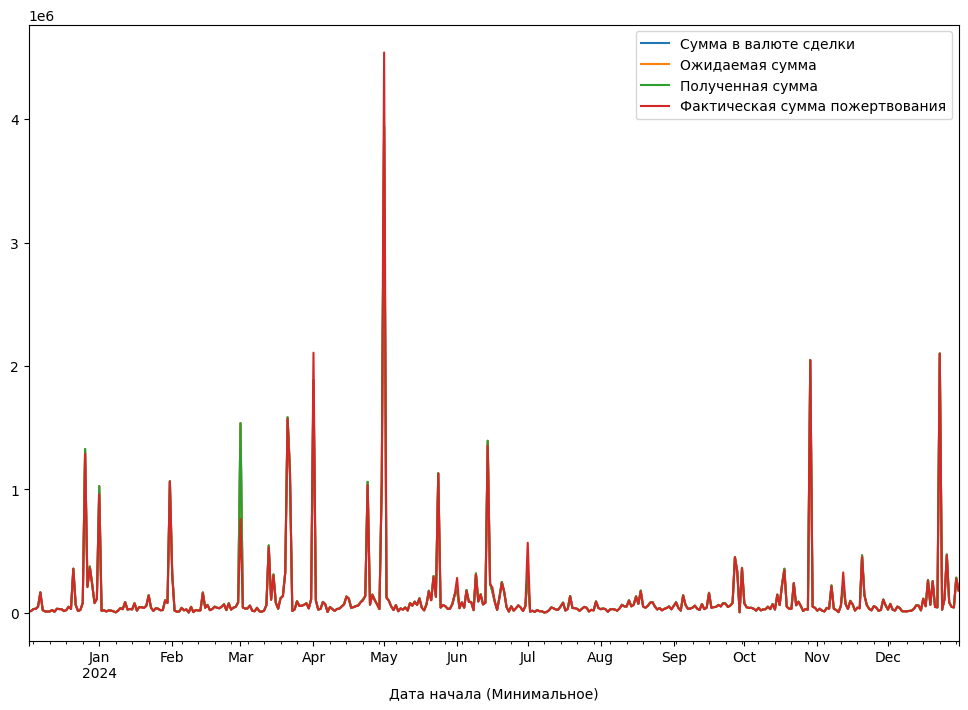

In [42]:
fig = plt.figure(figsize=(12, 8))
dd = rawdata.query('`В стадии: Удачно` == "Да" and `Ожидаемая сумма` > 0 and `Дата начала (Минимальное)` > "2023.12.01"')
for col in ['Сумма в валюте сделки', 'Ожидаемая сумма', 'Полученная сумма', 'Фактическая сумма пожертвования']:
  dd.groupby('Дата начала (Минимальное)')[col].sum().plot(label=col)
plt.legend()
plt.show()

Несколько колонок с суммами: «Сумма в валюте сделки», «Полученная сумма», «Ожидаемая сумма», «Фактическая сумма пожертвования». Первые три, как правило, равны. «Фактическая сумма поступлений» — это с минусом комиссии банка или еще чего — по 3% в большинстве транзакций.

Так как мы анализируем поведение пользователей, то удобнее и логичнее работать с «Сумма в валюте сделки».

### Даты

4 колонки связаны с датами транзакций. Надо выбрать, какая из них пойдет в основное исследование.

In [43]:
rawdata[['Дата начала (Минимальное)', 'Дата создания', 'Дата изменения', 'Датавремя платежа']].describe()

Дата начала (Минимальное)                  Дата создания  \
count                          34355                          34355   
mean   2023-10-31 19:18:29.812254464  2023-11-30 00:43:10.365303552   
min              2017-10-31 00:00:00            2022-08-01 00:00:00   
25%              2023-05-05 00:00:00            2023-05-06 00:00:00   
50%              2023-12-08 00:00:00            2023-12-18 00:00:00   
75%              2024-06-14 00:00:00            2024-06-15 00:00:00   
max              2024-12-31 00:00:00            2025-01-17 00:00:00   

                      Дата изменения              Датавремя платежа  
count                          34355                          30006  
mean   2024-01-09 09:01:55.371852544  2024-01-04 14:29:00.611877632  
min              2022-08-01 00:00:00            2019-09-30 00:00:00  
25%              2023-07-17 00:00:00            2023-07-11 00:00:00  
50%              2024-02-21 00:00:00            2024-01-08 00:00:00  
75%              2024-07-10 00:00:00            2024-06-25 00:00:00  
max              2025-03-13 00:00:00            2024-12-31 00:00:00

In [44]:
rawdata.query('`Датавремя платежа` != `Дата начала (Минимальное)`')\
 [['Стадия сделки', 'В стадии: Удачно',
   'Сумма в валюте сделки', 'Ожидаемая сумма', 'Полученная сумма',
   'Дата начала (Минимальное)', 'Дата создания', 'Дата изменения', 'Датавремя платежа']].head(10)

Стадия сделки В стадии: Удачно  Сумма в валюте сделки  Ожидаемая сумма  \
385    Closed Won               Да                   0.00             0.00   
386    Closed Won               Да                   0.00             0.00   
387    Closed Won               Да                   0.00             0.00   
388    Closed Won               Да                   0.00             0.00   
389    Closed Won               Да                   0.00             0.00   
390    Closed Won               Да                   0.00             0.00   
391    Closed Won               Да                   0.00             0.00   
392    Closed Won               Да                   0.00             0.00   
393    Closed Won               Да                   0.00             0.00   
394    Closed Won               Да                   0.00             0.00   

     Полученная сумма Дата начала (Минимальное) Дата создания Дата изменения  \
385              0.00                2024-04-26    2024-04-26     2024-04-26   
386              0.00                2024-05-05    2024-05-05     2024-05-05   
387              0.00                2024-05-05    2024-05-05     2024-05-05   
388              0.00                2024-05-03    2024-05-03     2024-05-03   
389              0.00                2024-05-03    2024-05-03     2024-05-03   
390              0.00                2024-05-03    2024-05-03     2024-05-03   
391              0.00                2024-05-01    2024-05-01     2024-05-01   
392              0.00                2024-04-29    2024-04-29     2024-04-29   
393              0.00                2024-04-29    2024-04-29     2024-04-29   
394              0.00                2024-04-29    2024-04-29     2024-04-29   

    Датавремя платежа  
385               NaT  
386               NaT  
387               NaT  
388               NaT  
389               NaT  
390               NaT  
391               NaT  
392               NaT  
393               NaT  
394               NaT

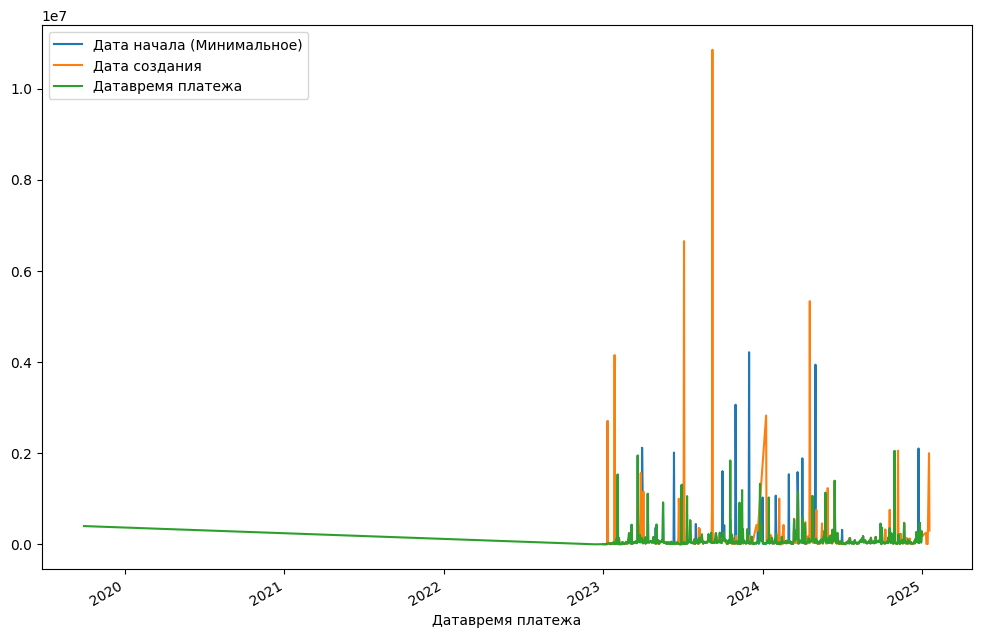

In [45]:
fig = plt.figure(figsize=(12, 8))
dd = rawdata.query('`В стадии: Удачно` == "Да" and `Ожидаемая сумма` > 0 and `Дата начала (Минимальное)` > "2023.01.01"')
for col in ['Дата начала (Минимальное)', 'Дата создания', 'Датавремя платежа']:
  dd.groupby(col)['Сумма в валюте сделки'].sum().plot(label=col)
plt.legend()
plt.show()

Много колонок с датами: Дата начала (Минимальное), Дата создания, Дата изменения, Дата/время платежа — они все отражают разные стадии, условно: дата занесения в CRM, дата выставления счета, дата оплаты, дата фактического поступления на счет фонда. Между ними может быть несколько дней, причем в обе стороны. =)

Дата начала (Минимальное) — минимальная из этих дат. Для дальнейшего анализа берем ее.

### Категориальные колонки параметров платежа

Смотрим по перспективным колонкам, какие есть значения и сколько их. Берем только успешные транзакции с ненулевой суммой. В приоритете колонки с несколькими значениями, и есть более-менее баланс между количеством каждого значения.

In [46]:
for col in ['Action (строка)', 'Action (ссылка)', 'Сайт - источник',  'SITE_NAME',
            'Название таргета', 'Платежный шлюз', 'Код (список)', 'Код (строка)',
            'Комментарий']:
  print(f'------------- {col} -----------------------')
  display(rawdata.query('`В стадии: Удачно` == "Да" and `Ожидаемая сумма` > 0')[col].value_counts().head(10).to_frame().T)
  print()

------------- Action (строка) -----------------------


Action (строка)  orange2023   th  \
count                  1369  657   

Action (строка)  vesenni-blagotvoritelnyy-zabeg-sport-vo-blago-14-10-2023  \
count                                                                 618   

Action (строка)  jam2024  maple2023  school24  action  elki2025  \
count                515        504       453     433       422   

Action (строка)  vesenni-blagotvoritelnyy-zabeg-sport-vo-blago-25-05-2024  \
count                                                                 395   

Action (строка)  elki2024  
count                 389


------------- Action (ссылка) -----------------------


Action (ссылка)  orange2023   th  \
count                  1368  657   

Action (ссылка)  vesenni-blagotvoritelnyy-zabeg-sport-vo-blago-14-10-2023  \
count                                                                 618   

Action (ссылка)  jam2024  maple2023  school24  action  elki2025  \
count                515        504       453     433       423   

Action (ссылка)  vesenni-blagotvoritelnyy-zabeg-sport-vo-blago-25-05-2024  \
count                                                                 395   

Action (ссылка)  elki2024  
count                 389


------------- Сайт - источник -----------------------


Сайт - источник    sdl   svb  turnonheart    0  thermos  dsu
count            17355  4255          657  433       34   17


------------- SITE_NAME -----------------------


SITE_NAME   sdl  svb  shop  turnonheart  thermos
count      3752  446    95           72        1


------------- Название таргета -----------------------


Название таргета  Широкие потребности ДСА/СЛ  \
count                                     20   

Название таргета  СЛ Пожертвование на программы и уставную  \
count                                                   12   

Название таргета  ДСА Пожертвование на программы и уставную  Забег  \
count                                                     7      4   

Название таргета  Соцмаркетинг  Футбол  Сайклинг  Онлайн-акция ёлки  \
count                        4       3         3                  3   

Название таргета  Онлайн-акция клёны  Онлайн-акция апельсины  
count                              2                       1


------------- Платежный шлюз -----------------------


Платежный шлюз  cloud  Сбербанк СЛ  Сбербанк ДСА  POS_TERM  Cash  \
count           22703         1002           444         4     3   

Платежный шлюз  Райффайзен СЛ  
count                       1


------------- Код (список) -----------------------


Код (список)  f212  f214  f405  f207  f215  f211  f204  f112  f517  f114
count         8290  2708  2500  2339  2251  1773  1705   824   433   398


------------- Код (строка) -----------------------


Код (строка)  f212  f405  f207  f215  f211  f204  f214  f112  f517  f114
count         8238  2528  2210  2103  1773  1707  1540   820   433   401


------------- Комментарий -----------------------


Комментарий  Ежемесячное пожертвование в БФ "Синдром любви"  \
count                                                  8779   

Комментарий  Разовое пожертвование в БФ "Синдром любви"  \
count                                              4292   

Комментарий  Поддержать соревнование  \
count                           2320   

Комментарий  Благотворительный забег «СПОРТ ВО БЛАГО»  \
count                                              998   

Комментарий  Пожертвование в рамках акции «Апельсины», 590  \
count                                                  489   

Комментарий  Пожертвование в рамках акции «Апельсины», 280  \
count                                                  482   

Комментарий  Благотворительный забег «СПОРТ ВО БЛАГО»  \
count                                             424   

Комментарий  Разовое пожертвование в рамках акции «Новогодний подарок!», 280  \
count                                                                    269   

Комментарий  Благотворительный осенний забег «СПОРТ ВО БЛАГО»  \
count                                                      247   

Комментарий  Разовое пожертвование в рамках акции «Особенное варенье!», 300  
count                                                                   216

Отдельно посмотрим колонки с двумя уникальными значениями — видимо, логическими «Да»/«Нет». Выбираем колонки, в которых доля меньшего значения хотя бы больше 5%.

In [47]:
check_bool_col(rawdata)

[30410, 3945] 	 11.5% 	 В стадии: В работе
[25230, 9125] 	 26.6% 	 В стадии: Удачно
[29175, 5180] 	 15.1% 	 В стадии: Не удачно
[30410, 3945] 	 11.5% 	 Сделка закрыта
[23607, 10748] 	 31.3% 	 Повторная сделка
[4, 1] 	 20.0% 	 UTM Term
[32081, 2274] 	 6.6% 	 ВИД платежа


Для дальнейшего анализа берем:

- Сайт - источник
- Код (список)
- Комментарий
- Action (строка)

### Категориальные колонки портрета пользователей

In [48]:
for col in ['Контакт: Источник', 'Контакт: Источник контакта', 'Контакт: Целевая группа',
            'Контакт: Сегмент', 'Контакт: Новый донор тип', 'Контакт: Пол']:
  print(f'------------- {col} -----------------------')
  display(kontact[col].value_counts().head(10).to_frame().T)
  print()

------------- Контакт: Источник -----------------------


Контакт: Источник  Cloudpayments  Загрузка из файла  Существующий клиент  \
count                       6661               3250                  815   

Контакт: Источник  Подписка на новости на сайте СЛ  Исходящий звонок  \
count                                           25                18   

Контакт: Источник  CRM-форма  Мероприятие  Исходящее электронное письмо  \
count                      9            4                             2   

Контакт: Источник  Реестры Сбербанк  Входящее письмо  
count                             1                1


------------- Контакт: Источник контакта -----------------------


Контакт: Источник контакта  Other  Meropr  OurFamily  от друзей  Manasov  \
count                         213     162         15          8        6   

Контакт: Источник контакта  Employee  профильные сайты  Web Site  SMI  \
count                              6                 5         5    3   

Контакт: Источник контакта  директор фонда  
count                                    2


------------- Контакт: Целевая группа -----------------------


Контакт: Целевая группа  donor  prospective
count                      434           61


------------- Контакт: Сегмент -----------------------


Контакт: Сегмент  Активный   Нет  Уснувший  Потерянный
count                 7032  2184      1822         140


------------- Контакт: Новый донор тип -----------------------


Контакт: Новый донор тип  WL СЛ   СВБ  DSU  WL elki корп  \
count                      5023  2795  454           162   

Контакт: Новый донор тип  WL СЛ новые родители  \
count                                      159   

Контакт: Новый донор тип  WL CЛ новые пользователи портала ДСА  WL СЛ ВИД  \
count                                                       72         64   

Контакт: Новый донор тип  WL CЛ новые родители  WL SL  \
count                                       60     57   

Контакт: Новый донор тип  First donation prospecting  
count                                             46


------------- Контакт: Пол -----------------------


Контакт: Пол     Ж     0     М
count         4889  3136  2165

Отдельно посмотрим колонки с двумя уникальными значениями — видимо, логическими «Да»/«Нет». Выбираем колонки, в которых доля меньшего значения хотя бы больше 5%.

In [49]:
check_bool_col(kontact)

[7, 5] 	 41.7% 	 Контакт: Готовность стать интегративным волонтером
[7, 5] 	 41.7% 	 Контакт: Готовность стать волонтером-сопровождающим
[8, 4] 	 33.3% 	 Контакт: Я не против добавления в чат волонтеров
[434, 61] 	 12.3% 	 Контакт: Целевая группа
[9068, 2112] 	 18.9% 	 Контакт: ЭН
[10543, 637] 	 5.7% 	 Контакт: ЭН-корпоратив
[10323, 857] 	 7.7% 	 Контакт: Участник мероприятия
[10241, 939] 	 8.4% 	 Контакт: Родитель ДСА
[10337, 843] 	 7.5% 	 Контакт: Регулярные списания остановлены
[9921, 1259] 	 11.3% 	 Контакт: ВИД
[2324, 1190] 	 33.9% 	 Контакт: Сегментация Рекуррент
[9990, 1190] 	 10.6% 	 Контакт: Сегментация Рекуррент Флажок
[10133, 1047] 	 9.4% 	 Контакт: Служебное: Unisender.Контакт.F207
[10148, 1032] 	 9.2% 	 Контакт: Служебное: Welcome не Донор отправлен
[6464, 4716] 	 42.2% 	 Контакт: Служебное: Welcome донор отправлен


Для дальнейшего анализа берем

- Контакт: Источник контакта
- Контакт: пол
- Контакт: регион
- Контакт: город
- Контакт: Новый донор тип
- Контакт: ВИД
- Контакт: ЭН

## Пересечения таблиц компаний и контактов

Успешные транзакции без user_id, но с comp_id

In [50]:
print(len(rawdata.query('~comp_id.isna() and user_id.isna() and `В стадии: Удачно` == "Да"')))
print(rawdata.query('~comp_id.isna() and user_id.isna() and `В стадии: Удачно` == "Да"')['Сумма в валюте сделки'].sum())

159
11508704.0


Есть транзакции без указателя на пользователя, но с указанием на компанию. Таких донатов мало, но сумма приличная - надо это учитывать

Успешные транзакции без user_id и без comp_id

In [51]:
print(len(rawdata.query('comp_id.isna() and user_id.isna() and `В стадии: Удачно` == "Да"')))
print(rawdata.query('comp_id.isna() and user_id.isna() and `В стадии: Удачно` == "Да"')['Сумма в валюте сделки'].sum())

12
9290.8


Есть транзакции без указателя на пользователя или компанию... К счастью их мало.

**Промежуточные итоги:**

Провели разведочный анализ данных. По его итогам берем для дальнейшего анализа колонки:

'ID', 'Дата начала (Минимальное)', 'Сумма в валюте сделки', 'Контакт: ID', 'Комментарий', 'Сайт - источник', 'Action (строка)', 'Код (список)', а также 'Контакт: Регион_', 'Контакт: город',  'Контакт: Пол', 'Контакт: Источник контакта', 'Контакт: Новый донор тип', 'Контакт: ВИД', 'Контакт: ЭН'.


Также выявлены транзакции без указателя на пользователя, но с указанием на компанию. Это надо учесть при формировании датасета для основного анализа

In [52]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-16 20:37:13.033028+04:00
 От начала рассчета прошло 0:00:18.271978


#Датасеты для основного анализа

Основной анализ проведем на свежих данных только за 2023-2024 годы, так как паттерны поведения в современном мире быстро меняются, и практики привлечения и удержания жертводателей, бывшие успешными более 2-3 лет назад, сейчас могут уже не сработать.

Берем только транзакции, за заданный именем файла период, которые завершились успешно с суммой больше 10, чтобы отсечь "тестовые" транзакции, и указанным user_id.

In [53]:
all = 0
rawdt = pd.DataFrame([])
for ff in os.listdir(path):
  filename, fileexp = os.path.splitext(ff)
  if fileexp == '.csv':
    min_date = pd.to_datetime(filename.split('-')[0], format='%d.%m.%Y')
    max_date = pd.to_datetime(filename.split('-')[1], format='%d.%m.%Y')
    #print(filename, min_date, max_date)
    dd = pd.read_csv(path + ff)
    dd['file'] = ff
    l = len(dd)
    all = all + l
    #Заполняем пропуски в `Контакт: ID` значенеим `Компания: ID` + 1000000
    dd['Компания: ID'] = dd['Компания: ID'].fillna(0)
    dd['Контакт: ID'] = dd['Контакт: ID'].fillna(dd['Компания: ID'] + 1000000)
    dd['Дата начала (Минимальное)'] = pd.to_datetime(dd['Дата начала (Минимальное)'], format='%d.%m.%Y')
    dd['Сумма в валюте сделки'] = dd['Сумма в валюте сделки']\
        .str.replace(' ', '')\
        .str.replace('\xa0','').astype('float')
    dd = dd.query('`Дата начала (Минимальное)` >= @min_date\
            and `Дата начала (Минимальное)` <= @max_date\
            and `Сумма в валюте сделки` > 10\
            and `В стадии: Удачно` == "Да"\
            and `Контакт: ID` > 0')
    rawdt = pd.concat([rawdt, dd])
    print(f'Загрузка {l} строк данных из файла {ff}')

print(f'Всего загружено {all} строк')
rawdt = rawdt.sort_values(by='Дата начала (Минимальное)').reset_index(drop=True)

Загрузка 8928 строк данных из файла 01.01.2024-30.06.2024.csv
Загрузка 7930 строк данных из файла 01.01.2023-30.06.2023.csv
Загрузка 8917 строк данных из файла 01.07.2023-31.12.2023.csv
Загрузка 8580 строк данных из файла 01.07.2024-31.12.2024.csv
Всего загружено 34355 строк


In [54]:
rawdt.head(5)

ID  Название (Количество уникальных)  \
0  332345                              1.00   
1  332331                              1.00   
2  332333                              1.00   
3  332337                              1.00   
4  332339                              1.00   

   Стадия сделки (Количество уникальных)  \
0                                   1.00   
1                                   1.00   
2                                   1.00   
3                                   1.00   
4                                   1.00   

   Ответственный (Количество уникальных) Дата начала (Минимальное)  \
0                                   1.00                2023-01-01   
1                                   1.00                2023-01-01   
2                                   1.00                2023-01-01   
3                                   1.00                2023-01-01   
4                                   1.00                2023-01-01   

                                      Комментарий Направление сделки  \
0      Разовое пожертвование в БФ "Синдром любви"      Пожертвования   
1  Ежемесячное пожертвование в БФ "Синдром любви"      Пожертвования   
2  Ежемесячное пожертвование в БФ "Синдром любви"      Пожертвования   
3  Ежемесячное пожертвование в БФ "Синдром любви"      Пожертвования   
4  Ежемесячное пожертвование в БФ "Синдром любви"      Пожертвования   

  Стадия сделки В стадии: В работе В стадии: Удачно  ... SITE_NAME  \
0        Posted                Нет               Да  ...       NaN   
1        Posted                Нет               Да  ...       NaN   
2        Posted                Нет               Да  ...       NaN   
3        Posted                Нет               Да  ...       NaN   
4        Posted                Нет               Да  ...       NaN   

  Тип пожертвования Источник пожертвования  Мероприятие Дата рождения ребенка  \
0               NaN                    NaN          NaN                   NaN   
1               NaN                    NaN          NaN                   NaN   
2               NaN                    NaN          NaN                   NaN   
3               NaN                    NaN          NaN                   NaN   
4               NaN                    NaN          NaN                   NaN   

  Информация о родстве Служебное: Copy ID Служебное: Таргеты: Цикл ожидания  \
0                  NaN          332345.00                               Нет   
1                  NaN          332331.00                               Нет   
2                  NaN          332333.00                               Нет   
3                  NaN          332337.00                               Нет   
4                  NaN          332339.00                               Нет   

                        file  \
0  01.01.2023-30.06.2023.csv   
1  01.01.2023-30.06.2023.csv   
2  01.01.2023-30.06.2023.csv   
3  01.01.2023-30.06.2023.csv   
4  01.01.2023-30.06.2023.csv   

   Контакт: Аналитика:Количество пожертвований за этот ФИНАНСОВЫЙ год (1 июля-30 июня)  
0                                                                                 4.00  
1                                                                                 6.00  
2                                                                                 6.00  
3                                                                                 6.00  
4                                                                                 8.00  

[5 rows x 229 columns]

## Строим таблицу транзакций

Берем только нужные для дальнейшего анализа колонки

In [55]:
tranz = rawdt[['ID', 'Дата начала (Минимальное)', 'Контакт: ID', 'Компания: ID',
               'Сумма в валюте сделки',
               'Комментарий', 'Сайт - источник', 'Action (строка)', 'Код (список)',
               'Контакт: Регион_', 'Контакт: Город_', 'Контакт: Пол', 'Контакт: ЭН',
               'Контакт: Источник контакта', 'Контакт: Новый донор тип', 'Контакт: ВИД']].copy()
tranz = tranz.drop_duplicates()
tranz = tranz.reset_index(drop=True)
tranz.columns = ['id', 'date', 'user_id', 'comp_id', 'donate', 'comment', 'site',  'action', 'code',
                 'region', 'city', 'gender', 'en', 'source', 'donor_type', 'vid']

Преобразуем типы, добавляем "усеченные" даты

In [56]:
tranz['user_id'] = tranz['user_id'].astype('int')
tranz['comp_id'] = tranz['comp_id'].astype('int')
tranz['tr_m'] = tranz['date'].dt.month
tranz['tr_y'] = tranz['date'].dt.year
tranz['tr_ym'] = (tranz['tr_y'] - tranz['tr_y'].min()) * 12 + tranz['tr_m']
tranz['tr_month'] = tranz.apply(lambda row: f"{row['tr_y']}_{str(row['tr_m']):0>2}", axis=1)

Заполняем пропуски заглушкой 'Не указано'

In [57]:
tranz['site'] = tranz['site'].fillna('Не указано')
tranz['gender'] = tranz['gender'].fillna('Не указано')
tranz['code'] = tranz['code'].fillna('Не указано')
tranz['comment'] = tranz['comment'].fillna('Не указано')
tranz['action'] = tranz['action'].fillna('Не указано')

tranz['gender'] = tranz['gender'].fillna('Не указано')
tranz['city'] = tranz['city'].fillna('Не указано')
tranz['region'] = tranz['region'].fillna('Не указано')
tranz['donor_type'] = tranz['donor_type'].fillna('Не указано')
tranz['source'] = tranz['source'].fillna('Не указано')


Заполняем непонятные значения заглушкой 'Не указано'

In [58]:
tranz['site'] = tranz['site'].replace({'0' : 'Не указано'})
tranz['gender'] = tranz['gender'].replace({'0' : 'Не указано'})

Приводим дубли в категориальных колонках к единому виду

In [59]:
tranz['city'] = tranz['city'].replace(r'.*Моск.*', 'Москва', regex=True)
tranz['city'] = tranz['city'].str.replace(r'^г.', '', regex=True)\
    .str.replace(r'^д.', '', regex=True).str.replace(r'^пос.', '', regex=True)\
    .str.replace(r'^п.', '', regex=True).str.replace(r'^с.', '', regex=True)\
    .str.replace(r'^c.', '', regex=True).str.replace(r'^ст.', '', regex=True)\
    .str.strip()

tranz['region'] = tranz['region'].replace(r'.*Моск.*', 'Москва', regex=True)

In [60]:
tranz['comment'] = tranz['comment'].str.strip()\
  .replace({'Благотворительный забег «СПОРТ ВО БЛАГО»' : 'Благотворительный забег «СПОРТ ВО БЛАГО»'})

Словарь для кодов

In [61]:
codelib = {'210' : 'Сборы на сторонних площадках (Вклад в будущее, Мэйлру, Нужна помощь и пр.)',
'211' : 'Частные доноры Рассылки',
'212' : 'Частные доноры Регулярные пожертвования',
'214' : 'Разовые пожертвования картой через сайт, ящики в фонде',
'215' : 'Пожертвования через СМС и спец ссылки',
'216' : 'Телемаркетинг',
'111' : 'ВИД Рассылки',
'112' : 'ВИД Регулярные списания',
'109' : 'ВИД (юрид. лица)',
'114' : 'ВИД массовые акции',
'208' : 'ВИД Мероприятия',
'209' : 'ВИД пожертвования',
'101' : 'Партнер велосотни',
'102' : 'Партнеры футбол',
'104' : 'Партнеры пробега и трейла',
'105' : 'Корпоративные пожертвования на программы',
'405' : 'Социальный маркетинг, пожертвования сотрудников (кроме АВБ)',
'201' : 'СВБ инд. учстники велосотня',
'204' : 'СВБ инд. учстники пробег и рейл',
'207' : 'АВБ',
'306' : 'Гранты, субсидии',
'517' : 'Магазин',
'519' : 'Консультационная деятельность',
'103' : 'Партнер(ы) лыжи',
'106' : 'Корпоративные гранты на программы',
'107' : 'Проекты корпоративных партнеров (спорт и не спорт) с потенциалом увеличения базы частных доноров',
'203' : 'СВБ инд. учстники лыжи',
'305' : 'Событийный фандрайзинг',
'401' : 'Внутренний корпоративный фандрайзинг по велосотне',
'402' : 'Внутренний корпоративный фандрайзинг по футболу',
'403' : 'Внутренний корпоративный фандрайзинг по лыжам',
'404' : 'Внутренний корпоративный фандрайзинг по пробегу и трейлу'}

tranz['code'] = tranz['code'].replace(codelib, regex=True).str.replace('f', '')

Выделяем в отдельную таблицу корпоративных жертвователей, чтобы они не искажали паттерны поведения частных пользователей.

In [62]:
corp = tranz.query('comp_id != 0').copy()
corp = corp.reset_index(drop=True)
tranz = tranz.query('comp_id == 0').copy()
tranz = tranz.reset_index(drop=True)

## Строим таблицу пользователей на основе транзакций

In [63]:
user_table = get_user_table(tranz)
user_table.head(5)

user_id first_date  last_date  donate_sum  tr_count  first_month  \
0   333699 2023-08-25 2023-10-10     3000.00         3            8   
1   333801 2023-04-19 2023-04-19     2000.00         1            4   
2   333803 2023-12-08 2023-12-08      500.00         1           12   
3   333873 2023-06-09 2023-06-09     2000.00         1            6   
4   334671 2023-05-18 2023-05-18    70000.00         1            5   

   first_year  first_ym  day_on  month_on  oper_frec     type  day_last  
0        2023         8      46         2       1.50  Простой       448  
1        2023         4       0         1       1.00  Разовый       622  
2        2023        12       0         1       1.00  Разовый       389  
3        2023         6       0         1       1.00  Разовый       571  
4        2023         5       0         1       1.00  Разовый       593

Переносим сегменты донаторов и в таблицу транзакций для удобства

In [64]:
tranz = tranz.merge(user_table[['user_id', 'type']], on='user_id')

**Промежуточные итоги:**

Сформировали таблицу транзакций на основе исходного датасета, взяв из него данные только из выбранных колонок. Преобразовали типы данных, заполнили пропуски «заглушками», исправили закодированные значения. На основе таблицы транзакций построили таблицу пользователей с необходимыми метриками по каждому пользователю.

In [65]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-16 20:37:23.246309+04:00
 От начала рассчета прошло 0:00:28.485252


# Метрики и графики

In [66]:
period = (tranz['date'].max() - tranz['date'].min()).days
tr_all = tranz['id'].count()
donate_all = tranz['donate'].sum()
user_all = tranz['user_id'].nunique()

comp_all = corp['comp_id'].nunique()
comp_tr = corp['id'].count()
comp_users = corp['user_id'].nunique()
comp_sum = corp['donate'].sum()

donate_mean = tranz['donate'].mean()
donate_median = tranz['donate'].median()
oper_frec_mean = user_table.query('day_on > 0')['oper_frec'].mean()

subscr_users = tranz.query('type == "Подписчик"')['user_id'].unique()
subscr_donate = tranz.query('type == "Подписчик"')['donate'].sum()
simple_users = tranz.query('type == "Простой"')['user_id'].unique()
simple_donate = tranz.query('type == "Простой"')['donate'].sum()
one_time_users = tranz.query('type == "Разовый"')['user_id'].unique()
one_time_donate = tranz.query('type == "Разовый"')['donate'].sum()

new_user_day = tranz[['date','user_id']].drop_duplicates(['user_id']).groupby('date').count()['user_id'].mean()
day_on_mean = user_table.query('day_on > 0')['day_on'].mean()

tr_count_mean = user_table['tr_count'].mean()
tr_count_median = user_table['tr_count'].median()
tr_count_mean_reg = user_table.query('day_on > 0')['tr_count'].mean()

code_tr = tranz.query('code != "Не указано"')['id'].count()
comment_tr = tranz.query('comment != "Не указано"')['id'].count()
action_tr = tranz.query('action != "Не указано"')['id'].count()

print(f"Период {tranz['date'].min()} - {tranz['date'].max()}")

print(50*'-')
print(f"Общее количество успешных транзакций {tr_all}")
print(f"Общая сумма донатов {donate_all:,.0f} руб.".replace(',', ' '))
print(f"Общее количество пользователей {user_all}")

print(50*'-')
print(f"Общее количество компаний {comp_all}")
print(f"Общее количество пользователей из компаний {comp_users}")
print(f"Общее количество донатов из компаний {comp_tr}")
print(f"Общее сумма донатов из компаний {comp_sum:,.0f} руб.".replace(',', ' '))

print(50*'-')
print(f"Количество ежемесяных донаторов (подписчики) {len(subscr_users)} ({len(subscr_users) / user_all:.2%})")
print(f"Количество разовых донаторов {len(one_time_users)} ({len(one_time_users) / user_all:.2%})")
print(f"Количество сделавших более 1 пожертвования пользователей без подписки {len(simple_users)} ({len(simple_users) / user_all:.2%})")

print(50*'-')
print(f"Общая сумма донатов от подписчиков {subscr_donate:,.0f} руб.".replace(',', ' '))
print(f"Общая сумма донатов от разовых донаторов {one_time_donate:,.0f} руб.".replace(',', ' '))
print(f"Общая сумма донатов от сделавших более 1 пожертвования без пидписки {simple_donate:,.0f} руб.".replace(',', ' '))

print(50*'-')
print(f"Среднее количечство донатов в день {tr_all / period:.0f}")
print(f"Среднее количество новых пользователей в день {new_user_day:.0f}")
print(f"Средняя сумма донатов в день {donate_all / period:,.0f} руб.".replace(',', ' '))

print(50*'-')
print(f"Средняя сумма донатов на пользователя {donate_all / user_all:.0f} руб.")
print(f'Среднее количество транзакций на пользователя {tr_count_mean:.0f}')
print(f'Медианное количество транзакций на пользователя {tr_count_median:.0f}')

print(50*'-')
print(f'Средняя сумма одного доната {donate_mean:.0f} руб.')
print(f'Медианная сумма одного доната {donate_median:.0f} руб.')

print(50*'-')
print(f'Среднее время жизни пользователя {day_on_mean:.0f} дней (исключая разовых)')
print(f'Среднее количество транзакций на пользователя {tr_count_mean_reg:.0f} (исключая разовых)')
print(f'Средняя частота донатов {oper_frec_mean:.2f} (транзакций в месяц, исключая разовых)')

print(50*'-')
print(f"Доля транзакций с кодом {code_tr / tr_all:.2%}")
print(f"Доля транзакций с комментом {comment_tr / tr_all:.2%}")
print(f"Доля транзакций с меткой в ссылке {action_tr / tr_all:.2%}")

Период 2023-01-01 00:00:00 - 2024-12-31 00:00:00
--------------------------------------------------
Общее количество успешных транзакций 21896
Общая сумма донатов 46 609 967 руб.
Общее количество пользователей 8563
--------------------------------------------------
Общее количество компаний 36
Общее количество пользователей из компаний 39
Общее количество донатов из компаний 176
Общее сумма донатов из компаний 23 566 798 руб.
--------------------------------------------------
Количество ежемесяных донаторов (подписчики) 587 (6.86%)
Количество разовых донаторов 6473 (75.59%)
Количество сделавших более 1 пожертвования пользователей без подписки 1503 (17.55%)
--------------------------------------------------
Общая сумма донатов от подписчиков 10 531 811 руб.
Общая сумма донатов от разовых донаторов 18 431 382 руб.
Общая сумма донатов от сделавших более 1 пожертвования без пидписки 17 646 773 руб.
--------------------------------------------------
Среднее количечство донатов в день 30
Сре

## Динамика донатов и пользователей по дням

In [67]:
day_dynamik = tranz.groupby('date').agg({'date' : 'min', 'id' : 'count', 'donate' : ['sum', 'mean'], 'user_id' : 'nunique'})
day_dynamik.columns = ['date', 'tr_count', 'donate_sum', 'donate_mean', 'user_count']
day_dynamik['d_cumsum'] = day_dynamik['donate_sum'].cumsum()
day_dynamik['date'] = pd.to_datetime(day_dynamik['date'], format = '%Y-%m-%d', errors = 'coerce')

day_dynamik['u_newcount'] = tranz[['date','user_id']].drop_duplicates(['user_id']).groupby('date').count()
day_dynamik['u_cumcount'] = tranz[['date','user_id']].drop_duplicates(['user_id']).groupby('date').count().cumsum()
day_dynamik['u_cumcount'] = day_dynamik['u_cumcount'].ffill()

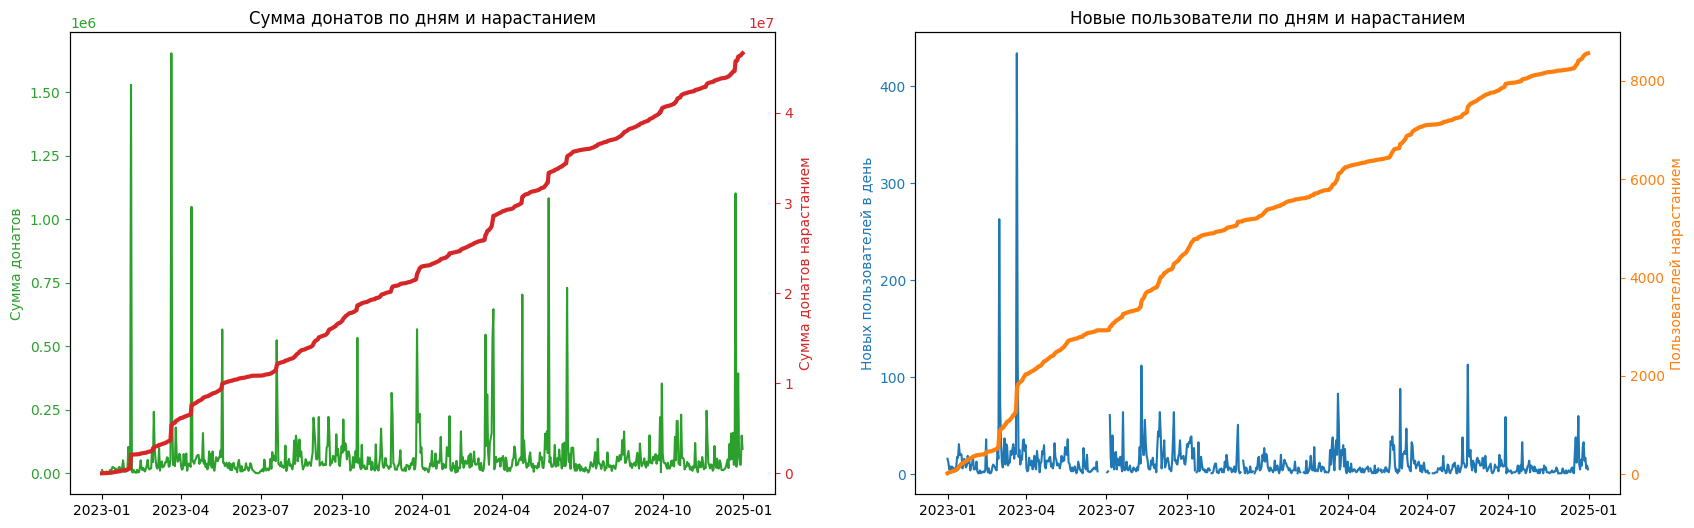

In [68]:
f, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].plot(day_dynamik['date'], day_dynamik['donate_sum'],  color='tab:green')
ax[0].set_ylabel('Сумма донатов', color='tab:green')
ax[0].tick_params(axis='y', colors='tab:green')
ax02 = ax[0].twinx()
ax02.plot(day_dynamik['date'], day_dynamik['d_cumsum'], color='tab:red', linewidth = 3)
ax02.set_ylabel('Сумма донатов нарастанием', color='tab:red')
ax02.tick_params(axis='y', colors='tab:red')
ax[0].set_title('Сумма донатов по дням и нарастанием')


ax[1].plot(day_dynamik['date'], day_dynamik['u_newcount'], color='tab:blue')
ax[1].set_ylabel('Новых пользователей в день', color='tab:blue')
ax[1].tick_params(axis='y', colors='tab:blue')
ax12 = ax[1].twinx()
ax12.plot(day_dynamik['date'], day_dynamik['u_cumcount'], color='tab:orange', linewidth = 3)
ax12.set_ylabel('Пользователей нарастанием', color='tab:orange')
ax12.tick_params(axis='y', colors='tab:orange')
ax[1].set_title('Новые пользователи по дням и нарастанием')

plt.show()

Из дневных графиков видно, что поступление донатов имеет «импульсный» характер. При этом в накопительном графике не видно продолжительных «полочек». То есть какой-то объем донатов поступает регулярно, но в основном средства поступают как бы импульсами — очевидно, после каких-либо акций и мероприятий.

## Даты, в которые было сделано большое количество пожертвований

In [69]:
godday100 = day_dynamik.query('tr_count > 100')
godday100

date  tr_count  donate_sum  donate_mean  user_count  \
date                                                                   
2023-03-01 2023-03-01       300   242136.00       807.12         294   
2023-03-21 2023-03-21       486  1654026.00      3403.35         476   
2023-03-22 2023-03-22       137   206831.00      1509.72         134   
2023-07-20 2023-07-20       154   227994.98      1480.49         153   
2023-08-10 2023-08-10       137   148130.00      1081.24         132   
2023-08-14 2023-08-14       113   133260.00      1179.29         113   
2023-10-14 2023-10-14       102    63870.00       626.18          95   
2023-11-28 2023-11-28       114   237259.00      2081.22         113   
2024-03-21 2024-03-21       152   527800.00      3472.37         150   
2024-05-31 2024-05-31       151   111650.00       739.40         114   
2024-08-16 2024-08-16       168   131058.00       780.11         154   
2024-09-28 2024-09-28       133   220950.00      1661.28         123   

              d_cumsum  u_newcount  u_cumcount  
date                                            
2023-03-01  2839431.99      263.00      811.00  
2023-03-21  5305454.99      434.00     1698.00  
2023-03-22  5512285.99      119.00     1817.00  
2023-07-20 12165038.15       64.00     3257.00  
2023-08-10 13115758.20      112.00     3509.00  
2023-08-14 13494928.21       56.00     3647.00  
2023-10-14 17893599.84       33.00     4821.00  
2023-11-28 20708415.84       51.00     5134.00  
2024-03-21 27936301.84       83.00     6068.00  
2024-05-31 33679402.84       88.00     6720.00  
2024-08-16 37618768.84      113.00     7472.00  
2024-09-28 40125599.84       59.00     7941.00

Даты, в которые было сделано большое количество пожертвований. Очевидно, это даты после наиболее успешных акций и мероприятий. Из таблицы видно, что «шлейфа» поступлений донатов на еще один-два дня после акций практически никогда нет.

21 марта — Международный день человека с синдромом Дауна.
А на 14 число, похоже, приходятся автоматические списания у подписчиков.

## Динамика донатов и пользователей по месяцам

In [70]:
month_dynamik = tranz.groupby('tr_month').agg({'date' : 'min', 'id' : 'count', 'donate' : ['sum', 'mean'], 'user_id' : 'nunique'})
month_dynamik.columns = ['date', 'tr_count', 'donate_sum', 'donate_mean', 'user_count']
month_dynamik['d_cumsum'] = month_dynamik['donate_sum'].cumsum()
month_dynamik['date'] = pd.to_datetime(month_dynamik['date'], format = '%Y-%m-%d', errors = 'coerce')

month_dynamik['u_newcount'] = tranz[['tr_month','user_id']].drop_duplicates(['user_id']).groupby('tr_month').count()
month_dynamik['u_cumcount'] = tranz[['tr_month','user_id']].drop_duplicates(['user_id']).groupby('tr_month').count().cumsum()
month_dynamik['u_cumcount'] = month_dynamik['u_cumcount'].ffill()


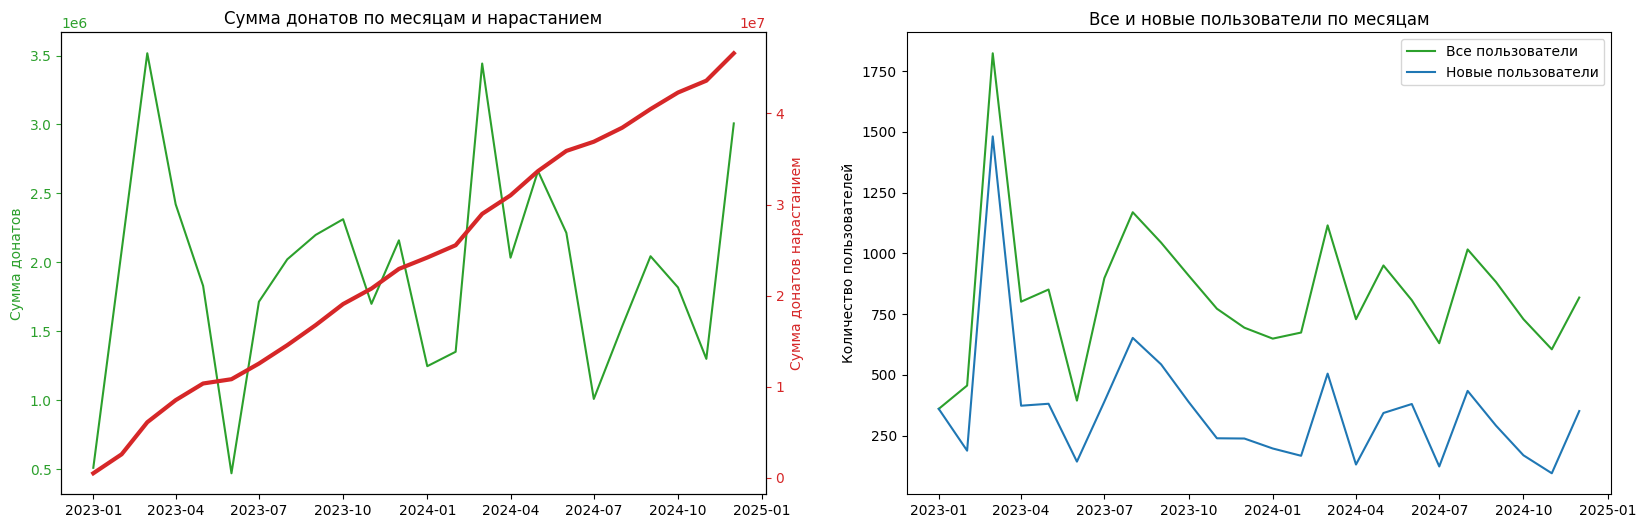

In [71]:
f, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].plot(month_dynamik['date'], month_dynamik['donate_sum'],  color='tab:green')
ax[0].set_ylabel('Сумма донатов', color='tab:green')
ax[0].tick_params(axis='y', colors='tab:green')
ax02 = ax[0].twinx()
ax02.plot(month_dynamik['date'], month_dynamik['d_cumsum'], color='tab:red', linewidth = 3)
ax02.set_ylabel('Сумма донатов нарастанием', color='tab:red')
ax02.tick_params(axis='y', colors='tab:red')
ax[0].set_title('Сумма донатов по месяцам и нарастанием')

ax[1].plot(month_dynamik['date'], month_dynamik['user_count'], color='tab:green', label='Все пользователи')
ax[1].plot(month_dynamik['date'], month_dynamik['u_newcount'], color='tab:blue', label='Новые пользователи')
ax[1].set_ylabel('Количество пользователей')
ax[1].set_title('Все и новые пользователи по месяцам')
ax[1].legend()
plt.show()

Динамика поступлений по месяцам показывает колебания поступлений донатов, которое хорошо соотносится с календарем успешных акций. Это в 2023 году это март, июль, август, октябрь и ноябрь, а в 2024 — март, май, август, сентябрь. Нет акции — поступления донатов падают.

Сильное падение донатов в июне 2023 года, похоже, связано с каким-то техническим сбоем. 10 дней — с 21 по 30 июня — либо вообще не было транзакций, либо по одной в день.

Приток новых жертвователей вполне вписывается в эти тренды и практически повторяет график динамики всех донаторов.

**Промежуточные итоги:**

Вывели основные числовые финансовые показатели фонда. График транзакций говорит о том, что поступления имеют как постоянную составляющую, так и "пики" в отдельные дни, которые, скорее всего, обусловлены акциями или мероприятиями.

# Самые-самые донаты

## Наиболее часто встречающиеся суммы донатов и количество донатов на человека

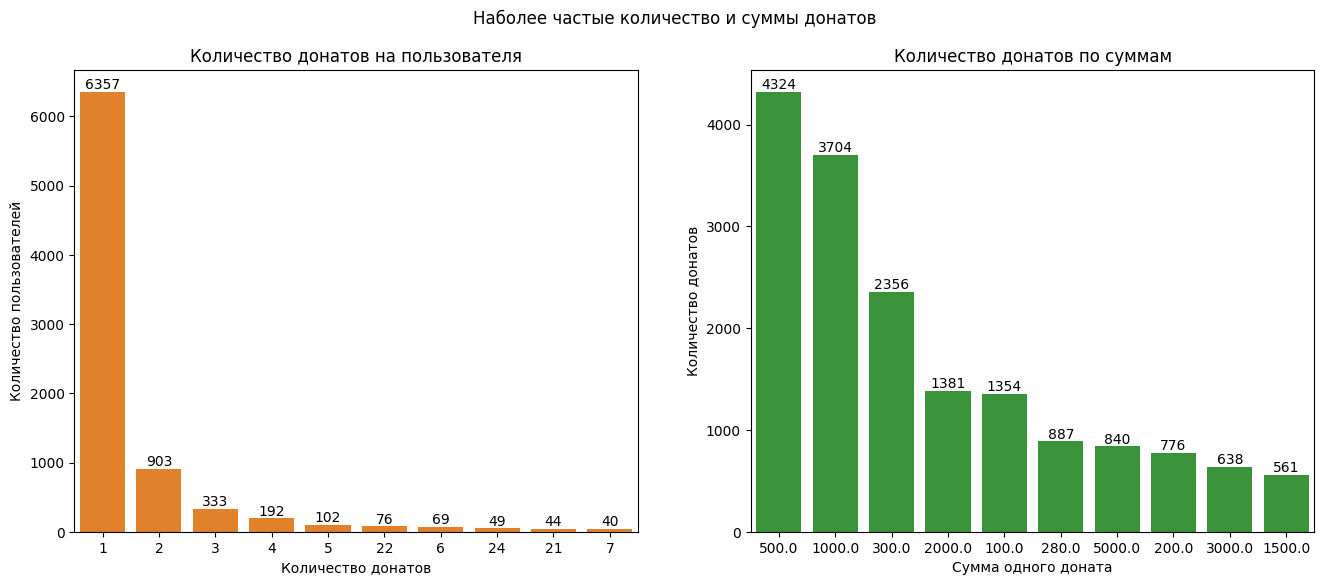

In [72]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
dd = tranz.query('comp_id == 0').groupby('user_id')['id'].count().value_counts().head(10)
dd.index = dd.index.map(str)
sns.barplot(y=dd, x=dd.index, color='tab:orange', ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10, label_type='edge', color='black')

ax[0].tick_params(axis='x', labelrotation = 0)
ax[0].set_xlabel('Количество донатов')
ax[0].set_ylabel('Количество пользователей')
ax[0].set_title('Количество донатов на пользователя')

dd = tranz.query('comp_id == 0')['donate'].value_counts().head(10)
dd.index = dd.index.map(str)
sns.barplot(y=dd, x=dd.index, color='tab:green', ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10, label_type='edge', color='black')

ax[1].set_xlabel('Сумма одного доната')
ax[1].set_ylabel('Количество донатов')
ax[1].set_title('Количество донатов по суммам')

plt.suptitle('Наболее частые количество и суммы донатов')
plt.show()

Самые часто встречающиеся суммы донатов — 500, 1000, 300 рублей. Подавляющее большинство пользователей ограничивается одним пожертвованием.

## Самые большие разовые донаты

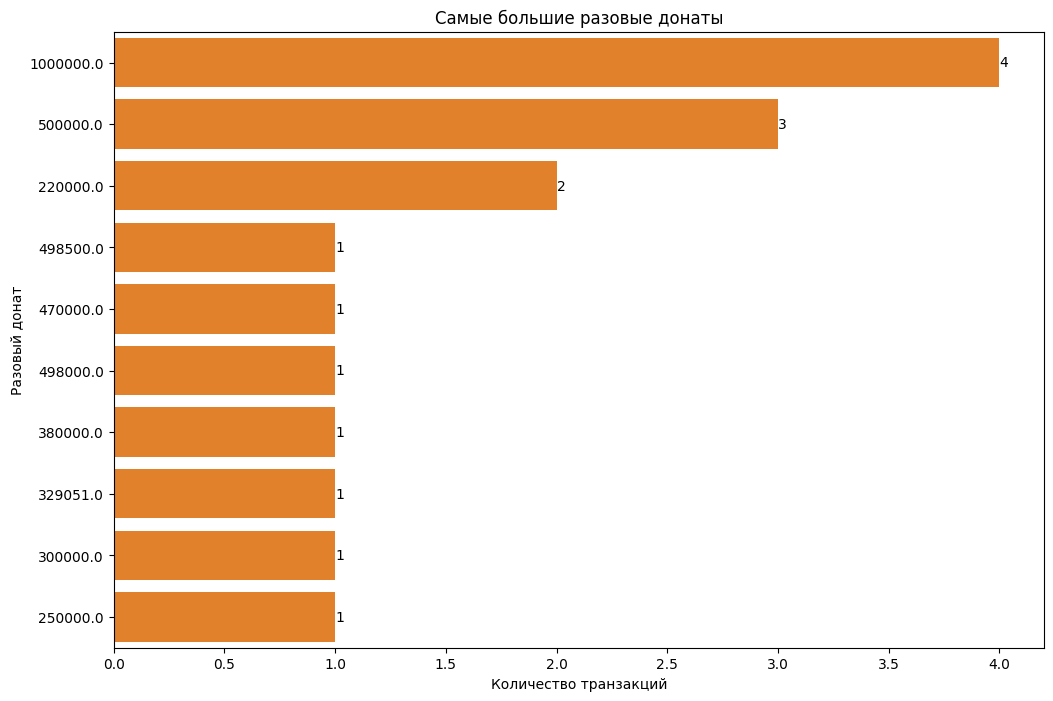

In [73]:
plt.figure(figsize=(12,8))
dd = tranz.query('comp_id == 0 and donate > 200000')['donate'].value_counts().head(10).reset_index()
dd['donate'] = dd['donate'].astype('str')
ax = sns.barplot(x=dd['count'], y=dd['donate'], color='tab:orange')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')

plt.title('Самые большие разовые донаты')
plt.ylabel('Разовый донат')
plt.xlabel('Количество транзакций')
plt.show()

## Самые щедрые пользователи

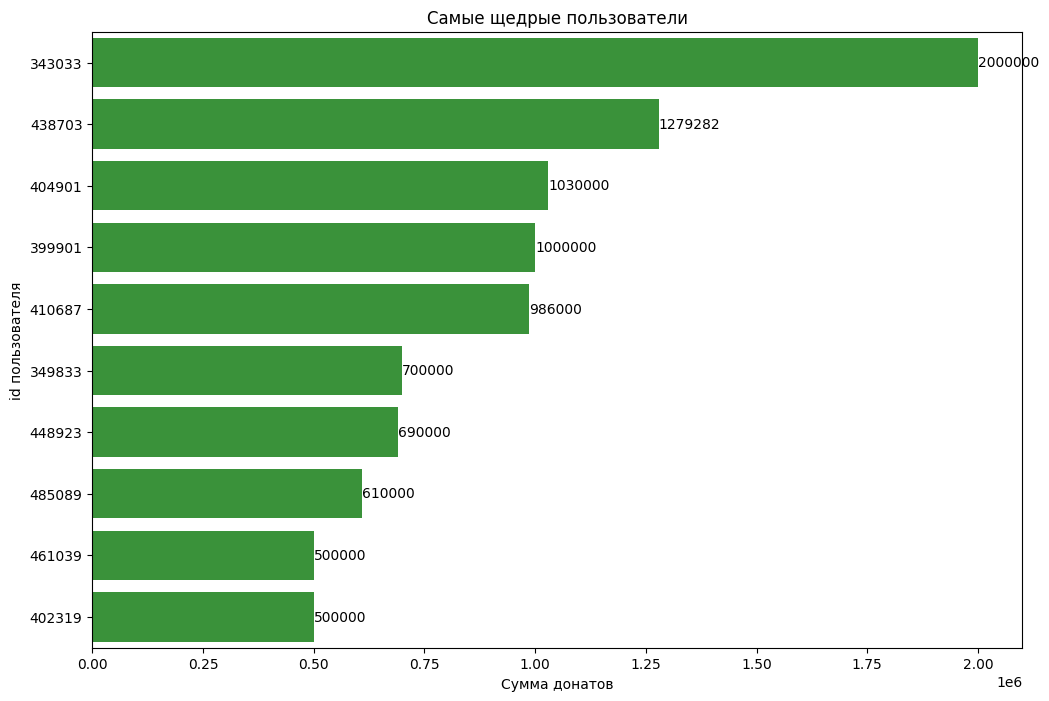

In [74]:
plt.figure(figsize=(12,8))
dd = tranz.query('comp_id == 0').groupby('user_id')['donate'].sum().sort_values().tail(10)[::-1].reset_index()
dd['user_id'] = dd['user_id'].astype('str')
ax = sns.barplot(x=dd['donate'], y=dd['user_id'], color='tab:green')
ax.bar_label(ax.containers[0], fmt='%d', fontsize=10, label_type='edge', color='black')

plt.title('Самые щедрые пользователи')
plt.ylabel('id пользователя')
plt.xlabel('Сумма донатов')
plt.show()

**Промежуточные итоги:**

Вывели наиболее часто встречающиеся суммы донатов, количество транзакций на человека. Так, самая частая сумма пожертвования — 500 р., а на одного человека в подавляющем большинстве случаев приходится по 1 транзакции.

# Портрет пользователей

Портрет пользователей описывают колонки Гендер, Город, Регион, Тип донатора, ВИД и ЭН. Оценим полноту данных в этих колонках

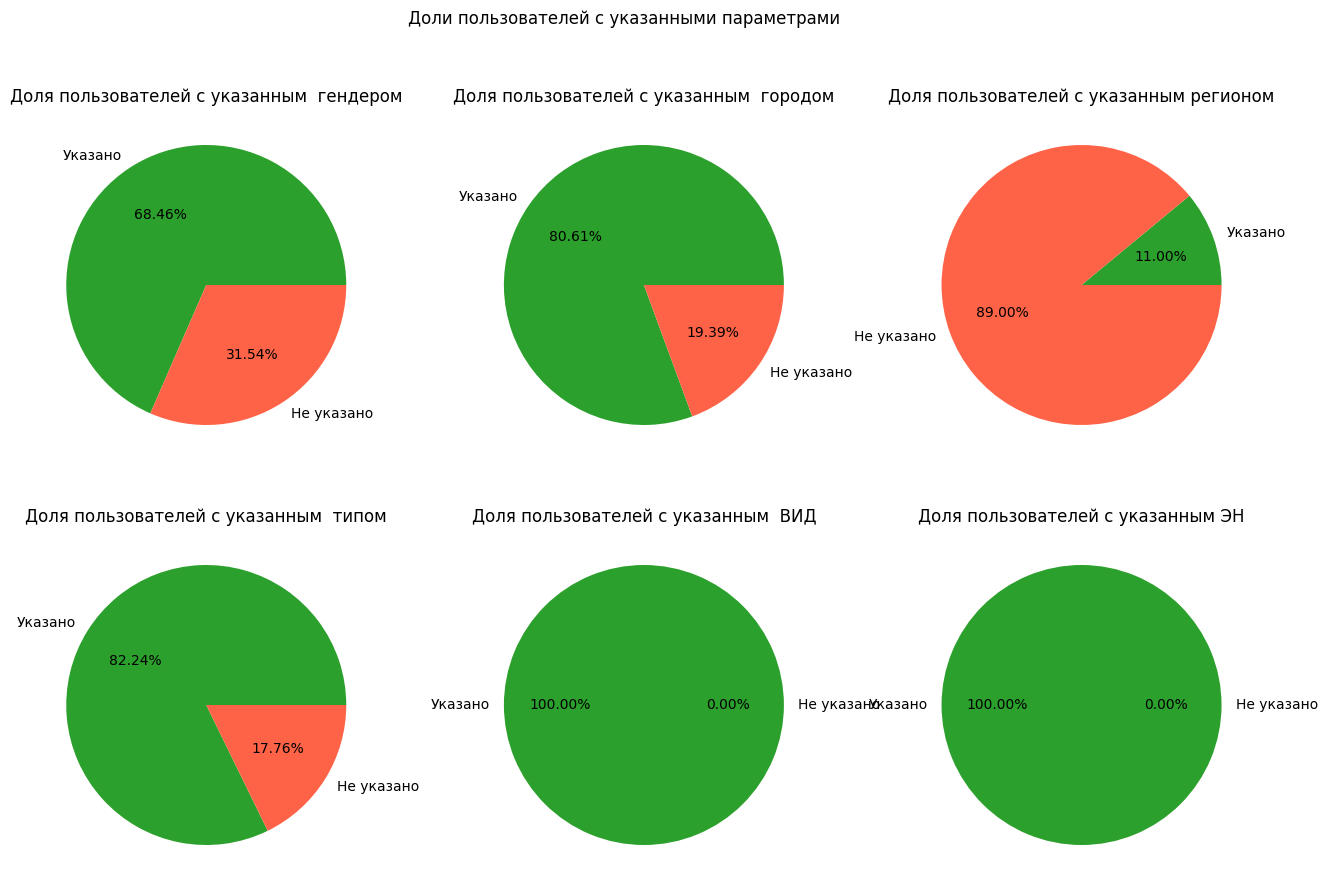

In [75]:
f, ax = plt.subplots(2, 3, figsize=(16,10))

dd = tranz.query('gender == "Не указано"')['user_id'].nunique()
ax[0, 0].pie([user_all - dd, dd],  labels = ['Указано', 'Не указано'], colors=['tab:green', 'tomato'], autopct=lambda p : '{:.2f}%'.format(p))
ax[0, 0].set_title('Доля пользователей с указанным  гендером')

dd = tranz.query('city == "Не указано"')['user_id'].nunique()
ax[0, 1].pie([user_all - dd, dd], labels = ['Указано', 'Не указано'], colors=['tab:green', 'tomato'], autopct=lambda p : '{:.2f}%'.format(p))
ax[0, 1].set_title('Доля пользователей с указанным  городом')

dd = tranz.query('region == "Не указано"')['user_id'].nunique()
ax[0, 2].pie([user_all - dd, dd], labels = ['Указано', 'Не указано'], colors=['tab:green', 'tomato'], autopct=lambda p : '{:.2f}%'.format(p))
ax[0, 2].set_title('Доля пользователей с указанным регионом')

dd = tranz.query('donor_type == "Не указано"')['user_id'].nunique()
ax[1, 0].pie([user_all - dd, dd],  labels = ['Указано', 'Не указано'], colors=['tab:green', 'tomato'], autopct=lambda p : '{:.2f}%'.format(p))
ax[1, 0].set_title('Доля пользователей с указанным  типом')

dd = tranz.query('vid == "Не указано"')['user_id'].nunique()
ax[1, 1].pie([user_all - dd, dd], labels = ['Указано', 'Не указано'], colors=['tab:green', 'tomato'], autopct=lambda p : '{:.2f}%'.format(p))
ax[1, 1].set_title('Доля пользователей с указанным  ВИД')

dd = tranz.query('en == "Не указано"')['user_id'].nunique()
ax[1, 2].pie([user_all - dd, dd], labels = ['Указано', 'Не указано'], colors=['tab:green', 'tomato'], autopct=lambda p : '{:.2f}%'.format(p))
ax[1, 2].set_title('Доля пользователей с указанным ЭН')



plt.suptitle('Доли пользователей с указанными параметрами')
plt.show()

В ключевых колонках достаточно много пропусков, но все же представление о донаторах составить можно.

## Гендерное распределение

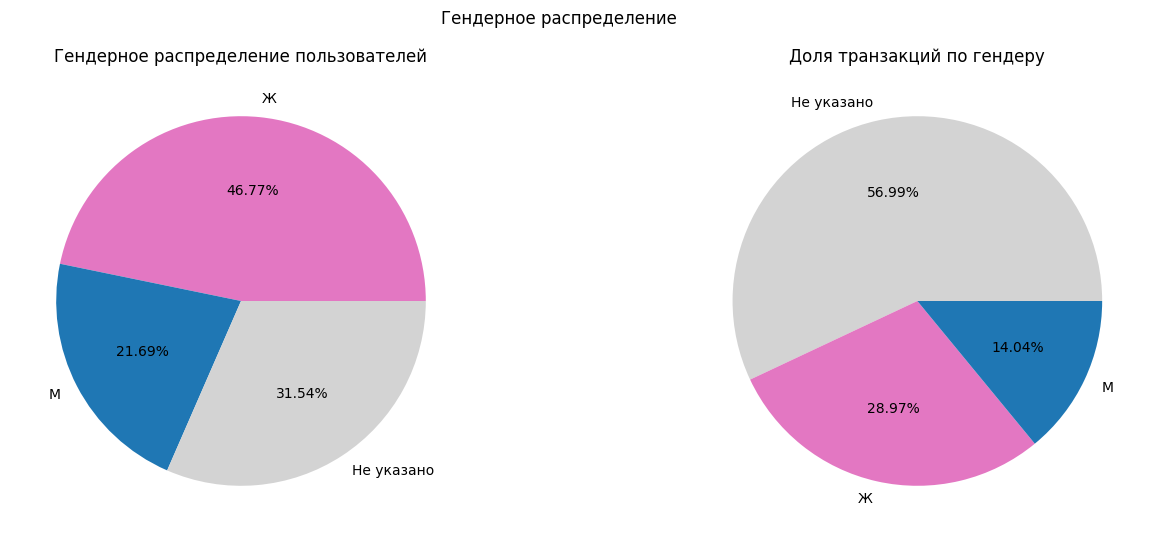

In [76]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
dd = tranz.groupby('gender')['user_id'].nunique()
ax[0].pie(x = dd.values, labels = dd.index, colors=['tab:pink', 'tab:blue', 'lightgray'],  autopct=lambda p : '{:.2f}%'.format(p))
dd = tranz['gender'].value_counts()
ax[0].set_title('Гендерное распределение пользователей')
ax[1].pie(x = dd.values, labels = dd.index, colors=['lightgray', 'tab:pink', 'tab:blue'],  autopct=lambda p : '{:.2f}%'.format(p))
ax[1].set_title('Доля транзакций по гендеру')
plt.suptitle('Гендерное распределение')
plt.show()

Больше половины донатов приходит от людей, которые не пожелали давать подробную информацию о себе.

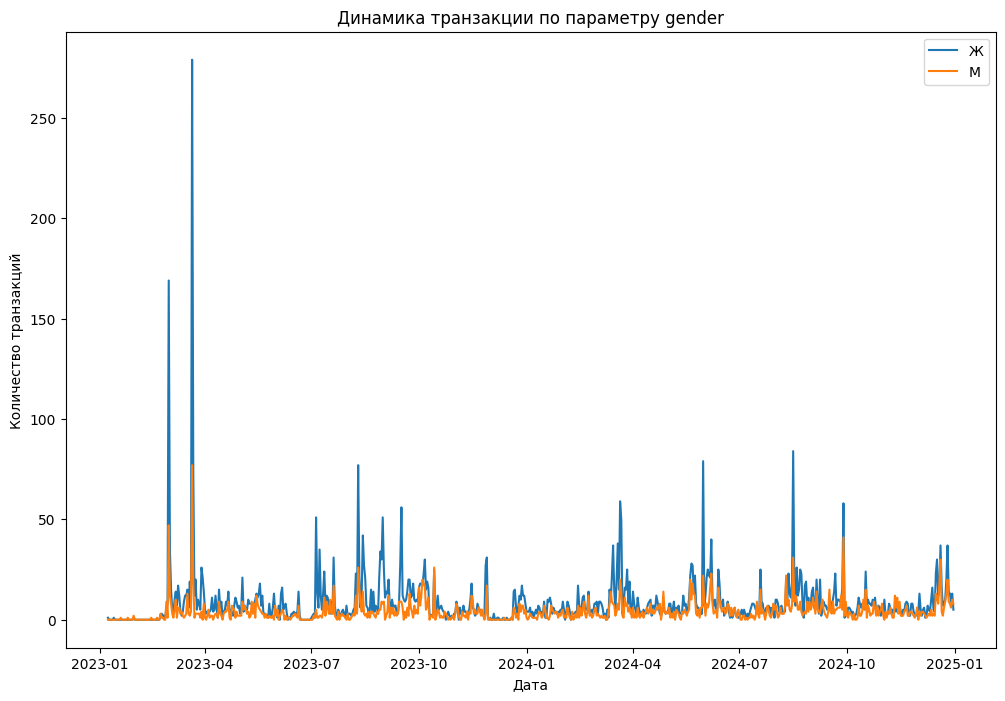

In [77]:
graf_dynamik_by_par(tranz.query('gender != "Не указано"'), 'gender', 5)

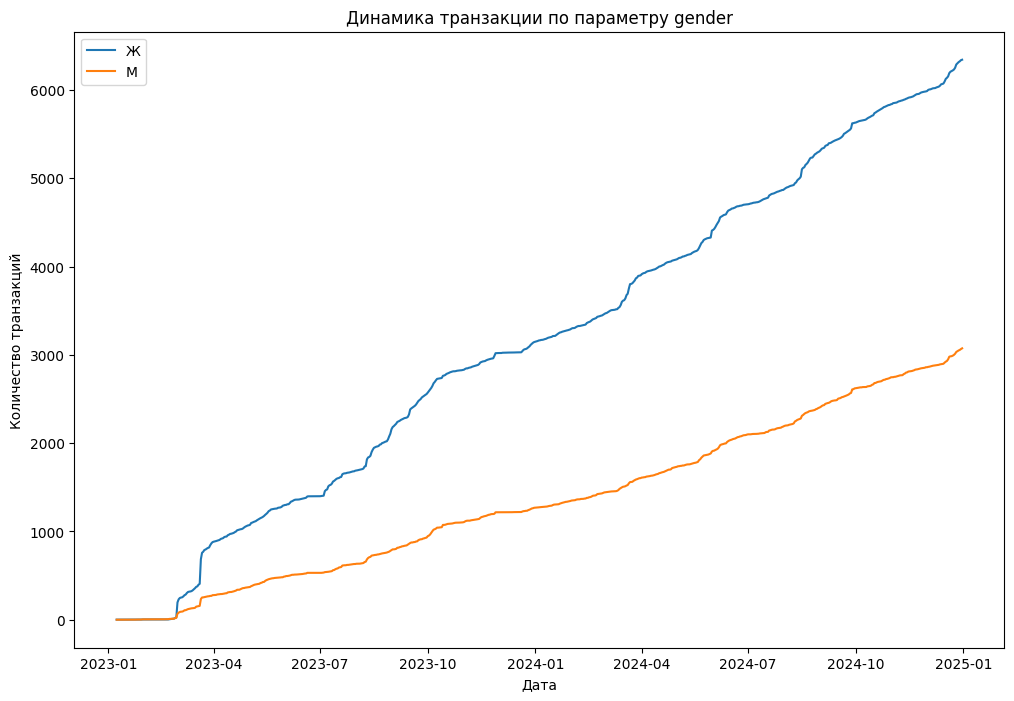

In [78]:
graf_dynamik_by_par(tranz.query('gender != "Не указано"'), 'gender', 5, 'cumsum')

Различие между донаторами мужчинами и женщинами только в количестве. Даты пиков пожертвований совпадают.

## География донаторов

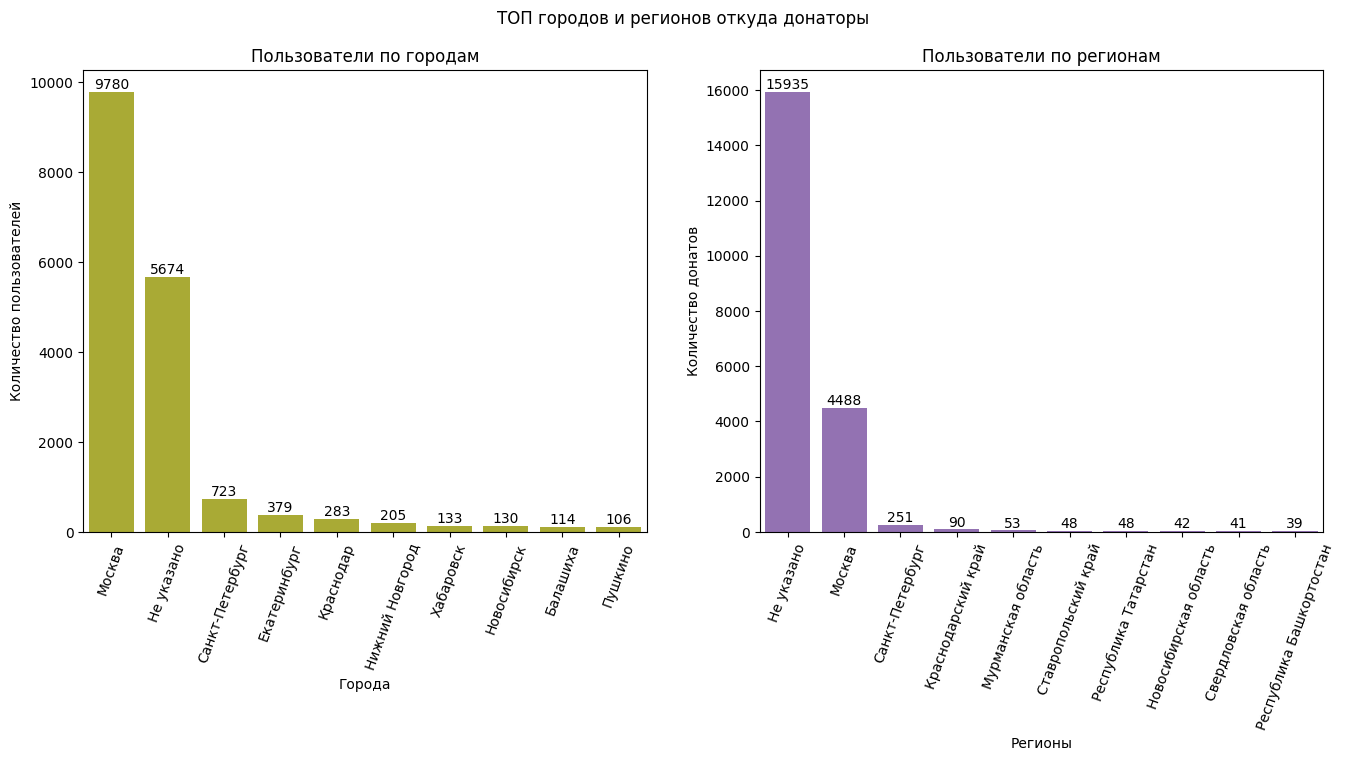

In [79]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
dd = tranz['city'].value_counts()[0:10]

sns.barplot(y=dd, x=dd.index, color='tab:olive', ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10, label_type='edge', color='black')
ax[0].tick_params(axis='x', labelrotation = 70)

ax[0].set_title('Пользователи по городам')
ax[0].set_xlabel('Города')
ax[0].set_ylabel('Количество пользователей')

dd = tranz['region'].value_counts()[0:10]
sns.barplot(y=dd, x=dd.index, color='tab:purple', ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10, label_type='edge', color='black')
ax[1].set_title('Пользователи по регионам')
ax[1].set_xlabel('Регионы')
ax[1].set_ylabel('Количество донатов')
ax[1].tick_params(axis='x', labelrotation = 70)

plt.suptitle('ТОП городов и регионов откуда донаторы')
plt.show()

Подавляющая масса донаторов из Москвы. Остальные города имеют либо исчезающе малое количество представителей. Стоит отметить и большое количество транзакций без указанного города.

## Доля ВИД пользователей

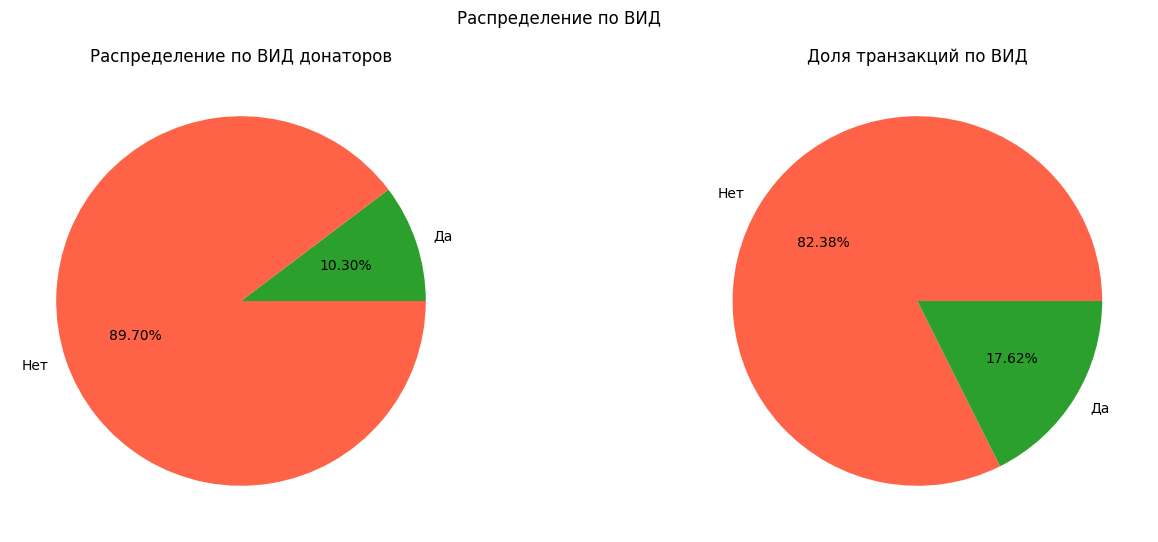

In [80]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
dd = tranz.groupby('vid')['user_id'].nunique()
ax[0].pie(x = dd.values, labels = dd.index, colors=['tab:green', 'tomato'],  autopct=lambda p : '{:.2f}%'.format(p))
ax[0].set_title('Распределение по ВИД донаторов')

dd = tranz['vid'].value_counts()
ax[1].pie(x = dd.values, labels = dd.index, colors=['tomato', 'tab:green'],  autopct=lambda p : '{:.2f}%'.format(p))
ax[1].set_title('Доля транзакций по ВИД')

plt.suptitle('Распределение по ВИД')
plt.show()

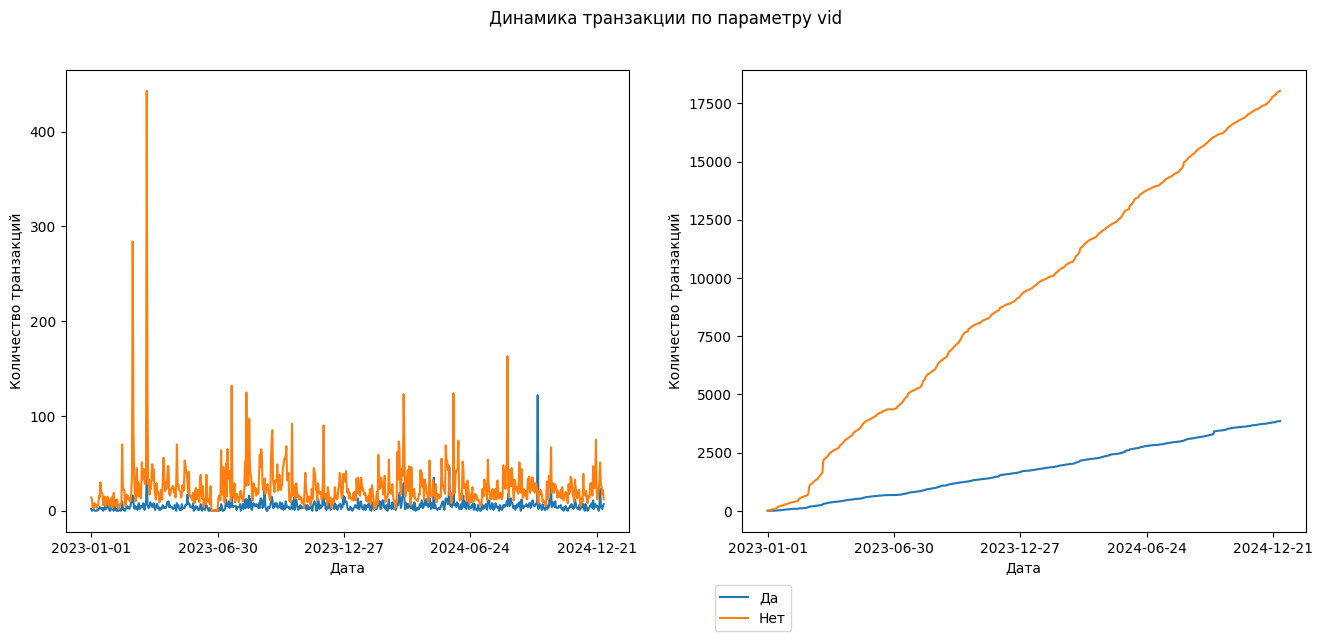

In [81]:
graf_dynamik_by_par_subplot(tranz, 'vid', 5)

Неизвестно, как расшифровывается ВИД, но донатов с таким признаком достаточно много.

## Доля ЭН пользователей

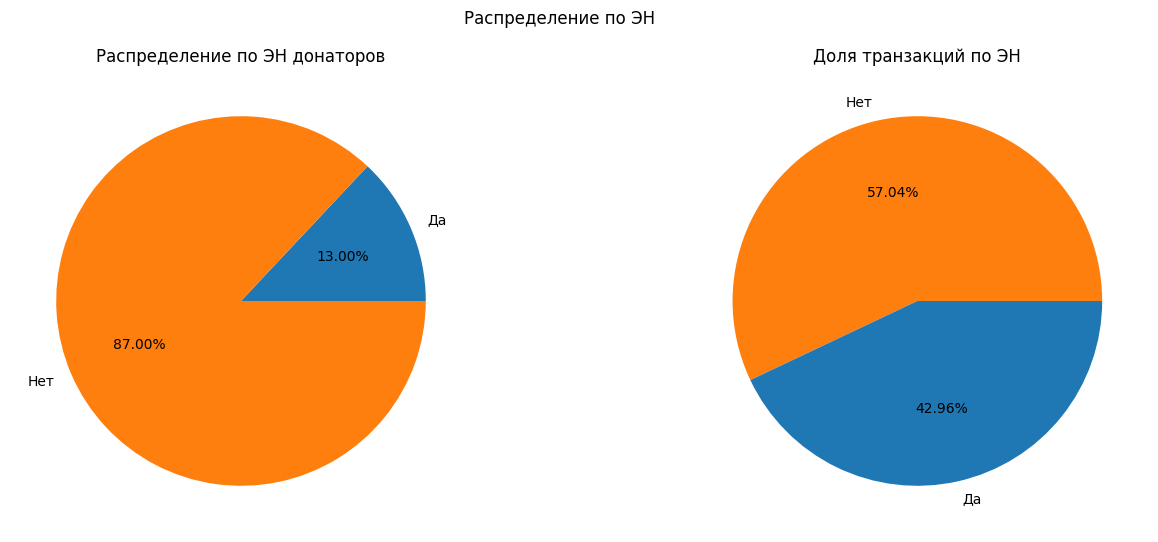

In [82]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
dd = tranz.groupby('en')['user_id'].nunique()
ax[0].pie(x = dd.values, labels = dd.index, colors=['tab:blue', 'tab:orange'],  autopct=lambda p : '{:.2f}%'.format(p))
ax[0].set_title('Распределение по ЭН донаторов')

dd = tranz['en'].value_counts()
ax[1].pie(x = dd.values, labels = dd.index, colors=['tab:orange', 'tab:blue'],  autopct=lambda p : '{:.2f}%'.format(p))
ax[1].set_title('Доля транзакций по ЭН')

plt.suptitle('Распределение по ЭН')
plt.show()

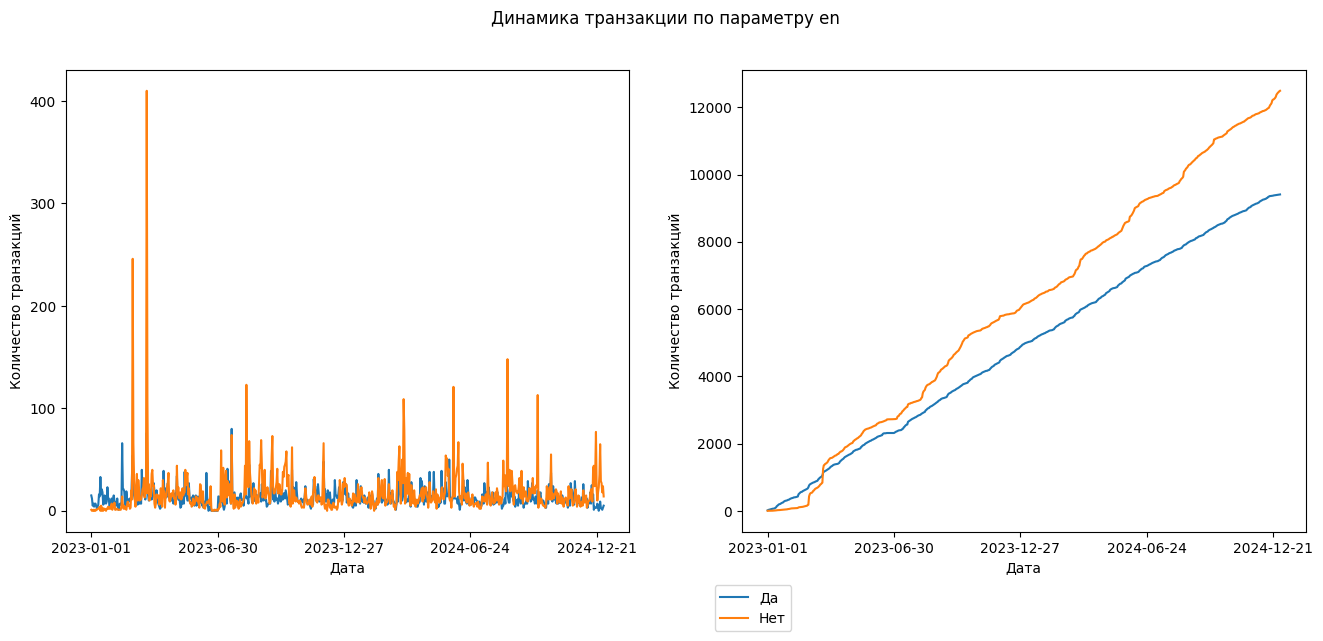

In [83]:
graf_dynamik_by_par_subplot(tranz, 'en', 5)

Неизвестно, как расшифровывается ЭН, но донатов с таким признаком и без - примерно одинаковое количество.

## Типы доноров

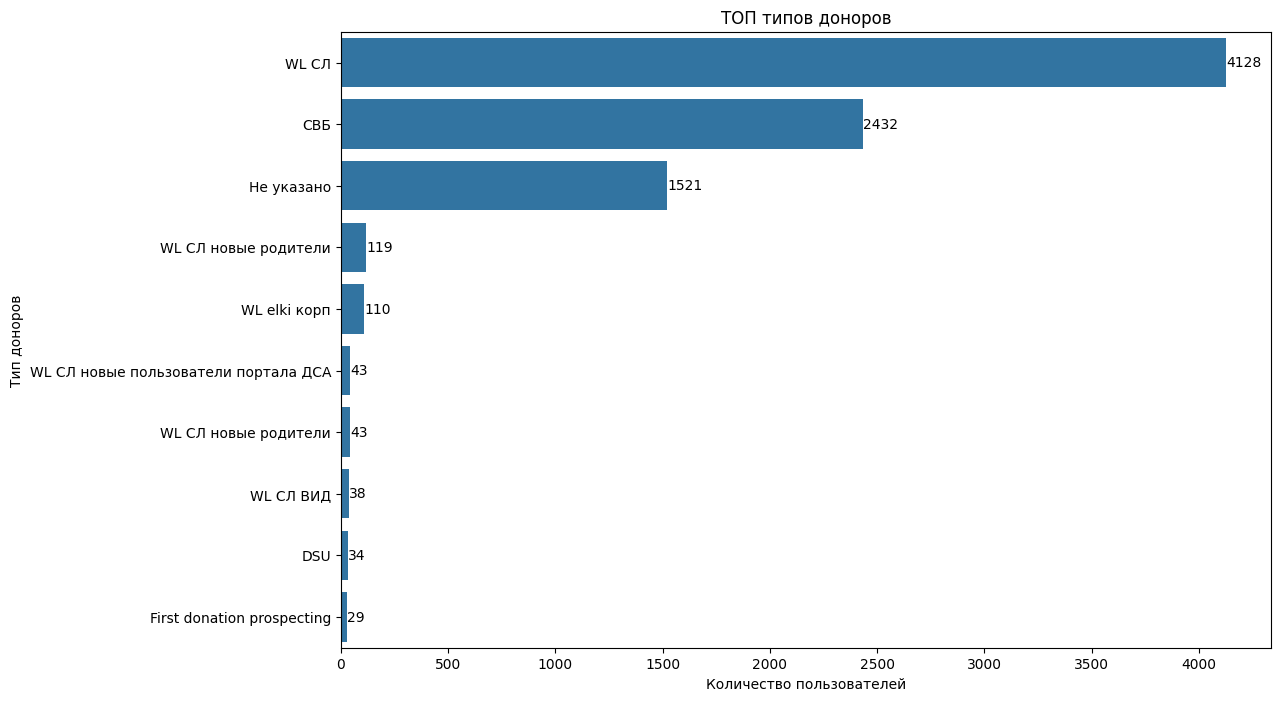

In [84]:
fig = plt.figure(figsize=(12, 8))
dd = tranz.groupby('donor_type')['user_id'].nunique().sort_values().tail(10)[::-1]
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')
plt.title('ТОП типов доноров')
plt.xlabel('Количество пользователей')
plt.ylabel('Тип доноров')
plt.show()

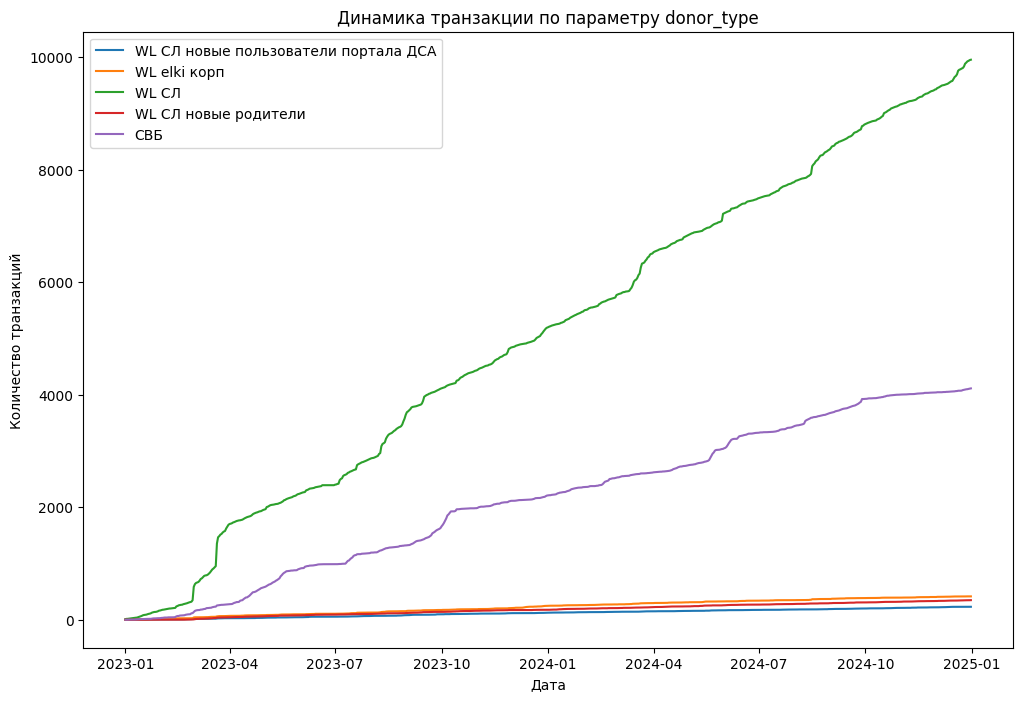

In [85]:
graf_dynamik_by_par(tranz.query('donor_type != "Не указано"'), 'donor_type', 5, 'cumsum')

Значимое количество транзакций поступило от пользователей с признаком "WL СЛ новые пользователи портала ДСА" и "СВБ"

**Промежуточные итоги:**

Чаще в фонд жертвуют женщины и жители Москвы. Также среди донаторов значимая часть кодируется как WL и СВБ — 4100 и 2400 человек соответственно, а также имеет отношение к ВИД и ЭН — 10 и 13 процентов соответственно.

In [86]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-16 20:37:30.613062+04:00
 От начала рассчета прошло 0:00:35.852002


# Первые пожертвования

Формируем таблицу первых пожертвований — это параметры первых транзакций пользователей в анализируемый период.

In [87]:
#К таблице пользователей слева присоединяем записи из таблицы транзакций по паре ключей - [user_id, first_date]
first_donate = pd.merge(user_table,tranz,  how='left',\
                        left_on=['user_id', 'first_date'],\
                        right_on=['user_id', 'date'])\
                         [['user_id', 'first_date', 'code', 'comment', 'action']].sort_values(by='first_date')

### Коды первых пожертвований

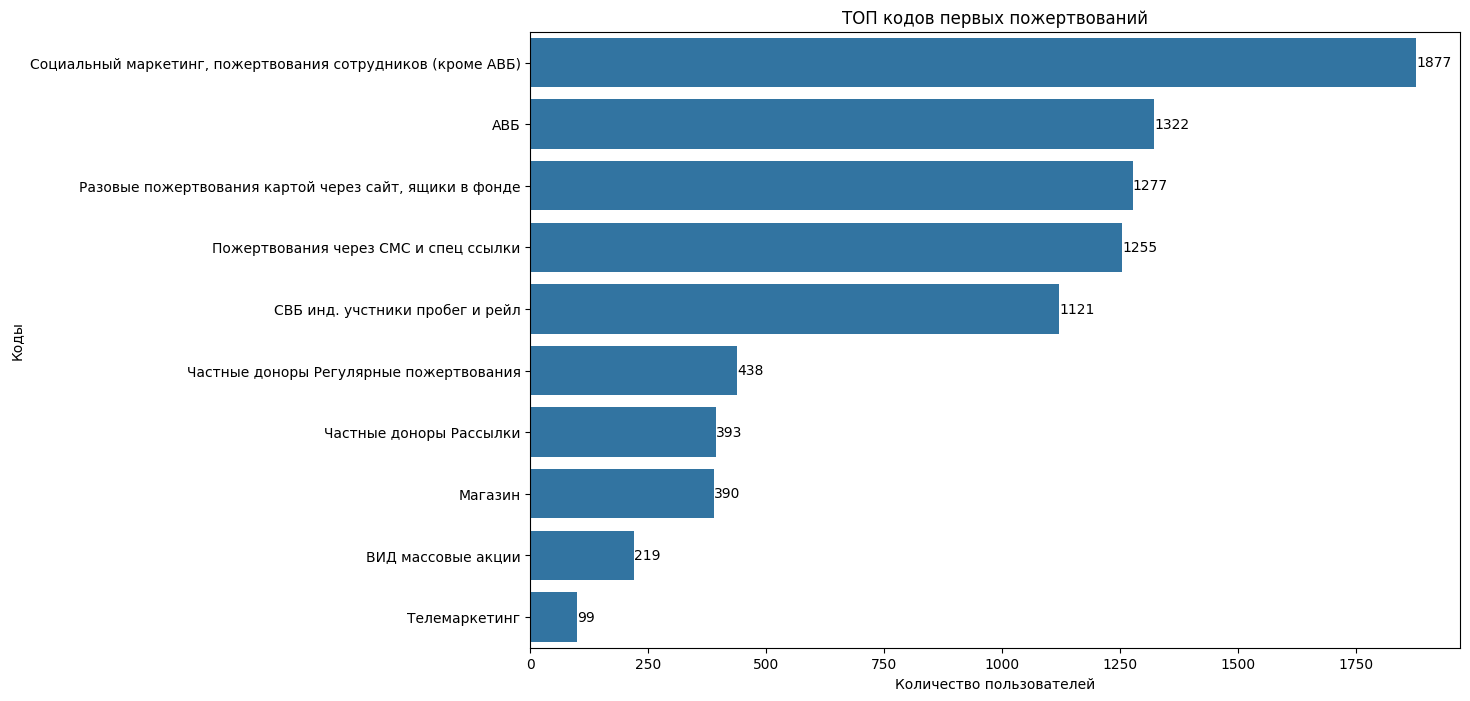

In [88]:
fig = plt.figure(figsize=(12, 8))
dd = first_donate['code'].value_counts().head(10)
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')
plt.title('ТОП кодов первых пожертвований')
plt.xlabel('Количество пользователей')
plt.ylabel('Коды')
plt.show()

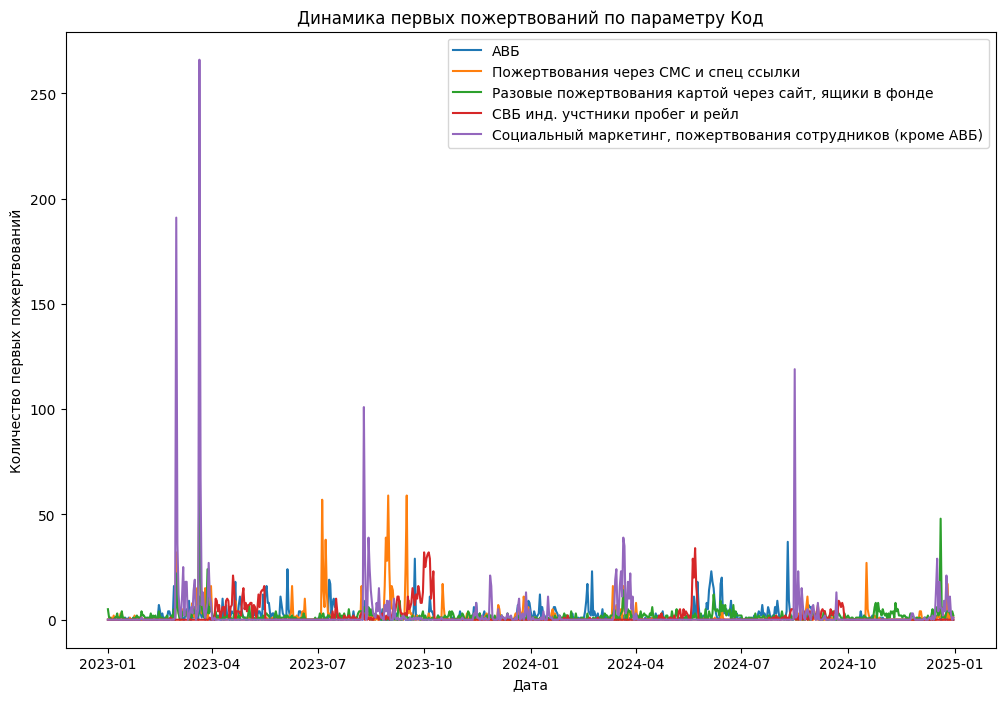

In [89]:
graf_dynamik_first_donate_by_col(first_donate, 'code', t=5)

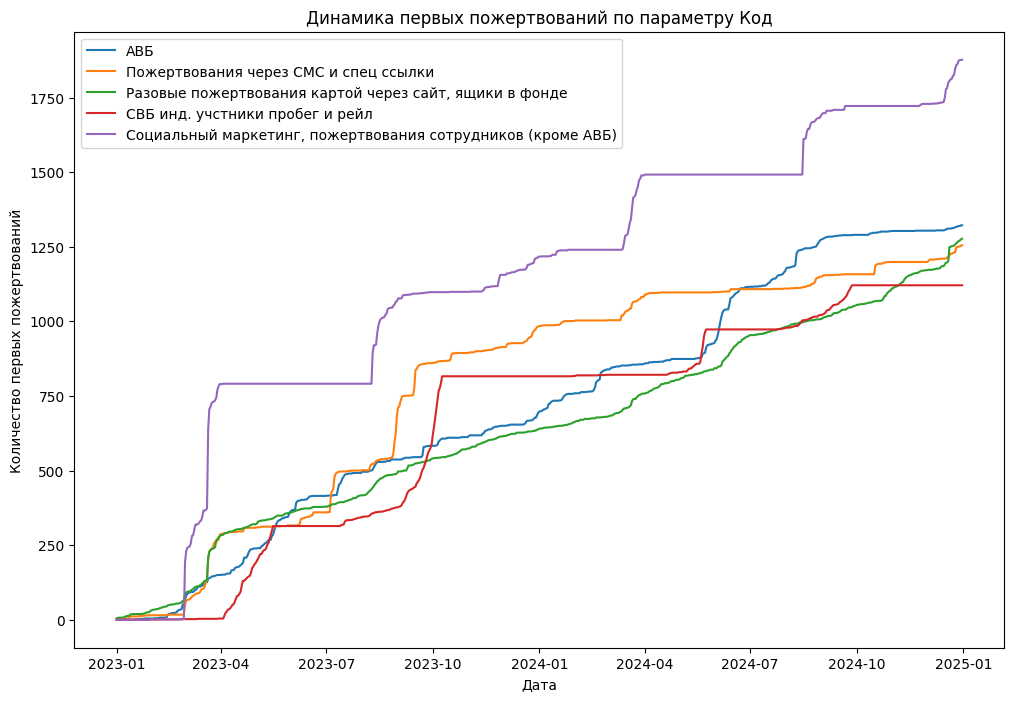

In [90]:
graf_dynamik_first_donate_by_col(first_donate, 'code', t=5, type='cumsum')

Больше всего новые пользователи приходят по платежам с кодом «Социальный маркетинг. Пожертвования сотрудников». Затем идут АВБ, разовые пожертвования, пожертвования через СМС и спецссылки, СВБ.

Таблица дат пиков кодов

In [91]:
code_piks = first_donate.groupby(['first_date', 'code'], as_index=False)['user_id'].count()\
    .query('user_id > 50').rename(columns = {'user_id' : 'users_count'})
code_piks

first_date                                                         code  \
176  2023-03-01  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
294  2023-03-21                        Пожертвования через СМС и спец ссылки   
295  2023-03-21       Разовые пожертвования картой через сайт, ящики в фонде   
296  2023-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
303  2023-03-22  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
637  2023-07-05                        Пожертвования через СМС и спец ссылки   
695  2023-07-20                                      Частные доноры Рассылки   
771  2023-08-10  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
863  2023-08-31                        Пожертвования через СМС и спец ссылки   
926  2023-09-16                        Пожертвования через СМС и спец ссылки   
1718 2024-05-31                                           ВИД массовые акции   
1935 2024-08-16  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
2091 2024-09-28                                                Телемаркетинг   

      users_count  
176           191  
294            69  
295            74  
296           266  
303            67  
637            57  
695            52  
771           101  
863            59  
926            59  
1718           98  
1935          119  
2091           56

### Комменты первых пожертвований

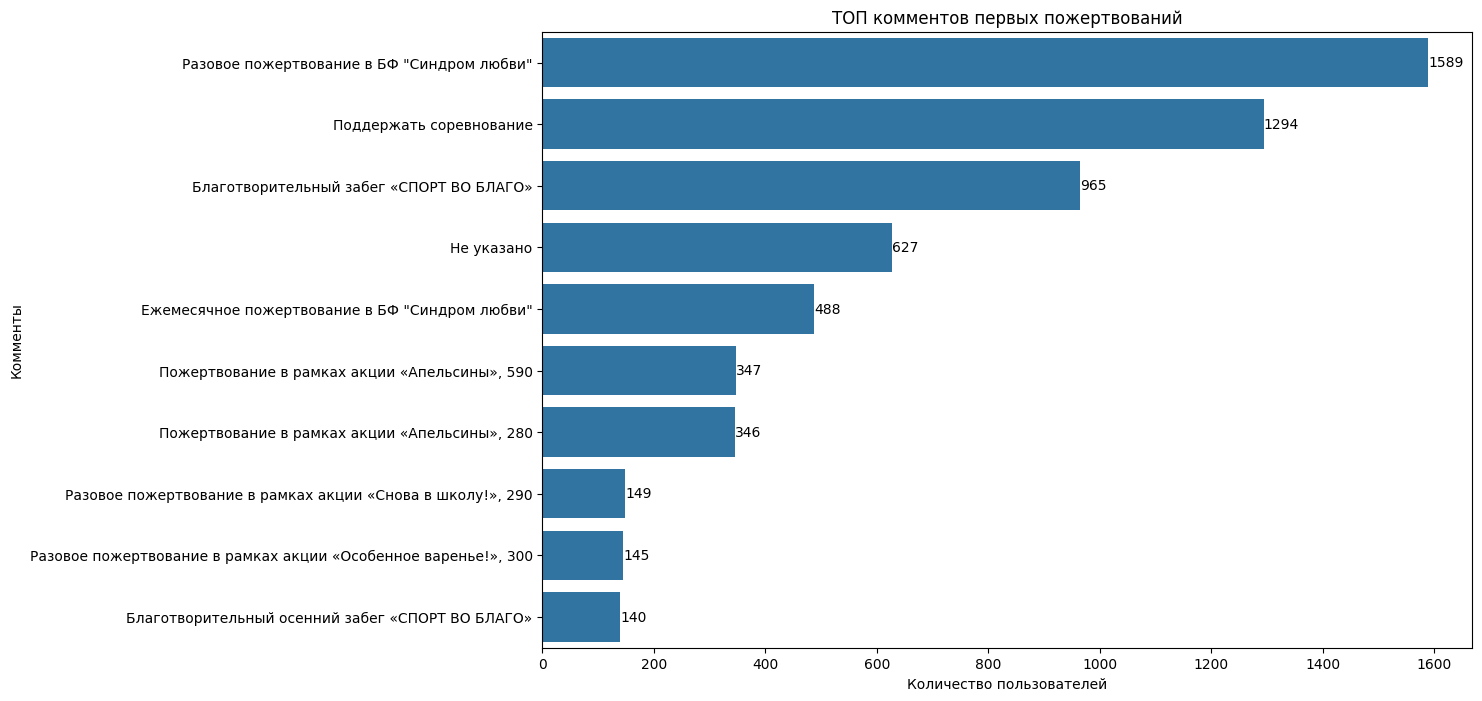

In [92]:
fig = plt.figure(figsize=(12, 8))
dd = first_donate['comment'].value_counts().head(10)
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')
plt.title('ТОП комментов первых пожертвований')
plt.xlabel('Количество пользователей')
plt.ylabel('Комменты')
plt.show()

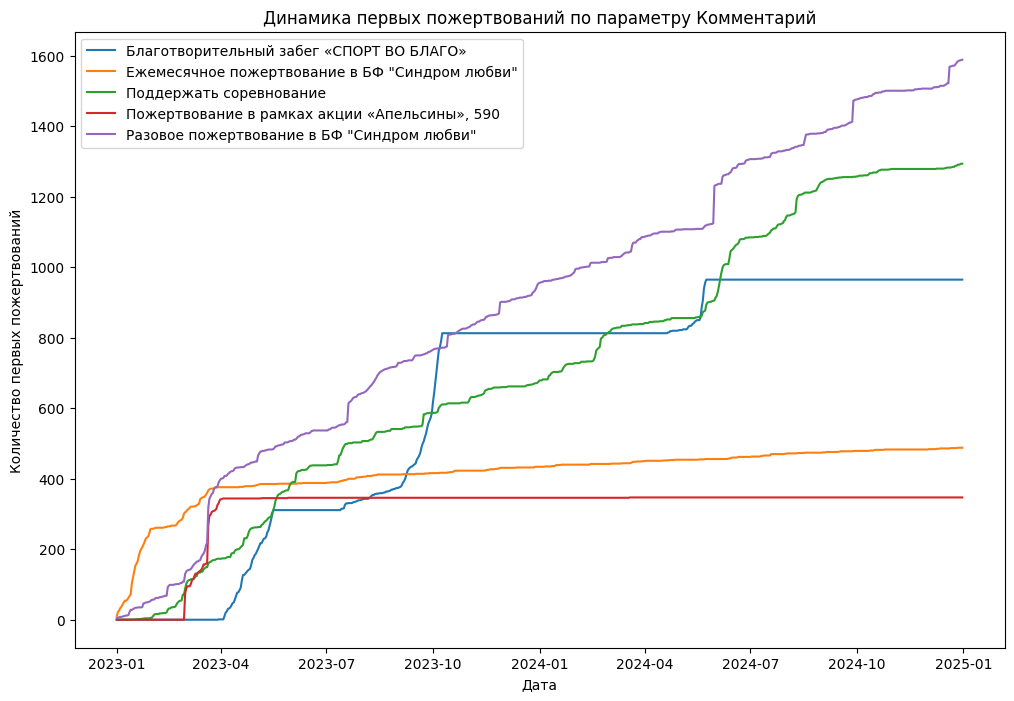

In [93]:
graf_dynamik_first_donate_by_col(first_donate.query('comment != "Не указано"'), 'comment', t=5, type='cumsum')

Донаты с комментариями «Разовое пожертвование», «Ежемесячное пожертвование» и «Поддержать соревнования» поступают регулярно, а донаты с другими кодами приходят «сезонно», а потом исчезают на долгое время.

Таблица дат пиков комментариев

In [94]:
comment_piks = first_donate.groupby(['first_date', 'comment'], as_index=False)['user_id'].count()\
    .query('user_id > 50').rename(columns = {'user_id' : 'users_count'})
comment_piks

first_date  \
176  2023-03-01   
178  2023-03-01   
324  2023-03-21   
328  2023-03-21   
329  2023-03-21   
695  2023-07-05   
761  2023-07-20   
1129 2023-09-16   
2079 2024-05-31   
2310 2024-08-16   
2505 2024-09-28   

                                                                      comment  \
176                             Пожертвование в рамках акции «Апельсины», 280   
178                             Пожертвование в рамках акции «Апельсины», 590   
324                             Пожертвование в рамках акции «Апельсины», 280   
328                             Пожертвование в рамках акции «Апельсины», 590   
329                                Разовое пожертвование в БФ "Синдром любви"   
695                                    Разовое пожертвование "День рождения "   
761                                Разовое пожертвование в БФ "Синдром любви"   
1129                     Разовое пожертвование "Академия успеха Атоми в Сочи"   
2079                               Разовое пожертвование в БФ "Синдром любви"   
2310  Разовое пожертвование в рамках акции «Школа начинается с перемен!», 280   
2505                               Разовое пожертвование в БФ "Синдром любви"   

      users_count  
176           102  
178            74  
324           116  
328           108  
329           100  
695            55  
761            53  
1129           54  
2079          106  
2310           69  
2505           60

### Метки в ссылках первых пожертвований

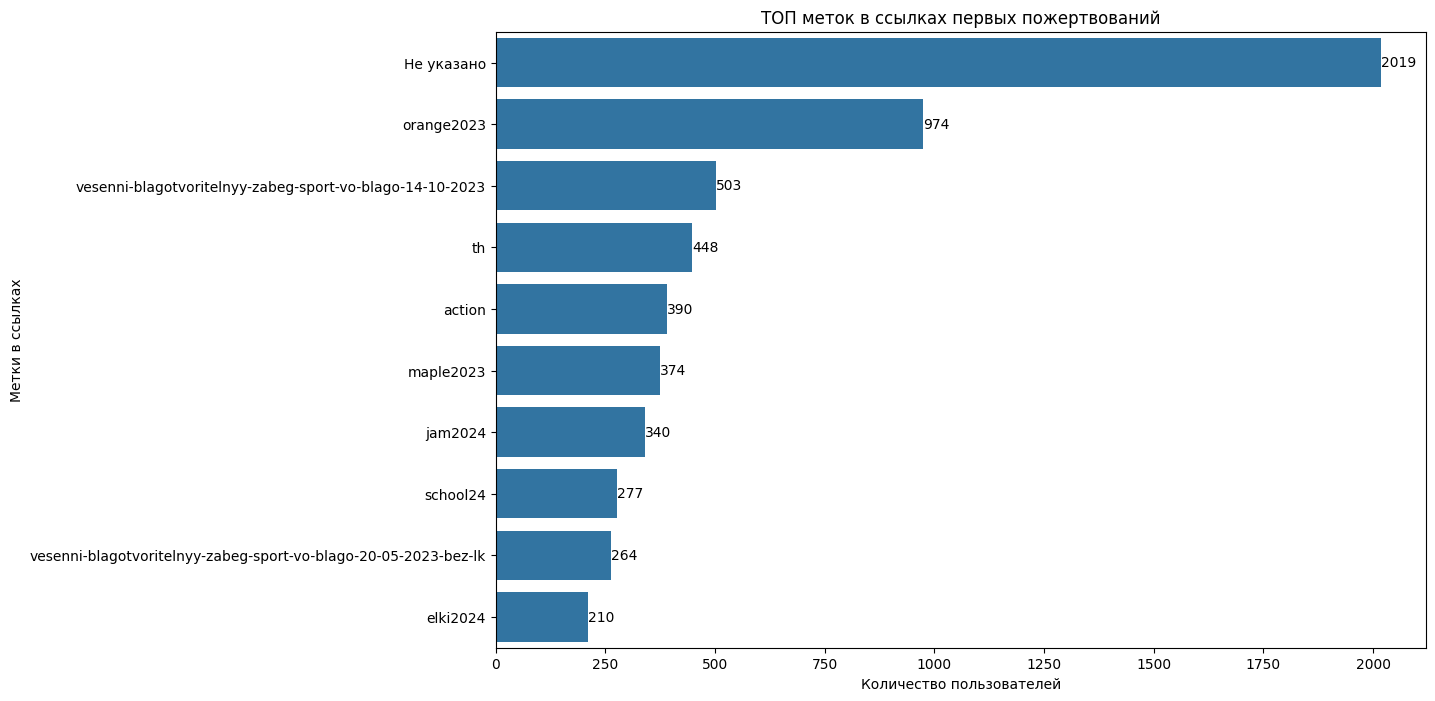

In [95]:
fig = plt.figure(figsize=(12, 8))
dd = first_donate['action'].value_counts().head(10)
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')
plt.title('ТОП меток в ссылках первых пожертвований')
plt.xlabel('Количество пользователей')
plt.ylabel('Метки в ссылках')
plt.show()

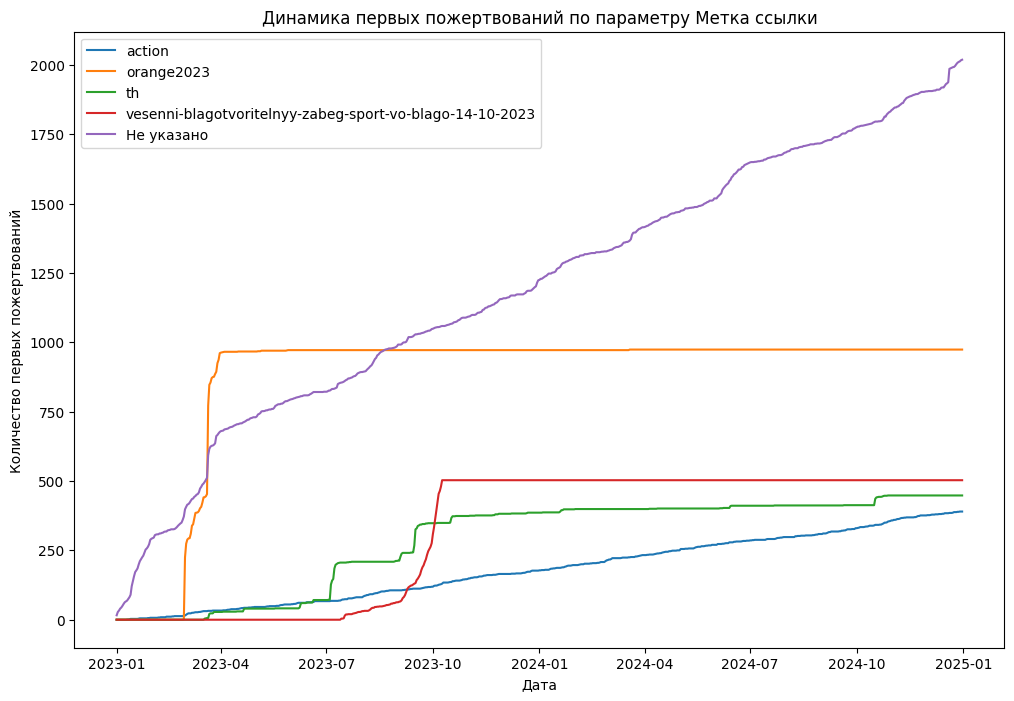

In [96]:
graf_dynamik_first_donate_by_col(first_donate, 'action', t=5, type='cumsum')

Донаты с метками в ссылках практически все проходят резкими скачками, после чего исчезают.

Таблица дат пиков иеток из ссылок

In [97]:
action_piks = first_donate.groupby(['first_date', 'action'], as_index=False)['user_id'].count()\
    .query('user_id > 50').rename(columns = {'user_id' : 'users_count'})
action_piks

first_date                    action  users_count
134  2023-03-01                orange2023          223
238  2023-03-21                orange2023          319
239  2023-03-21                Не указано           81
246  2023-03-22                orange2023           75
610  2023-07-05                        th           55
668  2023-07-20              EN_needs7.23           54
740  2023-08-10                 maple2023          102
826  2023-08-31                  deti2023           57
896  2023-09-16                        th           58
1455 2024-03-21                   jam2024           55
1645 2024-05-31  MA_charityfair_gymnasium           98
1881 2024-08-16                  school24          120

## Общая таблица параметров наиболее частых в первых пожертвованиях

In [98]:
dd = pd.merge(code_piks[['first_date', 'code']], comment_piks[['first_date', 'comment']], how='outer', on = 'first_date')
dd = pd.merge(dd, action_piks[['first_date', 'action']], how='outer', on = 'first_date')
dd = dd.fillna('')

dd['code'] = dd['code'].apply(lambda x : str(x) + ';',1)
dd['comment'] = dd['comment'].apply(lambda x : str(x) + ';')
dd['action'] = dd['action'].apply(lambda x : str(x) + ';')
dd = dd.groupby('first_date').sum()
dd['code'] = dd['code'].apply(lambda x : '/ '.join(set(x.split(';'))))
dd['comment'] = dd['comment'].apply(lambda x : '/ '.join(set(x.split(';'))))
dd['action'] = dd['action'].apply(lambda x : '/ '.join(set(x.split(';'))))

dd

code  \
first_date                                                                                                                                                                 
2023-03-01                                                                                                 / Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
2023-03-21  / Разовые пожертвования картой через сайт, ящики в фонде/ Социальный маркетинг, пожертвования сотрудников (кроме АВБ)/ Пожертвования через СМС и спец ссылки   
2023-03-22                                                                                                 / Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
2023-07-05                                                                                                                       / Пожертвования через СМС и спец ссылки   
2023-07-20                                                                                                                                     / Частные доноры Рассылки   
2023-08-10                                                                                                 / Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
2023-08-31                                                                                                                       / Пожертвования через СМС и спец ссылки   
2023-09-16                                                                                                                       / Пожертвования через СМС и спец ссылки   
2024-03-21                                                                                                                                                                 
2024-05-31                                                                                                                                          / ВИД массовые акции   
2024-08-16                                                                                                 / Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
2024-09-28                                                                                                                                               / Телемаркетинг   

                                                                                                                                               comment  \
first_date                                                                                                                                               
2023-03-01                                              / Пожертвование в рамках акции «Апельсины», 590/ Пожертвование в рамках акции «Апельсины», 280   
2023-03-21  / Пожертвование в рамках акции «Апельсины», 590/ Разовое пожертвование в БФ "Синдром любви"/ Пожертвование в рамках акции «Апельсины», 280   
2023-03-22                                                                                                                                               
2023-07-05                                                                                                    / Разовое пожертвование "День рождения "   
2023-07-20                                                                                                / Разовое пожертвование в БФ "Синдром любви"   
2023-08-10                                                                                                                                               
2023-08-31                                                                                                                                               
2023-09-16                                                                                      / Разовое пожертвование "Академия успеха Атоми в Сочи"   
2024-03-21                                                                                                                                               
2024-05-31                                                   

**Промежуточные итоги:**

Провели аналогичную сегментацию транзакций и пользователей только по первым пожертвованиям пользователей. Значения ТОПов в сегментации и «пики» динамики должны соответствовать акциям / мероприятиям / рассылкам, которые привлекли наибольшее количество новых пользователей.

In [99]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-16 20:37:33.840888+04:00
 От начала рассчета прошло 0:00:39.079824


# RFM анализ

RFM-анализ — это метод сегментации клиентов на основе их поведения:

- R (Recency) — как давно клиент совершал покупку.
- F (Frequency) — как часто клиент совершает покупки.
- M (Monetary) — сколько денег клиент тратит.

Строим новую таблицу пользователей, без учета транзакций более 200000 рублей.

In [100]:
rfm_donate_lim = 200000
user_table_rfm = get_user_table(tranz.query('donate < @rfm_donate_lim'))
user_table_rfm.head(5)

user_id first_date  last_date  donate_sum  tr_count  first_month  \
0   333699 2023-08-25 2023-10-10     3000.00         3            8   
1   333801 2023-04-19 2023-04-19     2000.00         1            4   
2   333803 2023-12-08 2023-12-08      500.00         1           12   
3   333873 2023-06-09 2023-06-09     2000.00         1            6   
4   334671 2023-05-18 2023-05-18    70000.00         1            5   

   first_year  first_ym  day_on  month_on  oper_frec     type  day_last  
0        2023         8      46         2       1.50  Простой       448  
1        2023         4       0         1       1.00  Разовый       622  
2        2023        12       0         1       1.00  Разовый       389  
3        2023         6       0         1       1.00  Разовый       571  
4        2023         5       0         1       1.00  Разовый       593

Принцип выбора границы RFM не задан. Поэтому выберем границы рангов так, чтобы в них вошло сопоставимое количество пользователей. При этом, стоит учесть, что очевидные границы на 0.33 и 0.66 перцентилях для трех рангов не всегда удачно делят пользователей на три сопоставимые части. В некоторых случаях, границы стоит выбирать исходя из поставленной задачи, практики или логики бизнес-процессов.

Для выбора границ смотрим персентили 0.01, 0.25, 0.33, 0.5, 0.66, 0.75, 0.99.

In [101]:
user_table_rfm[['donate_sum', 'oper_frec', 'day_last']].quantile([0.01, 0.25, 0.33, 0.5, 0.66, 0.75, 0.99])

donate_sum  oper_frec  day_last
0.01       60.00       0.15      3.00
0.25      500.00       1.00    140.00
0.33      500.00       1.00    210.00
0.50     1000.00       1.00    348.00
0.66     2000.00       1.00    484.00
0.75     3000.00       1.00    535.00
0.99    60000.00       2.00    675.47

Ранги RFM 1 - хорошо, 2 - нормально, 3 - плохо

- Для границ рангов M (сумма донатов) возьмем 2000 и 750 рублей - как среднее между 1, 2 и 3 квантилями
- Для границ рангов R (давность последнего) возьмем 45 и 180 дней. 45 дней как 1,5 срока ежемесячного периода, а 180 как среднее между 1 и 2 квартилями.
- Для F (частота донатов в месяц) в третий ранг возьмем разовых пользователей, граница между 2 и 3 рангом будет 0.7 - чуть меньше средней частоты донатов без учета разовых жертводателей


In [102]:
user_table_rfm['R'] = user_table_rfm['day_last'].apply(lambda x: '1' if x < 45 else ('2' if x < 180 else '3'))

#user_table_rfm['F'] = user_table_rfm['oper_frec'].apply(lambda x: '1' if x > 2 else ('2' if x > 0.90 else '3'))
#модифицированный принцип разделения для границ F: третий ранг определяетя не по частоте, а по признаку разового донатора
user_table_rfm['F'] = user_table_rfm.apply(lambda row: '3' if row['day_on'] == 0 else ('2' if row['oper_frec'] < 0.8 else '1'), axis=1)

user_table_rfm['M'] = user_table_rfm['donate_sum'].apply(lambda x: '1' if x > 2000 else ('2' if x > 750 else '3'))
user_table_rfm['RFM'] = user_table_rfm['R'] + user_table_rfm['F'] + user_table_rfm['M']
user_table_rfm.head()

user_id first_date  last_date  donate_sum  tr_count  first_month  \
0   333699 2023-08-25 2023-10-10     3000.00         3            8   
1   333801 2023-04-19 2023-04-19     2000.00         1            4   
2   333803 2023-12-08 2023-12-08      500.00         1           12   
3   333873 2023-06-09 2023-06-09     2000.00         1            6   
4   334671 2023-05-18 2023-05-18    70000.00         1            5   

   first_year  first_ym  day_on  month_on  oper_frec     type  day_last  R  F  \
0        2023         8      46         2       1.50  Простой       448  3  1   
1        2023         4       0         1       1.00  Разовый       622  3  3   
2        2023        12       0         1       1.00  Разовый       389  3  3   
3        2023         6       0         1       1.00  Разовый       571  3  3   
4        2023         5       0         1       1.00  Разовый       593  3  3   

   M  RFM  
0  1  311  
1  2  332  
2  3  333  
3  2  332  
4  1  331

In [103]:
rfm_table = user_table_rfm.groupby(['R', 'F', 'M'], as_index = False).agg({'RFM' : 'first', 'tr_count' : ['count', 'sum'], 'donate_sum' : 'sum'})
rfm_table.columns = ['R', 'F', 'M', 'RFM', 'rfm_users', 'rfm_tr', 'rfm_sum']
rfm_table

R  F  M  RFM  rfm_users  rfm_tr    rfm_sum
0   1  1  1  111        368    7694 8860328.26
1   1  1  2  112         20     158   27231.00
2   1  1  3  113         16      70    5944.00
3   1  2  1  121        152    1112 2814391.00
4   1  2  2  122         43     182   64151.00
5   1  2  3  123         15      38    7940.00
6   1  3  1  131         84      93  637535.00
7   1  3  2  132        108     110  138370.00
8   1  3  3  133        180     181   71334.00
9   2  1  1  211         88     961 2343062.00
10  2  1  2  212         27      86   37548.00
11  2  1  3  213         22      54   10450.00
12  2  2  1  221        264    1259 2912925.00
13  2  2  2  222         82     234  115561.00
14  2  2  3  223         26      62   13407.00
15  2  3  1  231        244     271 1745191.00
16  2  3  2  232        180     195  248808.00
17  2  3  3  233        515     520  191757.00
18  3  1  1  311        176    1161 2110159.00
19  3  1  2  312        128     381  172882.00
20  3  1  3  313         47     132   19265.00
21  3  2  1  321        336    1030 3018984.20
22  3  2  2  322        179     435  242548.00
23  3  2  3  323         76     170   36747.00
24  3  3  1  331       1046    1099 8479469.39
25  3  3  2  332       1481    1514 2209101.99
26  3  3  3  333       2651    2676 1009326.00

In [104]:
rfm_table['R'] = rfm_table['R'].replace({'1':'1/Недавние', '2' : '2/Спящие', '3': '3/Уходящие'})
rfm_table['F'] = rfm_table['F'].replace({'1':'1/Частые', '2' : '2/Редкие', '3': '3/Разовые'})
rfm_table['M'] = rfm_table['M'].replace({'1':'1/Большой чек', '2' : '2/Средний чек', '3': '3/Малый чек'})
rfm_table['RF'] = rfm_table['R'] + rfm_table['F']

In [105]:
#rfm_table.to_csv('rfm_table.csv')

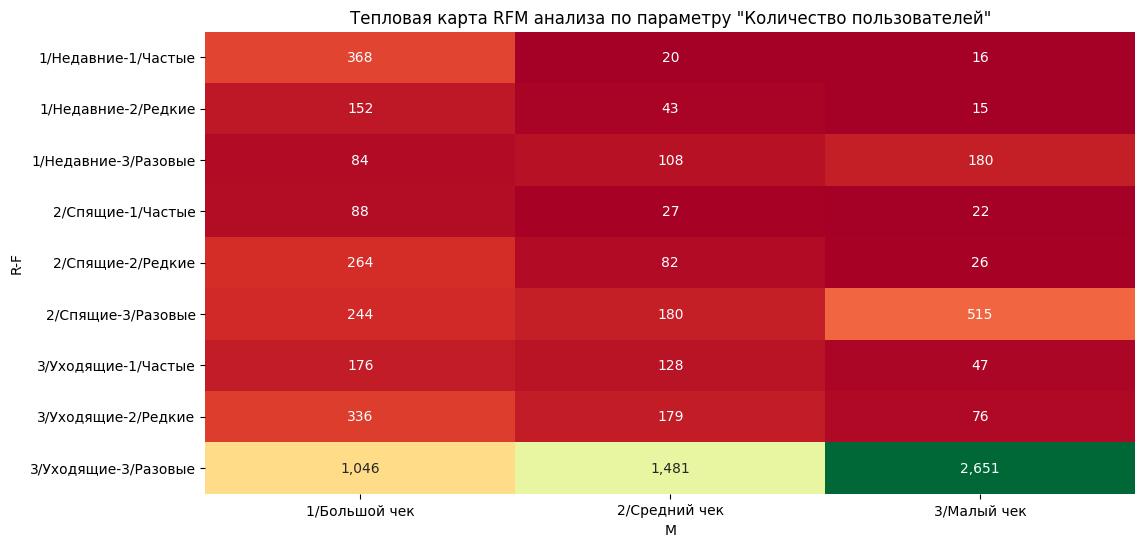

In [106]:
show_rfm_table_sns(rfm_table, 'rfm_users')

Больше всего пользователей в самой стрёмной категории: Уходящие / Разовые / Малый чек.

In [107]:
r3f3_u = rfm_table.query('R == "3/Уходящие" and F == "3/Разовые"')['rfm_users'].sum() / rfm_table['rfm_users'].sum()
print(f'Уходящие/Разовые {r3f3_u:.2%}')

Уходящие/Разовые 60.53%


На "Уходящих / Разовых" приходится порядка 2/3 всех пользователей...

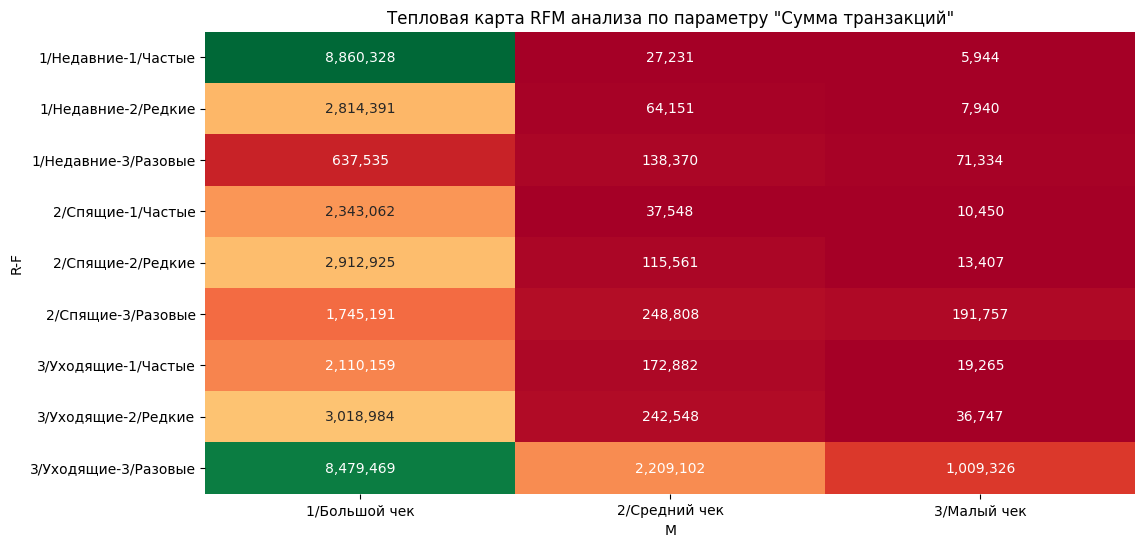

In [108]:
show_rfm_table_sns(rfm_table, 'rfm_sum')

In [109]:
r3f3_d = rfm_table.query('R == "3/Уходящие" and F == "3/Разовые"')['rfm_sum'].sum() / rfm_table['rfm_sum'].sum()
print(f'Уходящие/Разовые {r3f3_d:.2%}')

Уходящие/Разовые 31.16%


Тем не менее "Уходящие / Разовые" приносят и денег практически наравне с "Частыми / Недавними" примерно треть суммы донатов. А если бы "Уходящие / Разовые" перевести хотя бы в категорию "Редкие" ... то донатов было бы больше.

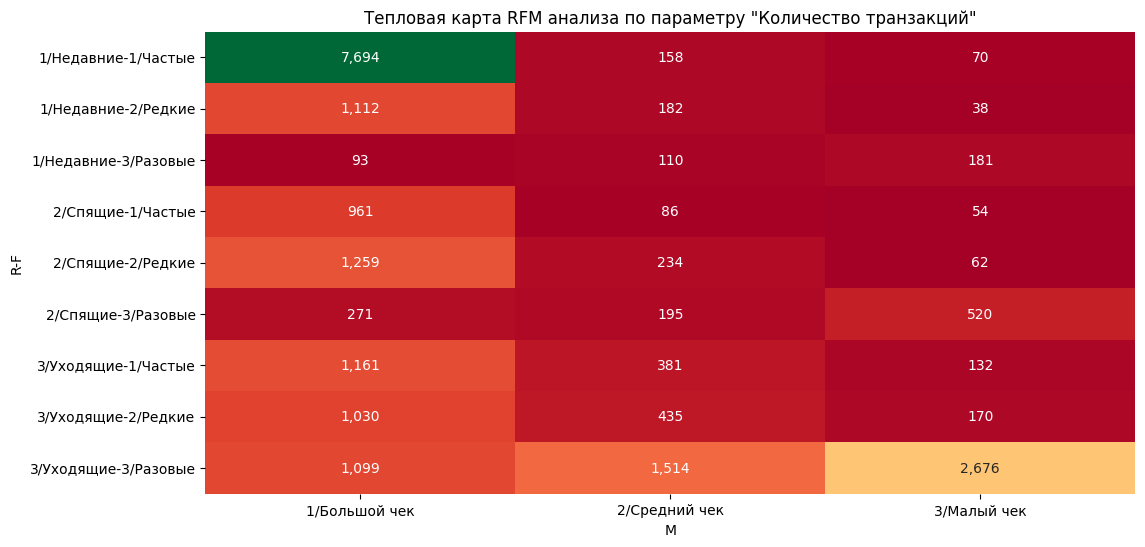

In [110]:
show_rfm_table_sns(rfm_table, 'rfm_tr')

По транзакциям всё ожидаемо — больше всего их у подписок, то есть в категории «Недавние / Частые».

### Выводы по RFM-анализу от deepseek

1. **Наиболее ценные сегменты (111, 121, 211, 221, 311, 321, 331)**:
   - Группы с высоким средним чеком (M=1) и высокой частотой пожертвований (F=1 или F=2) демонстрируют наибольший вклад в общую сумму пожертвований. Например:
     - **111 (Недавние, Частые, Большой чек)**: 368 пользователей, 7 694 транзакции, 8 860 328.26 рублей.
     - **331 (Уходящие, Разовые, Большой чек)**: 1 046 пользователей, 1 099 транзакций, 8 479 469.39 рублей.
   - Эти группы являются ключевыми для фонда, так как приносят значительную часть дохода.

2. **Сегменты с потенциалом роста**:
   - Группы со средним чеком (M=2) и редкими/разовыми пожертвованиями (F=2, F=3), например:
     - **122 (Недавние, Редкие, Средний чек)**: 43 пользователя, 182 транзакции, 64 151 рубль.
     - **232 (Спящие, Разовые, Средний чек)**: 180 пользователей, 195 транзакций, 248 808 рублей.
   - Эти группы могут быть стимулированы к более частым или крупным пожертвованиям.

3. **Сегменты с низкой вовлеченностью**:
   - Группы с малым чеком (M=3) и разовыми/редкими пожертвованиями (F=3, F=2), например:
     - **133 (Недавние, Разовые, Малый чек)**: 180 пользователей, 181 транзакция, 71 334 рубля.
     - **333 (Уходящие, Разовые, Малый чек)**: 2 651 пользователь, 2 676 транзакций, 1 009 326 рублей.
   - Хотя эти группы приносят небольшой доход на пользователя, их количество велико, что делает их важными для массовых кампаний.

4. **Уходящие пользователи (R=3)**:
   - Сегменты с меткой "Уходящие" (например, 331, 332, 333) имеют большое количество пользователей, но низкую частоту взаимодействия. Особенно выделяется группа **331**, которая приносит значительный доход, несмотря на разовые пожертвования. Это указывает на необходимость реактивации таких пользователей.

### Рекомендации

1. **Для ценных сегментов (111, 121, 211, 221, 311, 321)**:
   - **Персонализированные благодарности**: Отправляйте индивидуальные сообщения с благодарностью и отчетами о использовании средств.
   - **Программы лояльности**: Предложите участие в закрытых мероприятиях или эксклюзивные обновления о проектах фонда.
   - **Увеличение частоты пожертвований**: Мотивируйте их на регулярные пожертвования, например, через подписки.

2. **Для сегментов с потенциалом роста (122, 232, 112, 212)**:
   - **Стимулирование частоты**: Запустите кампании с напоминаниями или бонусами за повторные пожертвования.
   - **Увеличение среднего чека**: Предложите варианты увеличения суммы пожертвований, например, "Ваши 500 рублей могут превратиться в 1 000, если вы пожертвуете ежемесячно".

3. **Для сегментов с низкой вовлеченностью (133, 233, 333)**:
   - **Массовые кампании**: Используйте email-рассылки и социальные сети для привлечения внимания к актуальным проектам.
   - **Микро-пожертвования**: Предложите удобные варианты небольших, но регулярных взносов (например, через мобильные приложения).

4. **Для уходящих пользователей (331, 332, 333)**:
   - **Реактивация**: Запустите кампании с эмоциональными историями или срочными просьбами, например, "Нам срочно нужна ваша помощь!".
   - **Обратная связь**: Узнайте причины снижения активности через опросы и предложите решения их проблем.

5. **Общие рекомендации**:
   - **Автоматизация отчетов**: Регулярно информируйте всех доноров о том, как их средства помогают проектам.
   - **A/B тестирование**: Тестируйте разные подходы к коммуникации, чтобы определить наиболее эффективные.
   - **Сегментация коммуникации**: Разделяйте аудиторию по RFM-группам и адаптируйте сообщения под их поведение.

### Заключение
RFM-анализ показал, что фонд может увеличить доход, фокусируясь на удержании ценных доноров, реактивации уходящих пользователей и стимулировании сегментов с потенциалом роста. Персонализация и своевременная коммуникация будут ключевыми факторами успеха.

# Когортный анализ

Строим таблицу когорт, период когорты — календарный месяц. Горизонт — весь диапазон дат транзакций.

Также не учитываем транзакции > 200 000 рублей.

In [111]:
chogort_table = get_chogort_table(tranz.query('donate < @rfm_donate_lim'))
chogort_table.head()

tr_mon  user_count  tr_count  donate_sum  tr_y  tr_m       ch  m_live  \
0       1         360       384   510166.00  2023     1  2023_01       1   
1       2         268       296   278389.00  2023     2  2023_01       2   
2       3         277       345   344994.00  2023     3  2023_01       3   
3       4         260       290   261043.00  2023     4  2023_01       4   
4       5         257       285   342810.00  2023     5  2023_01       5   

         ltv     ltv_m     rr   cr  
0  510166.00 510166.00 100.00 1.00  
1  788555.00 394278.00  74.44 0.74  
2 1133549.00 377850.00  76.94 1.03  
3 1394592.00 348648.00  72.22 0.94  
4 1737402.00 347480.00  71.39 0.99

In [112]:
chogort_table.to_csv('chogort_table.csv')

"Треугольные" тепловые карты коротного анализа по показателям

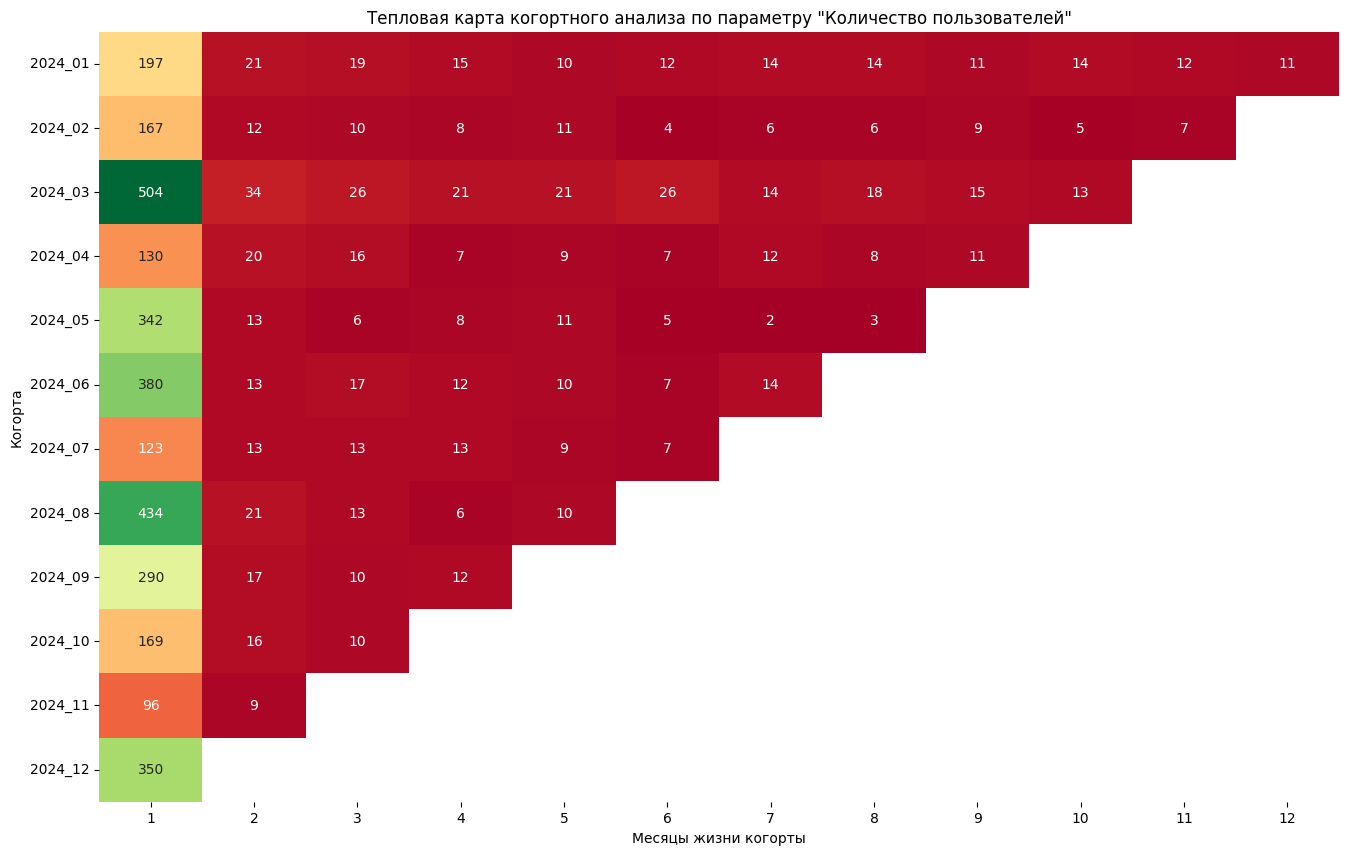

In [113]:
show_chogort_table_sns(chogort_table, col='user_count', ml=12)

Когортный анализ подтверждает то, что подавляющее большинство пользователей после первого доната исчезают.

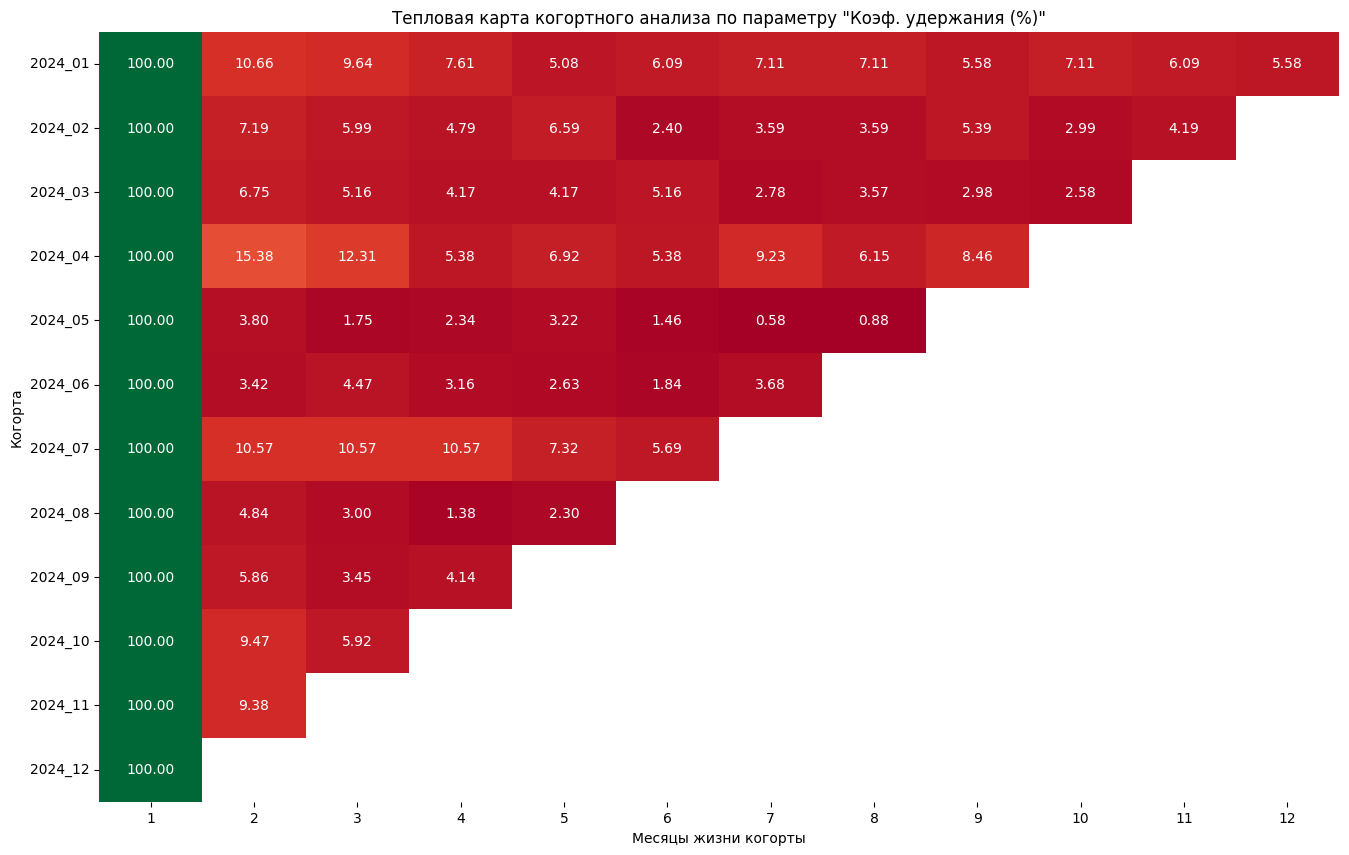

In [114]:
show_chogort_table_sns(chogort_table, col='rr', pr=2, ml=12)

Через месяц остается  меньше 10%, которые потом как правило остаются верны сервису.

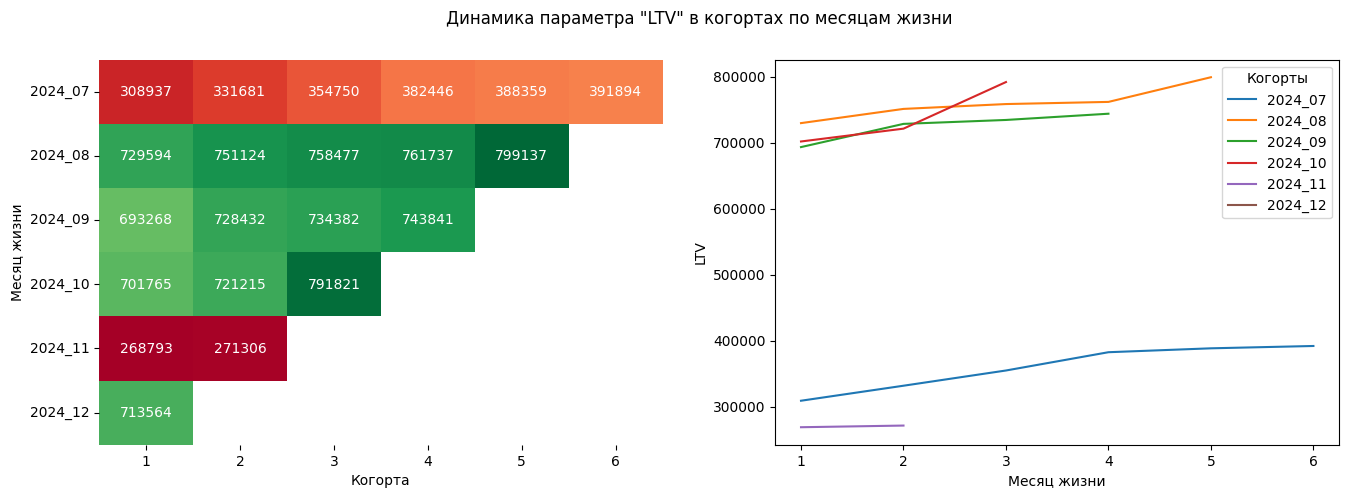

In [115]:
graf_chogort_subplot(chogort_table, col='ltv', pr=0, ml=6)

За 2024 год по параметру LTV самые удачные когорты мартовская и июньская - изначально высокая база и стабильный рост после. Напомним, 21 марта отмечается Международный день человека с синдромом Дауна.

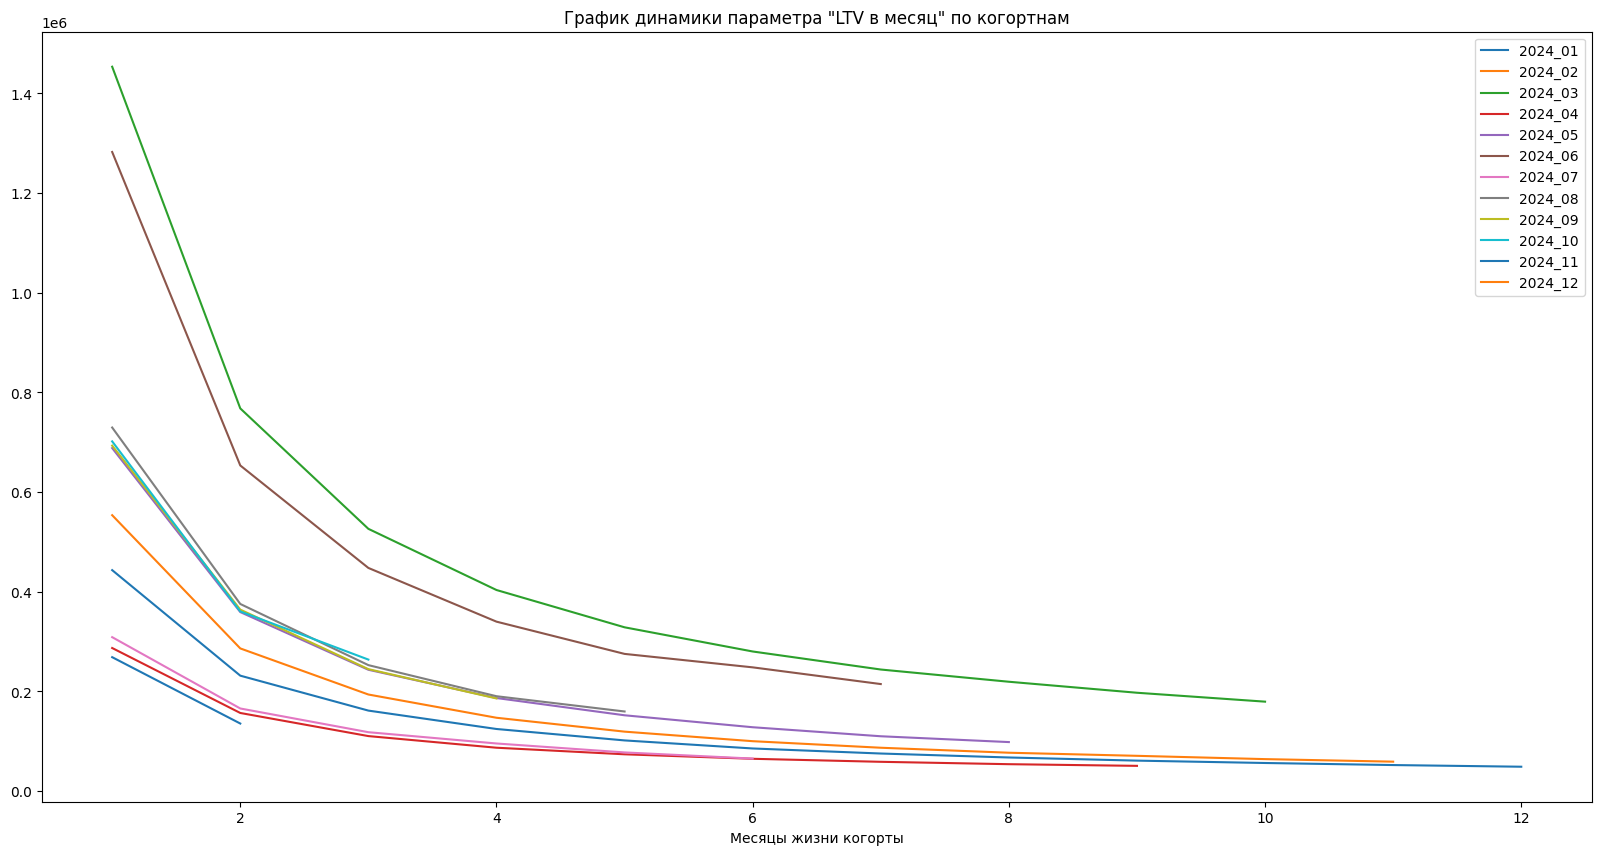

In [116]:
graf_chogort(chogort_table, col='ltv_m', ml=12)

### Когортный анализ пожертвований от deepseek

#### Основные выводы:

1. **Первая когорта (постоянные донаторы)**:
   - Показывает высокую стабильность с LTV в 267 тыс. руб. к 24-му месяцу.
   - Retention Rate (RR) постепенно снижается с 100% до 30% к 24-му месяцу, что типично для долгосрочных доноров.
   - Средний чек остается высоким, что указывает на лояльность этой группы.

2. **Когорта июня 2023 (технический сбой)**:
   - Заметное падение RR до 34.44% в 6-м месяце, что связано с техническими проблемами.
   - Несмотря на сбой, когорта частично восстановилась, но LTV остался ниже среднего.

3. **Общие тренды**:
   - **Retention Rate**: В среднем снижается до 20-30% к 12-му месяцу. Исключение — когорта марта 2023 с RR 7.09% к 22-му месяцу.
   - **LTV**: Наибольший вклад у когорт марта 2023 (5.6 млн руб.) и января 2023 (6.4 млн руб.). Новые когорты (2024) показывают меньший LTV, что требует доработки стратегий удержания.
   - **Средний чек**: Когорты с высоким средним чеком (например, март 2023) демонстрируют более стабильный LTV.

4. **Сезонность**:
   - Пики активности наблюдаются в конце года (декабрь — январь), что связано с праздничными кампаниями.
   - Летние месяцы (июнь-август) часто показывают снижение активности, особенно у новых доноров.

5. **Эффективность новых когорт (2024)**:
   - Когорта января 2024: RR упал до 5.58% к 22-му месяцу, LTV — 587 тыс. руб.
   - Когорта марта 2024: Высокий стартовый LTV (1.45 млн руб.), но RR снижается до 2.58% к 24-му месяцу.

#### Рекомендации:

1. **Для первой когорты (постоянные донаторы)**:
   - Внедрите программу лояльности с эксклюзивными отчетами и благодарностями.
   - Персонализируйте коммуникацию, чтобы поддерживать высокий средний чек.

2. **Для когорт с низким RR**:
   - Усильте работу с реактивацией:
     - Напоминания о миссии фонда.
     - Кампании срочной помощи ("Ваш вклад нужен сейчас!").
   - Оптимизируйте email-рассылки и push-уведомления.

3. **После технических сбоев**:
   - Разработайте план экстренной коммуникации с донорами при подобных инцидентах.
   - Предложите бонусы или дополнительные возможности для пострадавших когорт (например, июнь 2023).

4. **Для новых когорт (2024)**:
   - Улучшите onboarding:
     - Серия приветственных писем с историями благополучателей.
     - Подписка на регулярные пожертвования с первого доната.
   - Тестируйте разные каналы привлечения, чтобы найти наиболее устойчивые.

5. **Сезонные стратегии**:
   - Готовьтесь к年末ным кампаниям заранее, планируя эмоциональный контент.
   - Летом запускайте легкие форматы участия (например, микро-пожертвования через соцсети).

6. **Общие улучшения**:
   - Внедрите A/B тестирование для ключевых страниц доната.
   - Добавьте триггерные письма (например, после первого пожертвования или при долгом отсутствии активности).
   - Оптимизируйте мобильный опыт, так как часть доноров может теряться на этом этапе.

#### Заключение:
Фонд демонстрирует хорошую базу постоянных доноров, но требует усиления работы с новыми когортами. Основные усилия стоит направить на повышение Retention Rate через персонализацию и своевременную коммуникацию. Техническая надежность системы и сезонные стратегии также являются критическими зонами для роста.

**Промежуточные итоги:**

Когортный анализ показал, что только 10% новых пользователей лояльны сервису, то есть остаются и делают повторные пожертвования. Наиболее удачные когорты в 2024 году — мартовская и июнская.

In [117]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-16 20:37:37.320236+04:00
 От начала рассчета прошло 0:00:42.559188


# Сегментация транзакций по параметрам

Полнота данных параметров транзакций

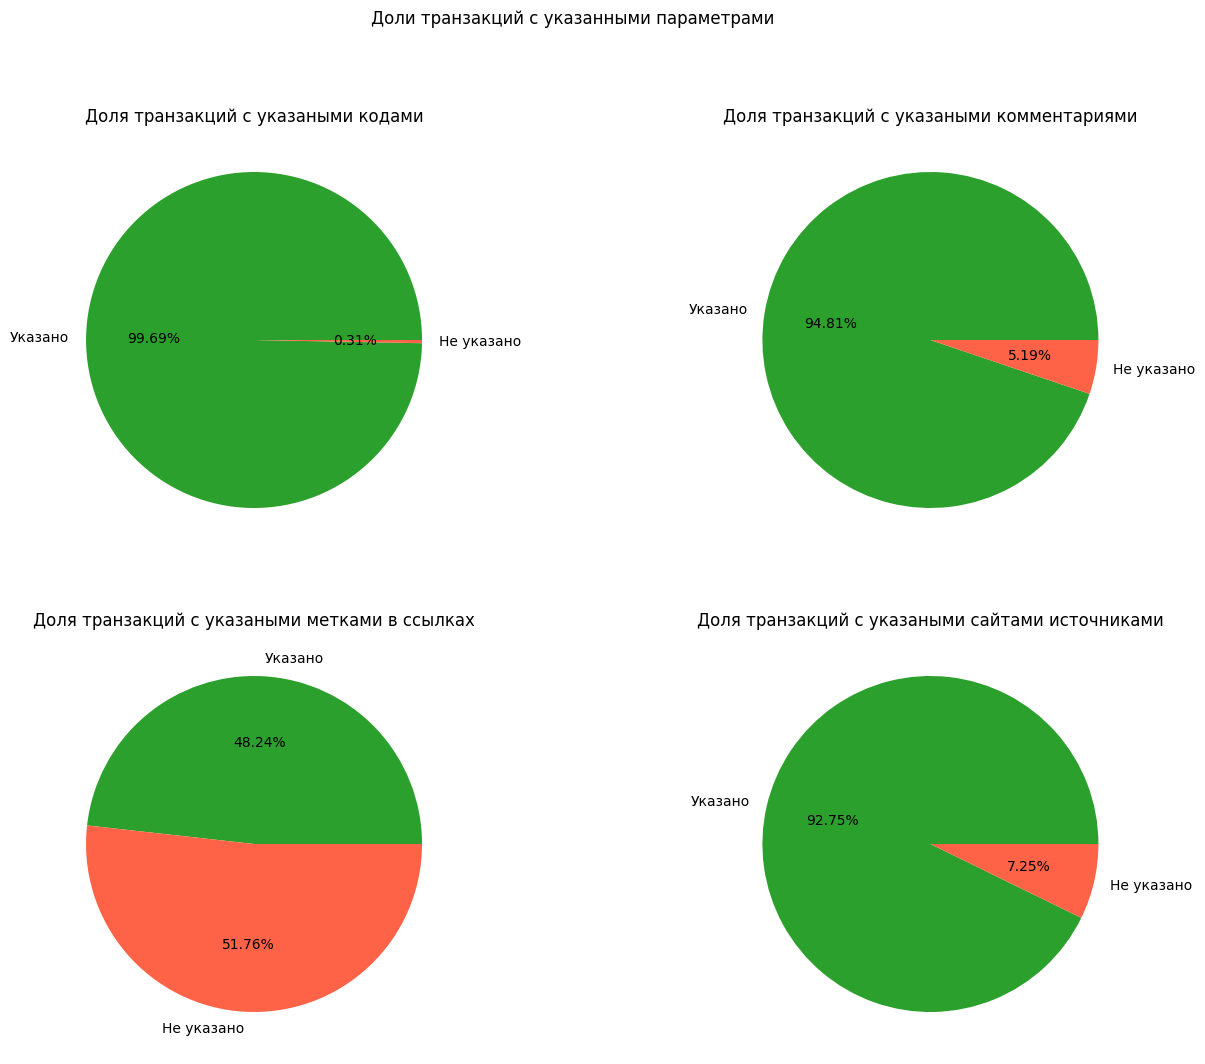

In [118]:
f, ax = plt.subplots(2, 2, figsize=(16, 12))
dd = tranz.query('code == "Не указано"')['id'].count()

ax[0, 0].pie([tr_all - dd, dd],  labels = ['Указано', 'Не указано'], colors=['tab:green', 'tomato'], autopct=lambda p : '{:.2f}%'.format(p))
ax[0, 0].set_title('Доля транзакций с указаными кодами')

dd = tranz.query('comment == "Не указано"')['id'].count()
ax[0, 1].pie([tr_all - dd, dd], labels = ['Указано', 'Не указано'], colors=['tab:green', 'tomato'], autopct=lambda p : '{:.2f}%'.format(p))
ax[0, 1].set_title('Доля транзакций с указаными комментариями')

dd = tranz.query('action == "Не указано"')['id'].count()
ax[1, 0].pie([tr_all - dd, dd], labels = ['Указано', 'Не указано'], colors=['tab:green', 'tomato'], autopct=lambda p : '{:.2f}%'.format(p))
ax[1, 0].set_title('Доля транзакций с указаными метками в ссылках')

dd = tranz.query('site == "Не указано"')['id'].count()
ax[1, 1].pie([tr_all - dd, dd], labels = ['Указано', 'Не указано'], colors=['tab:green', 'tomato'], autopct=lambda p : '{:.2f}%'.format(p))
ax[1, 1].set_title('Доля транзакций с указаными сайтами источниками')


plt.suptitle('Доли транзакций с указанными параметрами')
plt.show()

Практически все транзакции содержат коды, у 95% донатов есть комментарий, меток в ссылках нет в половине случаев. В дальнейшем для анализа следует принимать коды транзакций.

### Коды

Сформируем таблицу кодов. Рассчитаем для каждого кода кол-во транзакций и пользователей, а также сумму донатов. Составим ранги по каждой из этих колонок, а также суммарный ранг. Наилучшим будет код, имеющий наименьшую сумму трех рангов.

In [119]:
codes_table = par_rank_table(tranz, 'code')
codes_table.sort_values(by = ['rank_sum']).style.format('{:.0f}')\
        .background_gradient(subset=['rank_sum', 'tc_rank', 'uc_rank', 'ds_rank'], cmap='RdYlGn_r')

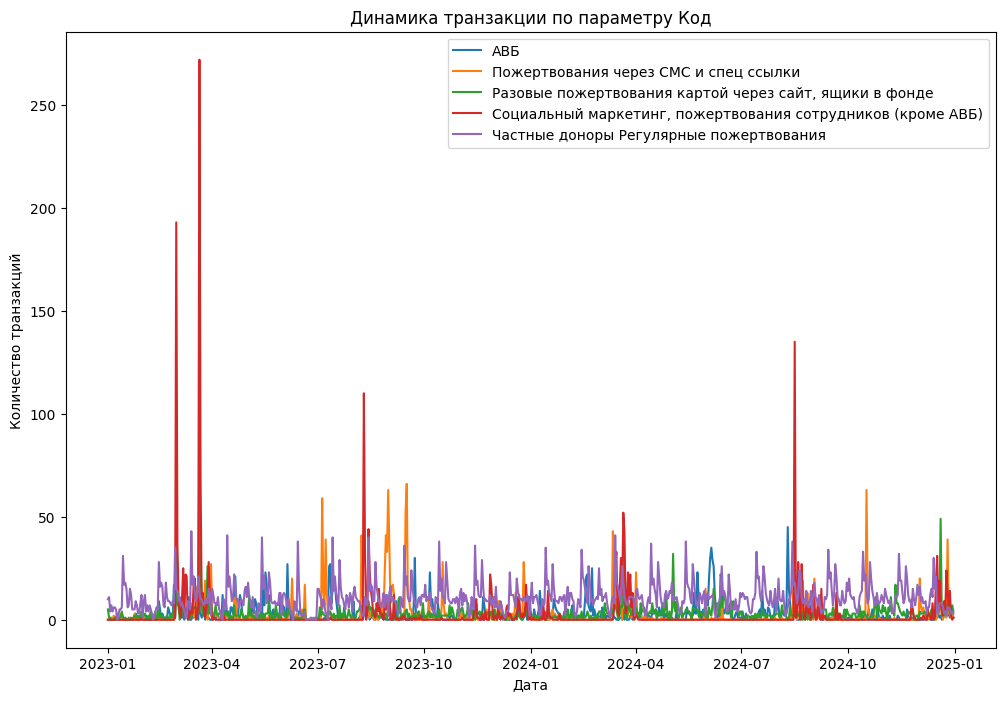

In [120]:
graf_dynamik_by_par(tranz.query('code != "Не указано"'), 'code', 5)

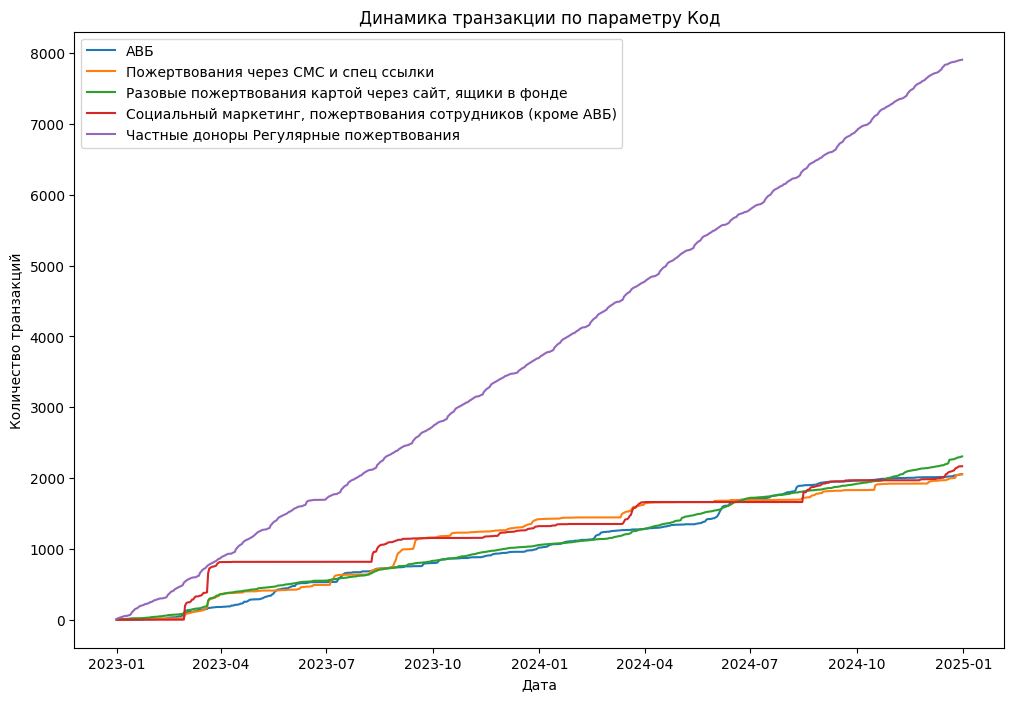

In [121]:
graf_dynamik_by_par(tranz.query('code != "Не указано"'), 'code', 5, 'cumsum')

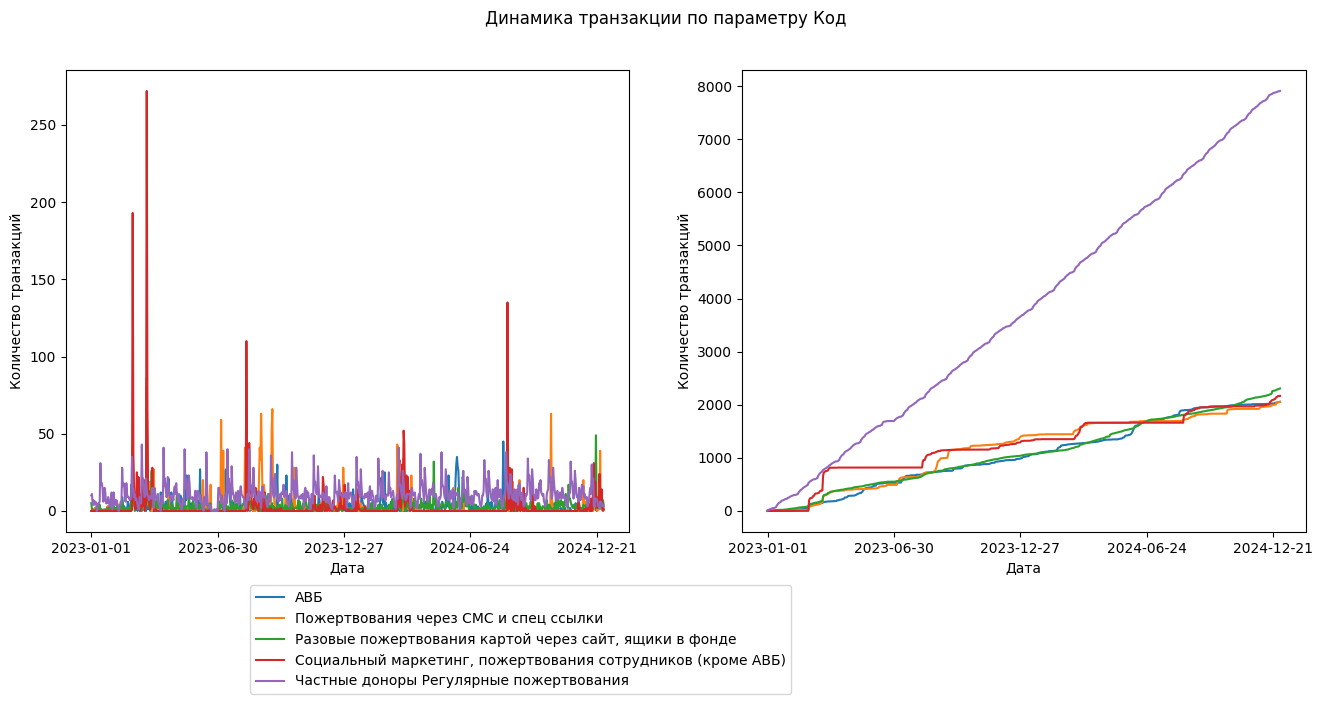

In [122]:
graf_dynamik_by_par_subplot(tranz.query('code != "Не указано"'), 'code', 5)

График транзакций по дням показывает, что пожертвования в разрезе кодов также идут импульсами. Пики на графике должны соответствовать наиболее удачным акциям / мероприятиям / событиям. Донаты с кодами «Разовые пожертвования», «Регулярные пожертвования», «АВБ» идут регулярно. «Социальный меркетинг», «Пожертвования через СМС» — ступеньками, то есть зависят от акций и мероприятий.

Таблица дат пиков кодов

In [123]:
tranz.groupby(['date', 'code'], as_index=False)['id'].count()\
    .query('id > 50').rename(columns = {'id' : 'tr_count'})

date                                                         code  \
218  2023-03-01  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
349  2023-03-21                        Пожертвования через СМС и спец ссылки   
350  2023-03-21       Разовые пожертвования картой через сайт, ящики в фонде   
351  2023-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
359  2023-03-22  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
894  2023-07-05                        Пожертвования через СМС и спец ссылки   
980  2023-07-20                                      Частные доноры Рассылки   
1094 2023-08-10  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
1246 2023-08-31                        Пожертвования через СМС и спец ссылки   
1344 2023-09-15                        Пожертвования через СМС и спец ссылки   
1350 2023-09-16                        Пожертвования через СМС и спец ссылки   
1533 2023-10-14                                           ВИД массовые акции   
1795 2023-11-28                                      Частные доноры Рассылки   
2472 2024-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
2902 2024-05-31                                           ВИД массовые акции   
3328 2024-08-16  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
3623 2024-09-28                                                Телемаркетинг   
3726 2024-10-17                        Пожертвования через СМС и спец ссылки   

      tr_count  
218        193  
349         86  
350         81  
351        272  
359         67  
894         59  
980        106  
1094       110  
1246        63  
1344        52  
1350        66  
1533        55  
1795        79  
2472        52  
2902       100  
3328       135  
3623       111  
3726        63

### Комментарии

Аналогично формируем таблицу комментариев

In [124]:
codes_table = par_rank_table(tranz, 'comment')
codes_table.sort_values(by = ['rank_sum']).head(20).style.format('{:.0f}')\
        .background_gradient(subset=['rank_sum', 'tc_rank', 'uc_rank', 'ds_rank'], cmap='RdYlGn_r')

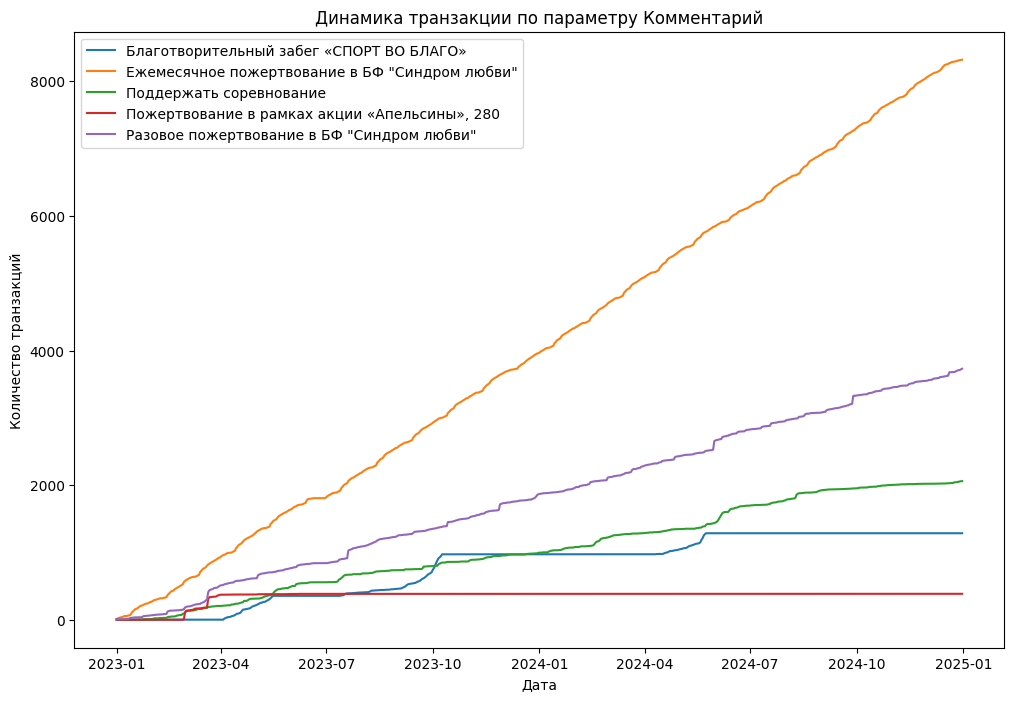

In [125]:
graf_dynamik_by_par(tranz.query('comment != "Не указано"'), 'comment', 5, 'cumsum')

Донаты с комментами «Ежемесячные пожертвования», «Разовые пожертвования», «Поддержать соревнования» идут практически регулярно. «Благотворительный забег», «Акция «Апельсины» — ступеньками, то есть зависят от акций и мероприятий.

Таблица дат пиков комметариев

In [126]:
tranz.groupby(['date', 'comment'], as_index=False)['id'].count()\
    .query('id > 50').rename(columns = {'id' : 'tr_count'})

date  \
206  2023-03-01   
208  2023-03-01   
367  2023-03-21   
371  2023-03-21   
372  2023-03-21   
893  2023-07-05   
975  2023-07-20   
1464 2023-09-16   
1648 2023-10-14   
1903 2023-11-28   
3089 2024-05-31   
3486 2024-08-16   
3825 2024-09-28   
3926 2024-10-17   

                                                                      comment  \
206                             Пожертвование в рамках акции «Апельсины», 280   
208                             Пожертвование в рамках акции «Апельсины», 590   
367                             Пожертвование в рамках акции «Апельсины», 280   
371                             Пожертвование в рамках акции «Апельсины», 590   
372                                Разовое пожертвование в БФ "Синдром любви"   
893                                    Разовое пожертвование "День рождения "   
975                                Разовое пожертвование в БФ "Синдром любви"   
1464                     Разовое пожертвование "Академия успеха Атоми в Сочи"   
1648                               Разовое пожертвование в БФ "Синдром любви"   
1903                               Разовое пожертвование в БФ "Синдром любви"   
3089                               Разовое пожертвование в БФ "Синдром любви"   
3486  Разовое пожертвование в рамках акции «Школа начинается с перемен!», 280   
3825                               Разовое пожертвование в БФ "Синдром любви"   
3926                                   Разовое пожертвование "Добрый юбилей "   

      tr_count  
206        106  
208         78  
367        122  
371        115  
372        112  
893         56  
975        114  
1464        59  
1648        60  
1903        82  
3089       128  
3486        73  
3825       119  
3926        51

### Метки в ссылках

Аналогично формируем таблицу меток в ссылках

In [127]:
codes_table = par_rank_table(tranz, 'action')
codes_table.sort_values(by = ['rank_sum']).head(20).style.format('{:.0f}')\
        .background_gradient(subset=['rank_sum', 'tc_rank', 'uc_rank', 'ds_rank'], cmap='RdYlGn_r')

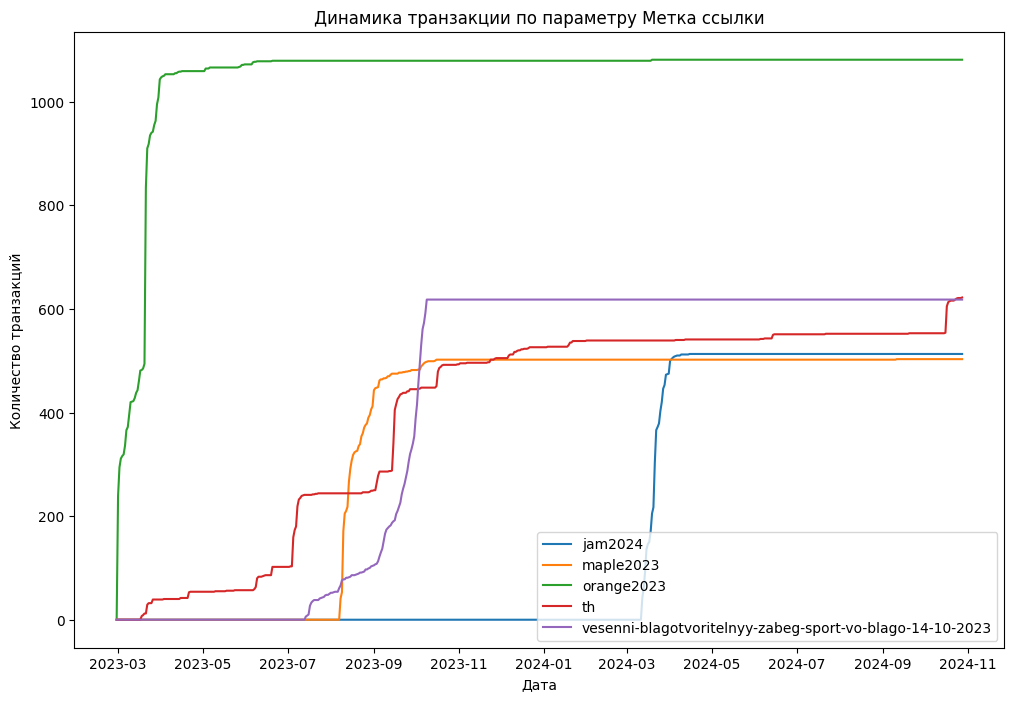

In [128]:
graf_dynamik_by_par(tranz.query('action != "Не указано"'), 'action', 5, 'cumsum')

Донаты с метками в ссылках все идут «ступеньками».

Таблица дат пиков меток из ссылок

In [129]:
tranz.groupby(['date', 'action'], as_index=False)['id'].count()\
    .query('id > 100').rename(columns = {'id' : 'tr_count'})

date        action  tr_count
155  2023-03-01    orange2023       235
266  2023-03-21    orange2023       340
827  2023-07-20  EN_needs7.23       114
913  2023-08-10     maple2023       118
2681 2024-08-16      school24       137

### Сайты-источники

Аналогично формируем таблицу сайтов-источников

In [130]:
codes_table = par_rank_table(tranz, 'site')
codes_table.sort_values(by = ['rank_sum']).style.format('{:.0f}')\
        .background_gradient(subset=['rank_sum', 'tc_rank', 'uc_rank', 'ds_rank'], cmap='RdYlGn_r')

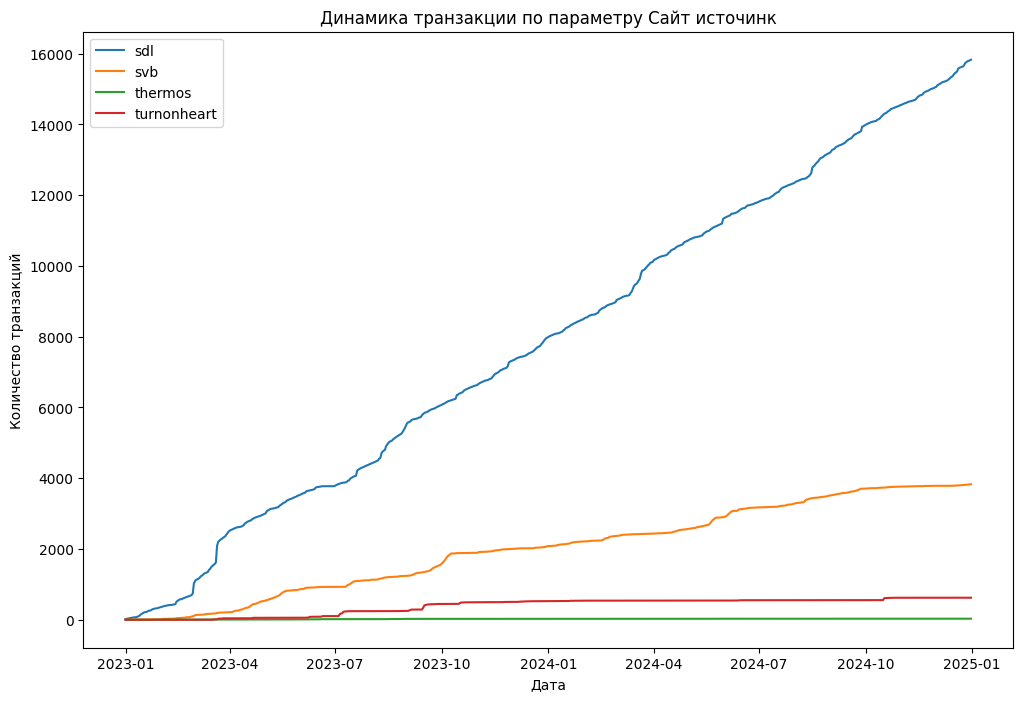

In [131]:
graf_dynamik_by_par(tranz.query('site != "Не указано"'), 'site', 5, 'cumsum')

Таблица дат пиков сайтов-источников

In [132]:
tranz.groupby(['date', 'site'], as_index=False)['id'].count()\
    .query('id > 100').rename(columns = {'id' : 'tr_count'})

date site  tr_count
118  2023-03-01  sdl       281
172  2023-03-21  sdl       470
175  2023-03-22  sdl       117
494  2023-07-20  sdl       144
548  2023-08-10  sdl       132
560  2023-08-14  sdl       106
864  2023-11-28  sdl       109
1160 2024-03-21  sdl       142
1363 2024-05-31  sdl       130
1576 2024-08-16  sdl       160
1696 2024-09-28  sdl       130

**Промежуточные итоги:**

Построили сегментацию транзакций и пользователей по сайтам-источникам, кодам, комментариям, меткам в ссылках. Определили ТОПовые значения в каждом сегменте по пользователям и транзакциям. Также определили даты «пиков» динамики по сегментам, которые должны соответствовать наиболее успешным акциям / мероприятиям / рассылкам.

In [133]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-16 20:37:40.174418+04:00
 От начала рассчета прошло 0:00:45.413371


# Категоризация донаторов

Исходя из выявленного характера догатов, имеет смысл разбить пользователей на категории: «Подписчики», «Разовые», «Простые» и «Корпоративные», чтобы паттерны поведения среди пользователей одной категории были более однородны. Благодаря этому можно выяснить характеристики пользователей более точно.

## Доли категорий по сумме донатов, транзакциям, людям

Агрегированные данные по категориям

In [134]:
user_seg = user_table.groupby('type').agg({'donate_sum' : 'sum', 'tr_count' : 'sum', 'user_id' : 'count'})
user_seg.loc['Компания'] = corp.agg({'donate' : 'sum', 'id' : 'count', 'comp_id' : 'nunique'}).to_list()
user_seg['t_u'] = user_seg['tr_count'] / user_seg['user_id']
user_seg['d_t'] = user_seg['donate_sum'] / user_seg['tr_count']
user_seg['d_u'] = user_seg['donate_sum'] / user_seg['user_id']

user_seg

donate_sum  tr_count  user_id   t_u       d_t       d_u
type                                                              
Подписчик 10531811.04   9288.00   587.00 15.82   1133.92  17941.76
Простой   17646773.42   5964.00  1503.00  3.97   2958.88  11741.03
Разовый   18431382.38   6644.00  6473.00  1.03   2774.14   2847.43
Компания  23566798.00    176.00    36.00  4.89 133902.26 654633.28

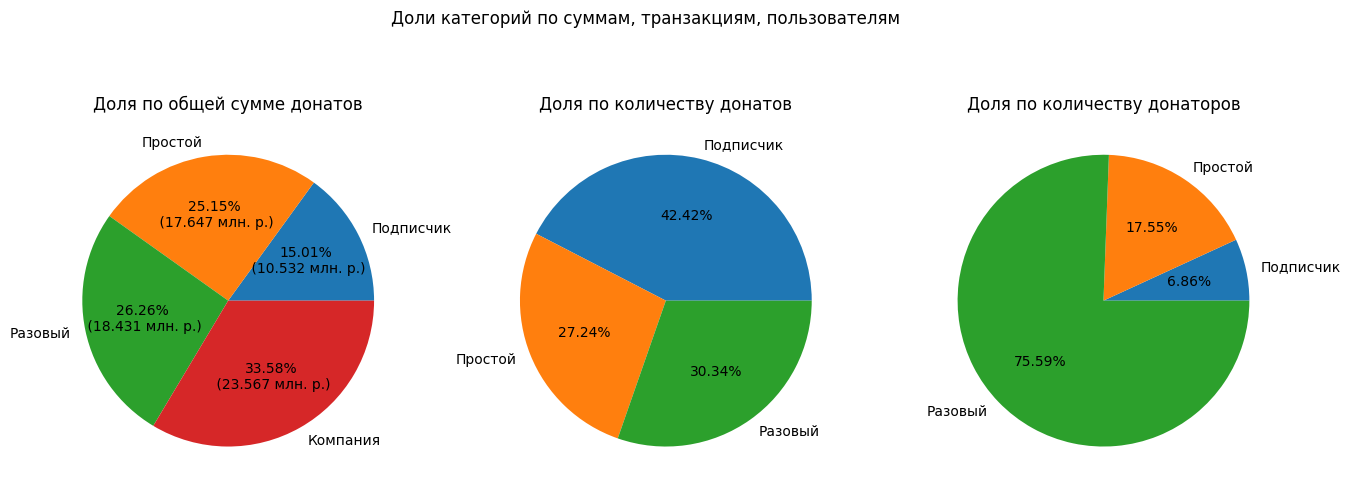

In [135]:
f, ax = plt.subplots(1, 3, figsize=(16,6))
dd = user_seg['donate_sum']
ax[0].pie(x = dd.values, labels = dd.index,  #autopct=lambda p : '{:.2f}%'.format(p))
  autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:,.3f} млн. р.)'.format(p*sum(dd)/10**8).replace(',', ' '))
ax[0].set_title('Доля по общей сумме донатов')

dd = user_seg['tr_count'][0:3]
ax[1].pie(x = dd.values, labels = dd.index,  autopct=lambda p : '{:.2f}%'.format(p))
ax[1].set_title('Доля по количеству донатов')

dd = user_seg['user_id'][0:3]
ax[2].pie(x = dd.values, labels = dd.index,  autopct=lambda p : '{:.2f}%'.format(p))
ax[2].set_title('Доля по количеству донаторов')

plt.suptitle('Доли категорий по суммам, транзакциям, пользователям')
plt.show()

По общим суммам в категориях лидируют корпоративные донаторы, при этом их исчезающе мало в разрезе количества транзакций и наименований. Поэтому дальше их рассматривать мы не будем.

Простые и разовые донаторы приносят примерно одинаково. Суммарные пожертвования от подписчиков меньше всего, но они все еще составляют значимую часть бюджета.

По среднему донату на человека из категорий ситуация диаметрально противоположная: подписчик приносит в среднем за два года 18,5 тысяч рублей, простой донатор — 11,5, а разовый только 2,8 тысячи рублей.

## Средняя сумма на транзакцию и пользователя по категориям

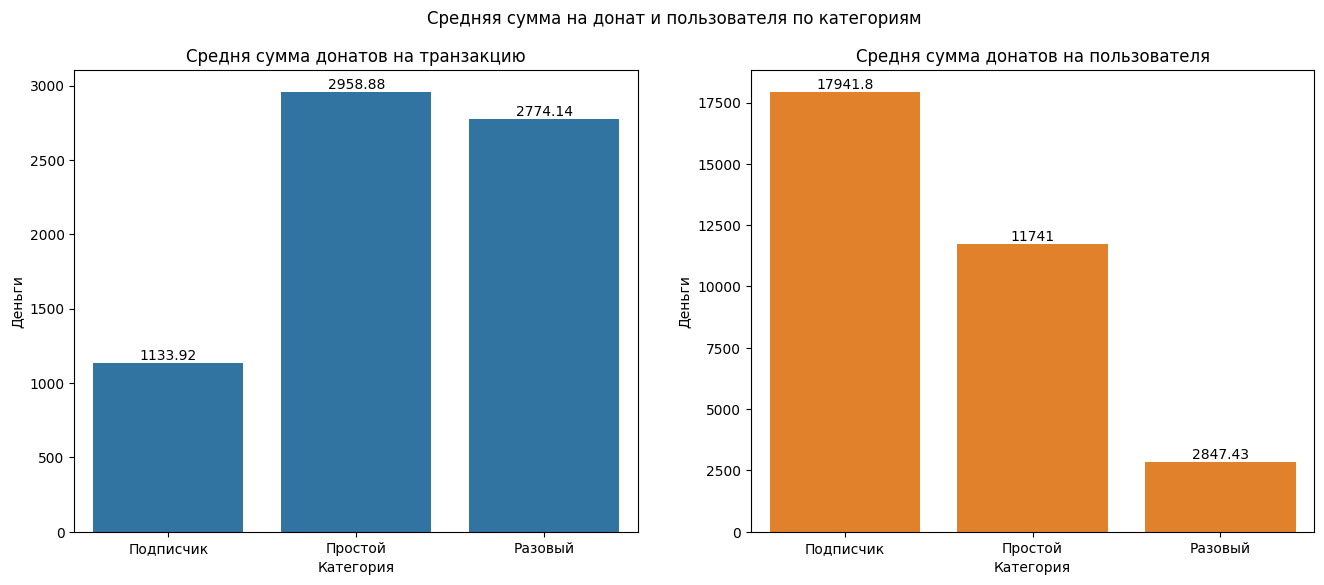

In [136]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
dd = user_seg['d_t'][0:3]
sns.barplot(y=dd, x=dd.index, color='tab:blue', ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10, label_type='edge', color='black')
ax[0].tick_params(axis='x', labelrotation = 0)
ax[0].set_title('Средня сумма донатов на транзакцию')
ax[0].set_xlabel('Категория')
ax[0].set_ylabel('Деньги')

dd = user_seg['d_u'][0:3]
sns.barplot(y=dd, x=dd.index, color='tab:orange', ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10, label_type='edge', color='black')
ax[1].tick_params(axis='x', labelrotation = 0)
ax[1].set_title('Средня сумма донатов на пользователя')
ax[1].set_xlabel('Категория')
ax[1].set_ylabel('Деньги')

plt.suptitle('Средняя сумма на донат и пользователя по категориям')
plt.show()

В категориях видна обратная зависимость суммы донатов на одну транзакцию и одного пользователя. У подписчиков наименьшие суммы на транзакцию, но наибольшие на пользователя. А у разовых наоборот — большие суммы на одну транзакцию и наименьшие на одного разового пользователя.

## Динамика роста общей суммы донатов в категориях

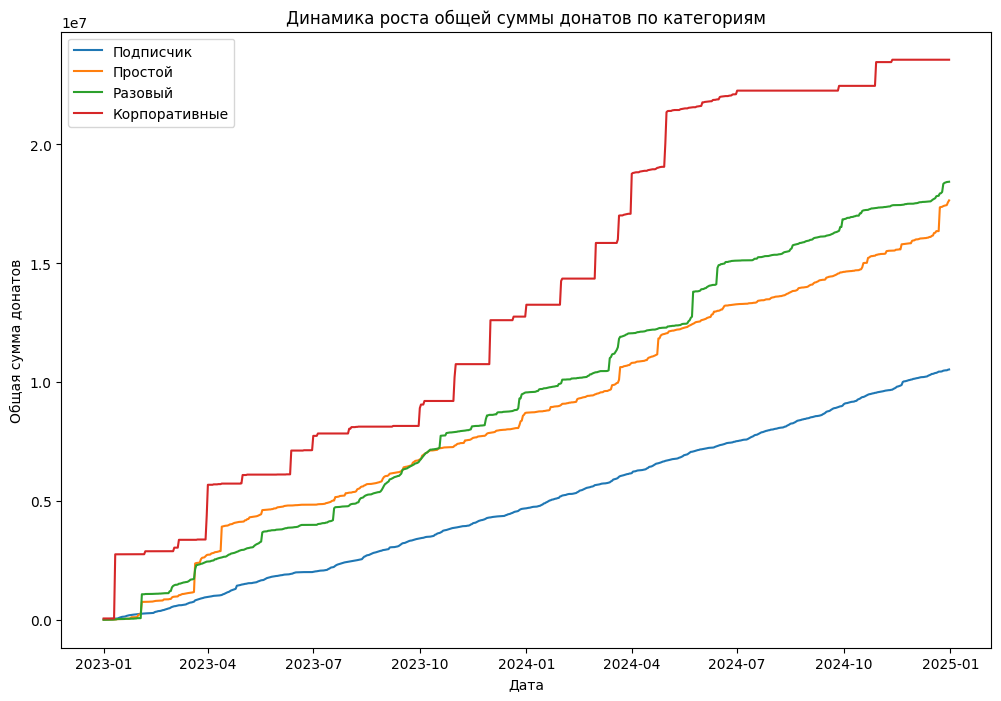

In [137]:
fig = plt.figure(figsize=(12, 8))
for seg in ['Подписчик', 'Простой', 'Разовый']:
  dd = tranz.query('type == @seg').groupby('date')['donate'].sum().to_frame()
  date_range = pd.date_range(start=dd.index.min(), end=dd.index.max(), freq='D')
  dd = dd.reindex(date_range, fill_value=0)
  dd['donate_cumsum'] = dd['donate'].cumsum()
  plt.plot(dd.index, dd['donate_cumsum'], label = seg)

ddс = corp.groupby('date')['donate'].sum().to_frame()
ddс = ddс.reindex(date_range, fill_value=0)
ddс['donate_cumsum'] = ddс['donate'].cumsum()
plt.plot(ddс.index, ddс['donate_cumsum'], label = 'Корпоративные')

plt.title(f'Динамика роста общей суммы донатов по категориям')
plt.xlabel('Дата')
plt.ylabel('Общая сумма донатов')
plt.legend()
plt.show()

График накопительных платежей от корпоративных донаторов имеет выраженный «ступенчатый» характер с выраженными «ступенями» и «полочками», в которых донатов просто нет. Это говорит об редких, но при этом крупных платежах.

График накопительных платежей от подписчиков практически линейно растет — без резких скачков и нулевых «полочек». Это говорит о регулярных донатах примерно на сопоставимую сумму каждый день.

График накопительных платежей от разовых и простых донаторов линейно растет, но при этом имеет резкие «ступеньки» и не имеет «полочек». Это говорит о наличии регулярных платежей в обеих категориях, но в некоторые дни наблюдаются резкие скачки сумм донатов, что может быть объяснено проведением каких-либо акций.

## Динамика количества донаторов в категориях по месяцам

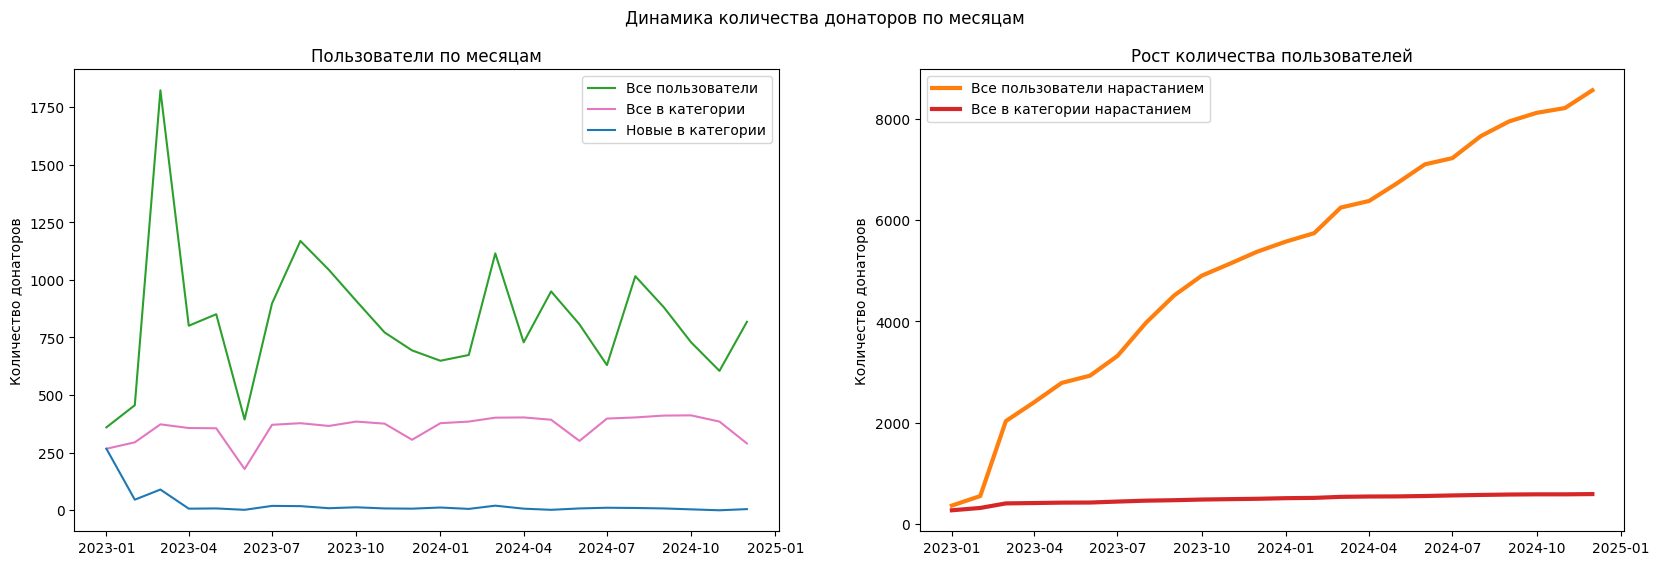

In [138]:
graf_dynamik_seg(tranz.query('type=="Подписчик"'))

Количество верных подписчиков, в отличие от количества всех донаторов, из месяца в месяц держится примерно на одном уровне. При этом новеньких подписчиков практически нет. С марта 2023 года по декабрь 2024 количество подписчиков выросло с 380 до 560. Это плохо, так как база лояльных донаторов, которые обеспечивают поступления в неудачные месяцы, не растет.

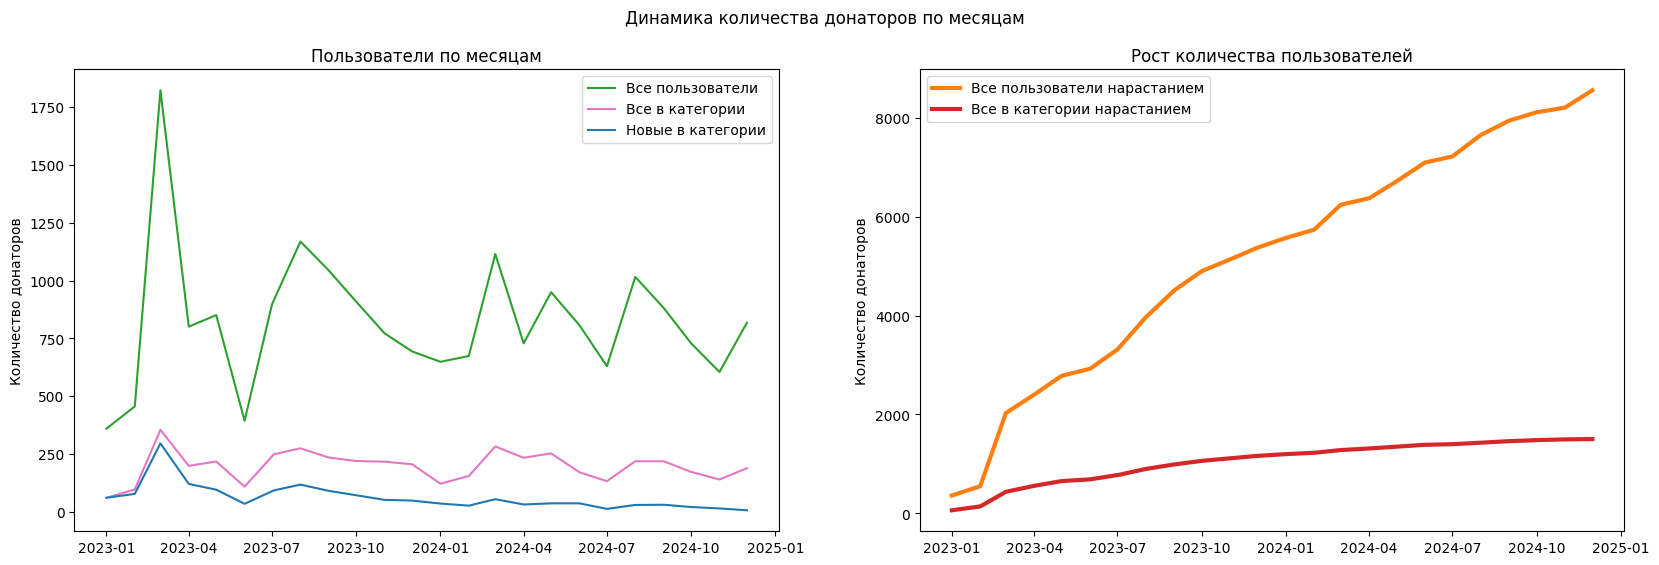

In [139]:
graf_dynamik_seg(tranz.query('type=="Простой"'))

Количество простых донаторов от месяца к месяцу нестабильно и колеблется синхронно со всеми пользователями. Новеньких Простых из месяца в месяц также мало, даже видна тенденция к снижению. База Простых пользователей имеет больший темп роста, чем подписчики, но в 2024 году видно замедление прироста.

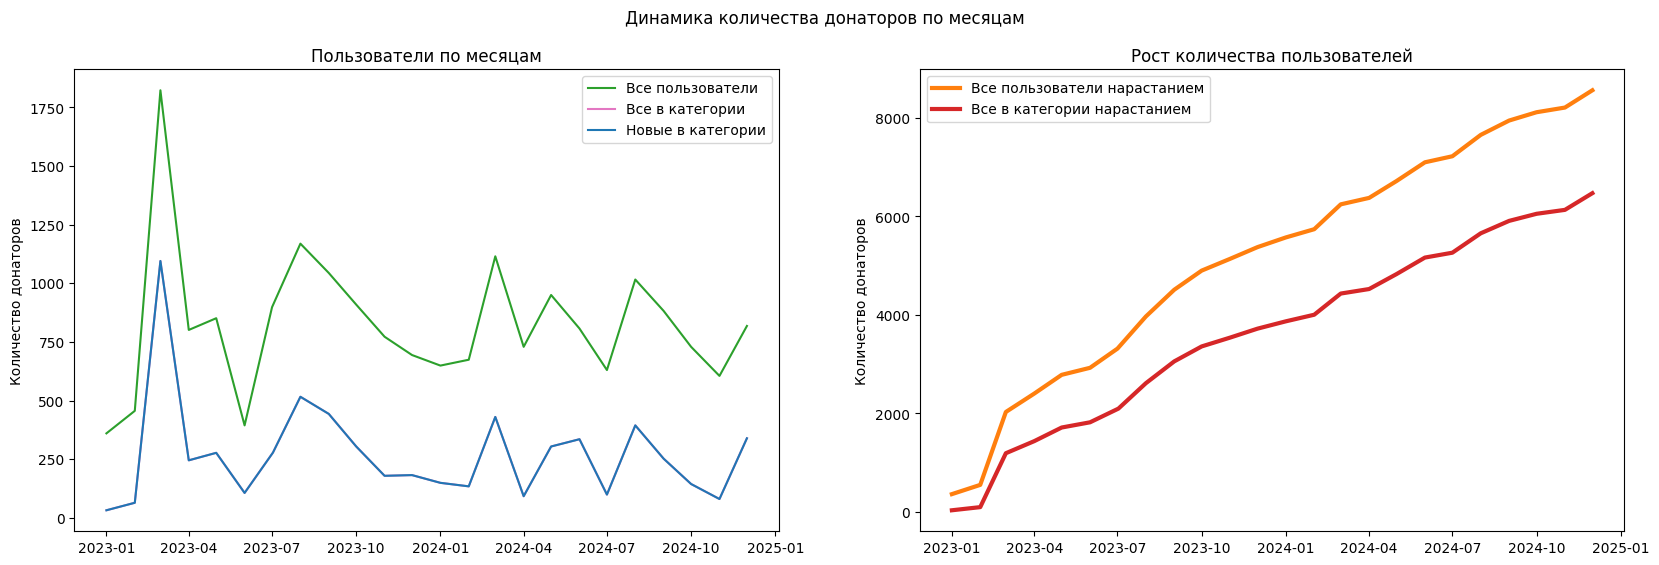

In [140]:
graf_dynamik_seg(tranz.query('type=="Разовый"'))

Количество разовых донаторов также подвержено колебаниям из месяца в месяц. Общая база разовых растет быстрее всего, но пользы от них после первого пожертвования нет.

## Средние донаты в удачные дни по категориям

Определяем удачные дни как дни, в которых отдельные категории собрали более 40 донатов.

In [141]:
goddays = []
for seg in ['Подписчик', 'Простой', 'Разовый']:
  dd = tranz.query('type==@seg').groupby(['date'], as_index=False).agg({'id' : 'count'})
  goddays = goddays + list(dd.query('id > 40')['date'])
goddays = set(goddays)

goddays = list(godday100['date'])

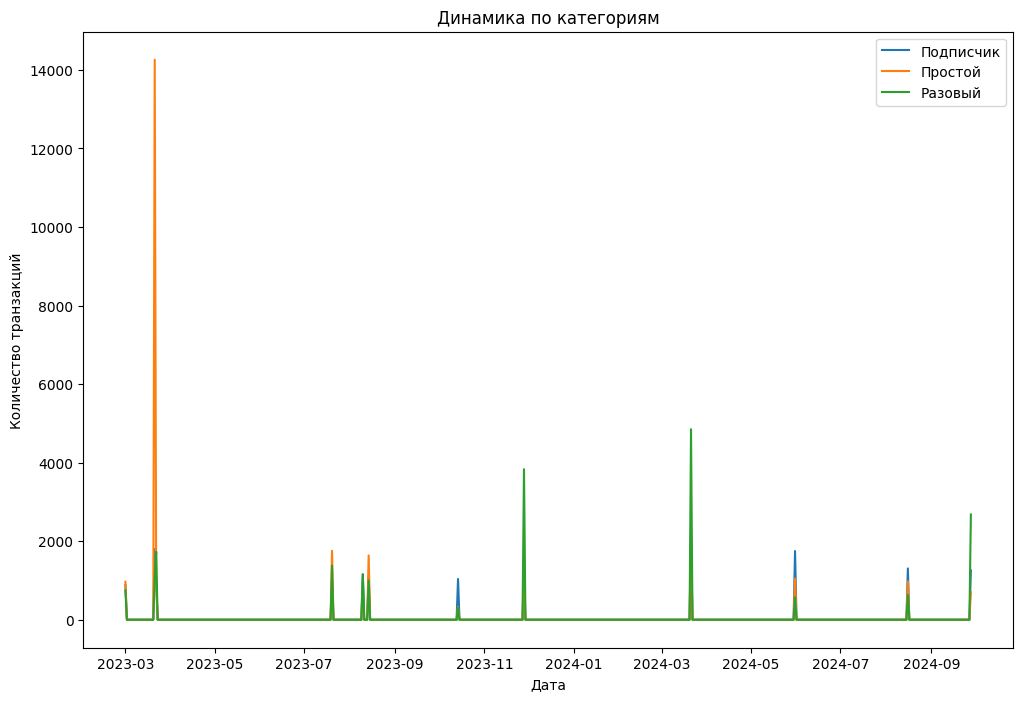

In [142]:
godday_tr = pd.DataFrame([])
fig = plt.figure(figsize=(12, 8))
for seg in ['Подписчик', 'Простой', 'Разовый']:
  dd = tranz.query('date.isin(@goddays) and type==@seg').groupby(['date']).agg({'id' : 'count', 'donate' : ['sum', 'mean'], 'user_id' : 'nunique'})
  dd.columns = ['tr_count', 'donate_sum', 'donate_mean', 'user_count']
  dd['seg'] = seg
  godday_tr = pd.concat([godday_tr, dd])
  date_range = pd.date_range(start=dd.index.min(), end=dd.index.max(), freq='D')
  dd = dd.reindex(date_range, fill_value=0)
  plt.plot(dd.index, dd['donate_mean'], label = seg)


plt.title(f'Динамика по категориям')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.legend()
plt.show()

Сравнительная таблица средних донатов по категориям в удачные дни

In [143]:
godday_donate_sum = godday_tr.pivot_table(index = 'date', columns = 'seg', values='donate_sum')
godday_donate_sum.index = godday_donate_sum.index.date
godday_donate_sum.loc['Среднее сборы в удачные дни'] = godday_donate_sum.mean(axis=0)
godday_donate_sum.loc['Среднее сборы в обычные дни'] = \
        tranz.query('~date.isin(@goddays)').groupby(['date', 'type'])['donate'].sum()\
              .groupby('type').mean()

godday_donate_sum.style.format('{:.0f}').background_gradient(\
        subset = pd.IndexSlice[godday_donate_sum.index.get_level_values(0)[:-2], :]
        , cmap='RdYlGn', axis=0)

Средние сборы в удачные дни выше, чем в обычные дни по всем категориям донаторов.

В удачные дни у простых пользователей сборы выше, чем у разовых, хотя в обычные дни разовые донаторы в среднем приносят больше.

## Cуммы отдельных донатов в категориях

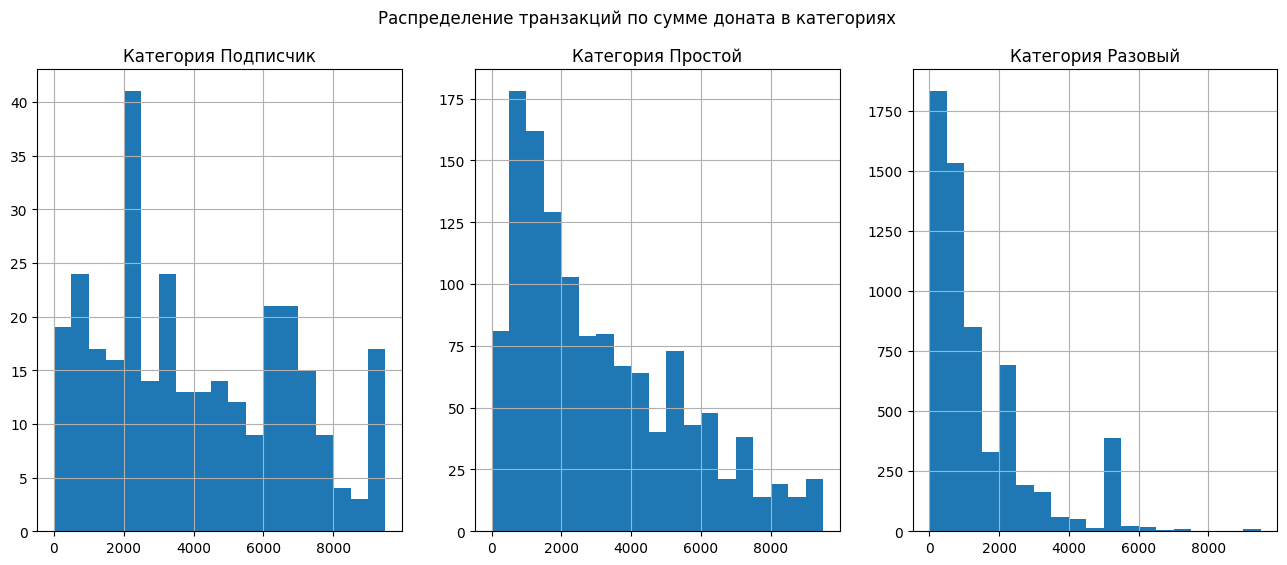

In [144]:
f, ax = plt.subplots(1, 3, figsize=(16, 6))
i = 0
for seg in ['Подписчик', 'Простой', 'Разовый']:
  user_table.query('type == @seg')['donate_sum'].hist(bins=range(0, 10000, 500), ax = ax[i])
  ax[i].set_title(f'Категория {seg}')
  i +=1
plt.suptitle(f'Распределение транзакций по сумме доната в категориях')
plt.show()

В категориях также есть различие по суммам донатов. У простых и разовых самые популярные донаты в 500–200 рублей. У попдисчиков суммы единичных донатов более разнообразны.
Пики на всех графиках соответствуют стандартным суммам, которые есть в форме оплаты доната по умолчанию.

## Время жизни в категориях

Оценим время жизни пользователей в категориях «Подписчик» и «Простой». При этом категорию разовых донаторов нет смысла брать — они живут 1 день. Корпоративную категорию также не рассматриваем.

In [145]:
dd = user_table.query('type == "Подписчик"')['day_on'].mean()
print(f'Среднее время жизни подписчика {dd:.0f} дней')
dd = user_table.query('type == "Простой"')['day_on'].mean()
print(f'Среднее время жизни простого донатора {dd:.0f} дней')

Среднее время жизни подписчика 479 дней
Среднее время жизни простого донатора 255 дней


Среднее время жизни подписчиков полтора года, а простых 8 месяцев.

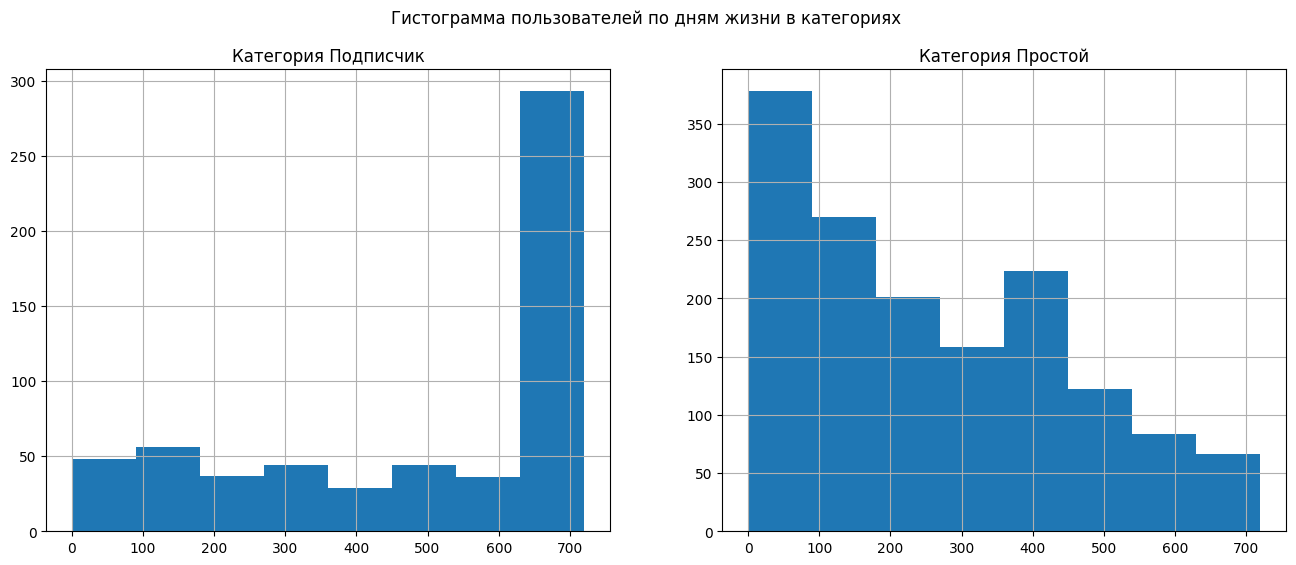

In [146]:
f, ax = plt.subplots(1, 2, figsize=(16, 6))
i = 0
for seg in ['Подписчик', 'Простой']:
  user_table.query('type == @seg')['day_on'].hist(bins=range(0, 800, 90), ax = ax[i])
  ax[i].set_title(f'Категория {seg}')
  i +=1
plt.suptitle(f'Гистограмма пользователей по дням жизни в категориях')
plt.show()

На гистограмме время жизни у подписчиков выглядит еще лучше: подавляющее большинство поддерживают фонд весь горизонт анализа — 2 года.

## Особые характеристики донатов в каждой из категорий

Посмотрим, как парпаметры транзакций характерные для отдельных категорий жертводателей

### Донаты от подписчиков

Оценим, делают ли подписчики еще донаты, кроме регулярных платежей по подписке.

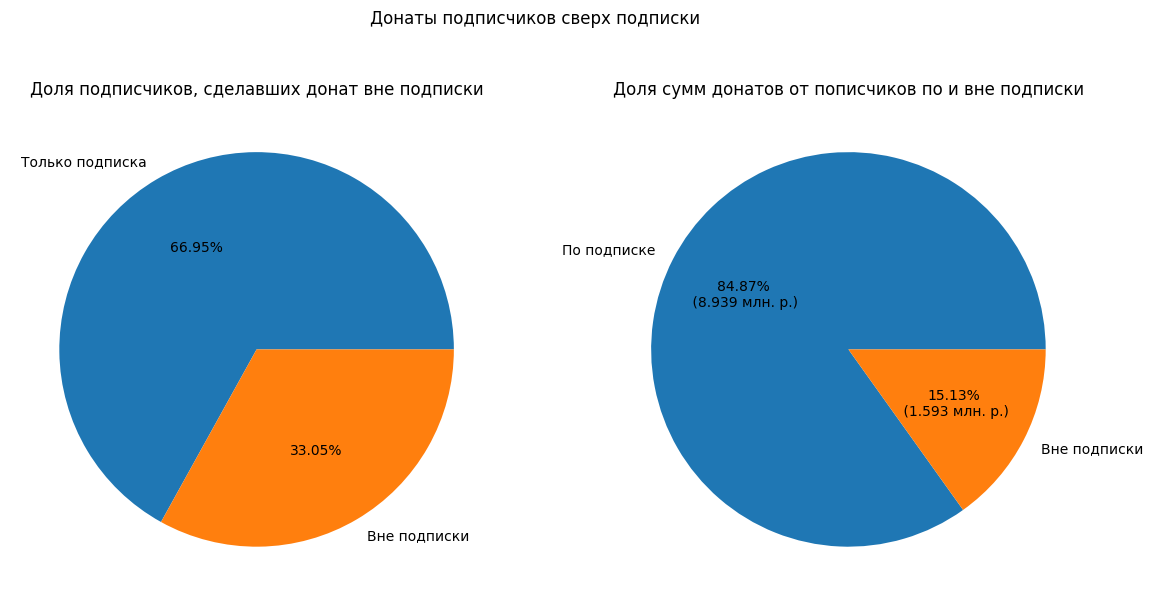

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
dd = tranz.query('type == "Подписчик" and ~code.str.contains("Регулярные")')['user_id'].nunique()
ax[0].pie(x = [len(subscr_users) - dd, dd],
        labels = ['Только подписка', 'Вне подписки'], autopct=lambda p : '{:.2f}%'.format(p))
ax[0].set_title('Доля подписчиков, сделавших донат вне подписки')

dd = [tranz.query('type == "Подписчик" and code.str.contains("Регулярные")')['donate'].sum(),
             tranz.query('type == "Подписчик" and ~code.str.contains("Регулярные")')['donate'].sum()]
ax[1].pie(x = dd, labels = ['По подписке', 'Вне подписки'],

          autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:,.3f} млн. р.)'.format(p*sum(dd)/10**8).replace(',', ' '))

ax[1].set_title('Доля сумм донатов от пописчиков по и вне подписки')

plt.suptitle('Донаты подписчиков сверх подписки')
plt.show()

Треть подписчиков делают дополнительные к регулярным донаты. 15% общей суммы донатов от подписчиков дается вне регулярных платежей. Хорошая прибавка к подписке. =)

Коды пожертвований подписчиков вне подписки

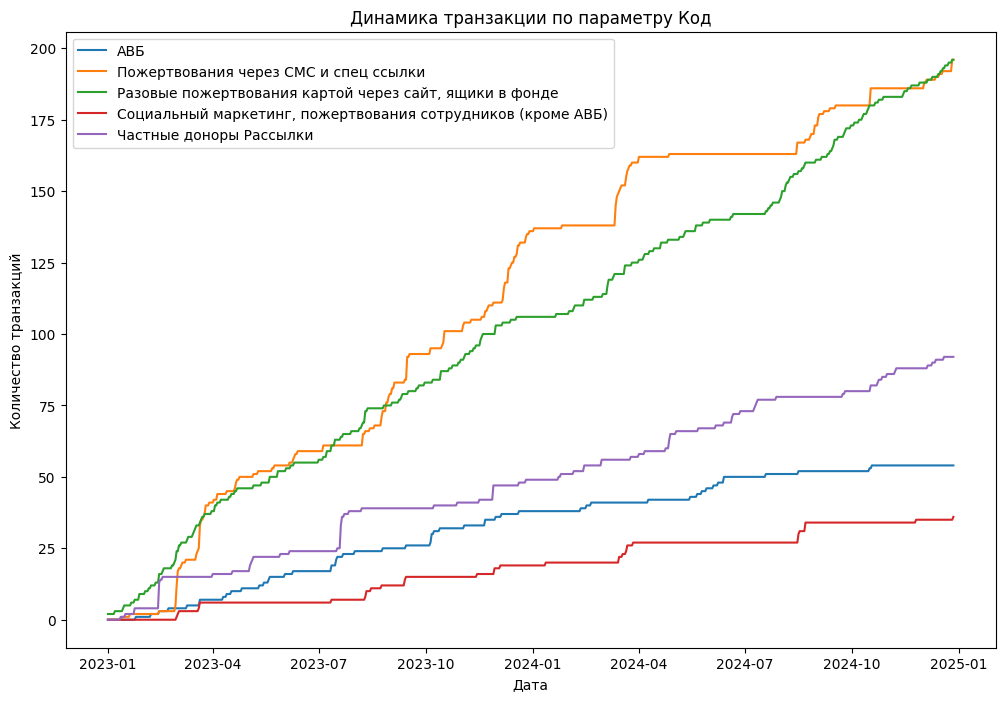

In [148]:
graf_dynamik_by_par(tranz.query('type == "Подписчик" and ~code.str.contains("Регулярные")'), 'code', 5, 'cumsum')

Как видно, подписчики довольно активно донатят и вне подписки. Наиболее частые транзакции с кодами пожертвование через СМС и разовые пожертвования через сайт

### Донаты от простых пользователей

In [149]:
simple_tr_mean = user_table.query('type == "Простой"')['tr_count'].mean()

print(f'Среднее количество транзакций у простого донатора {simple_tr_mean:.2f}')

Среднее количество транзакций у простого донатора 3.97


Гистограмма количества транзакций у простых донаторов

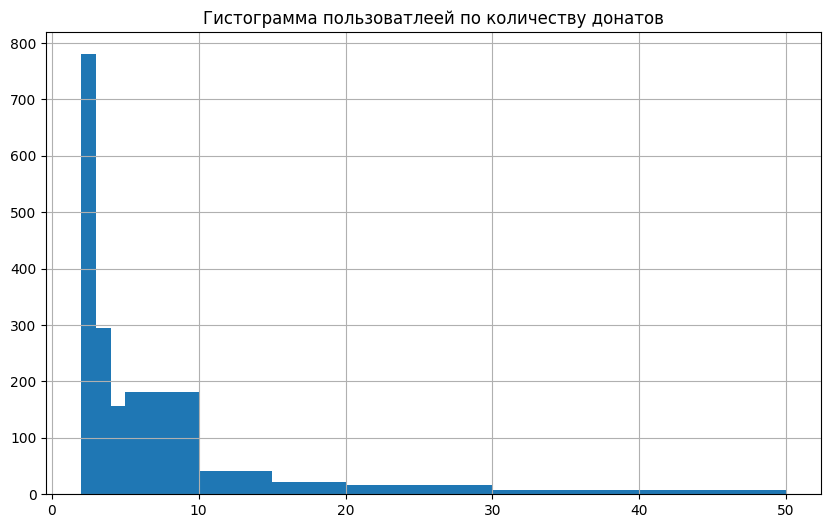

In [150]:
fig = plt.figure(figsize=(10,6))
user_table.query('type == "Простой"')['tr_count'].hist(bins = [2, 3, 4, 5, 10, 15, 20, 30, 50])
plt.title(f'Гистограмма пользоватлеей по количеству донатов')
plt.show()

Хотя среднее количество донатов среди простых пользователей почим 4, но гистограмма показывает, что большинство сделало только 2 доната, то есть очень близки к разовым донаторам.

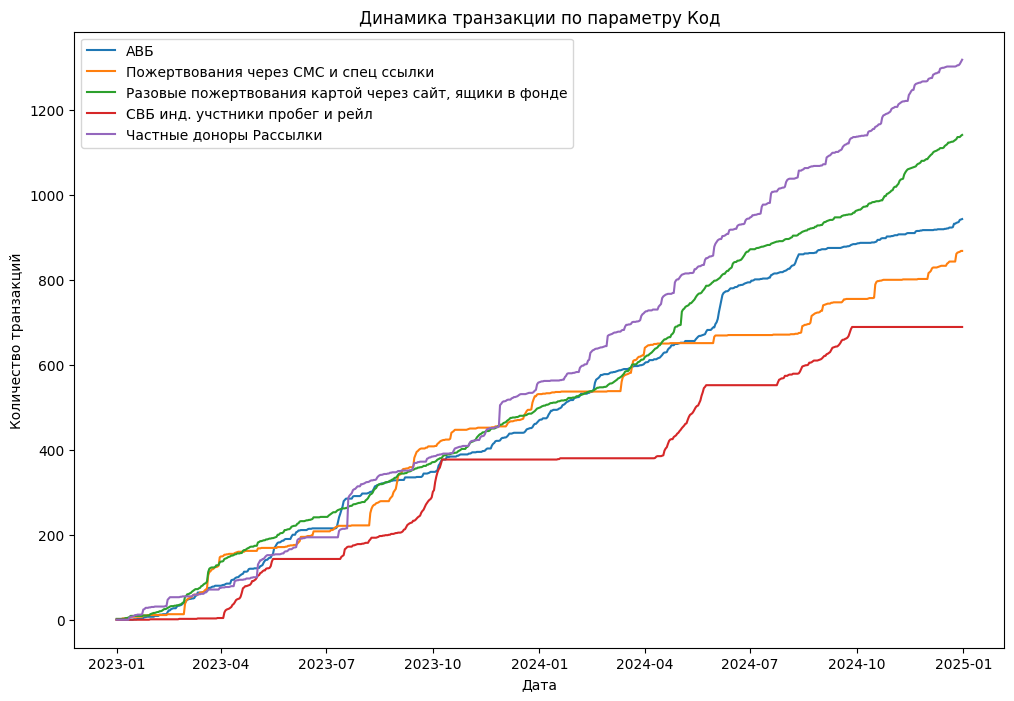

In [151]:
graf_dynamik_by_par(tranz.query('type == "Простой"'), 'code', 5, 'cumsum')

Простые пользователи чаще всего донатят по рассылке "Частные доноры", разовые пожертвования через сайт или СМС, Атлет во благо.

### Динамика разовых донатов по кодам

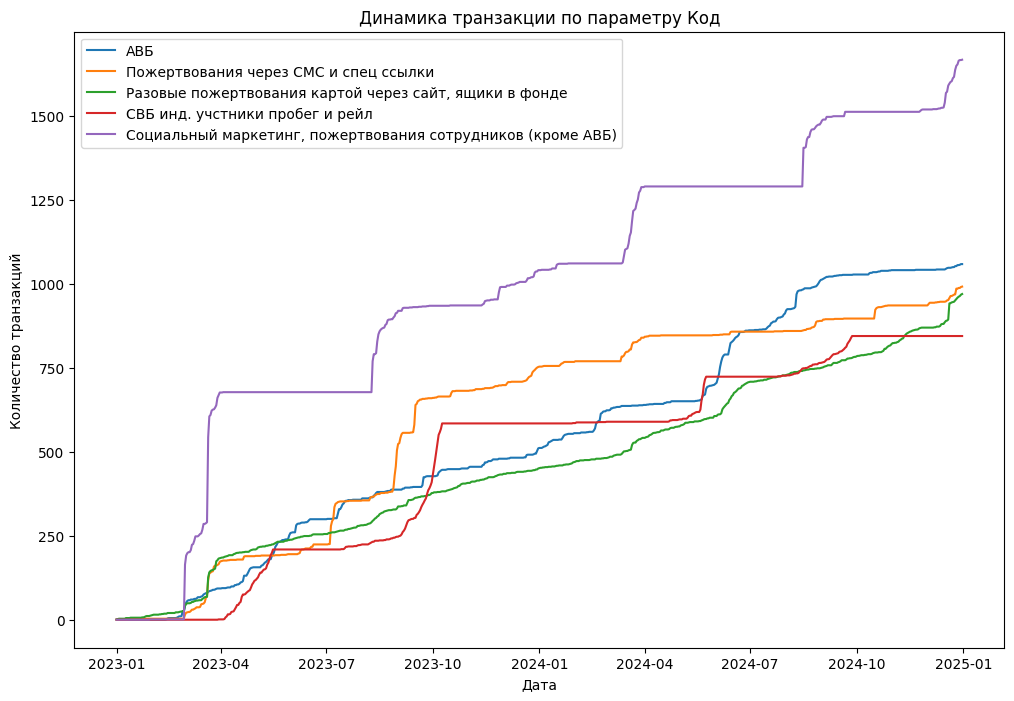

In [152]:
graf_dynamik_by_par(tranz.query('type == "Разовый"'), 'code', 5, 'cumsum')

У разовых донаторов чаще всего встречаются пожертвования от сотрудников, АВБ, пожертвования через СМС или сайт, ящики в фонде.

### Донаты от компаниий

In [153]:
comp_all = corp['comp_id'].nunique()
comp_tr = corp['id'].count()
comp_users = corp['user_id'].nunique()
comp_sum = corp['donate'].sum()

print(f"Общее количество компаний {comp_all}")
print(f"Общее количество пользователей из компаний {comp_users}")
print(f"Общее количество донатов из компаний {comp_tr}")
print(f"Общее сумма донатов из компаний {comp_sum:,.0f} руб.".replace(',', ' '))

Общее количество компаний 36
Общее количество пользователей из компаний 39
Общее количество донатов из компаний 176
Общее сумма донатов из компаний 23 566 798 руб.


Количество донатов от компании - мало, но по сумме они составляют приличную сумму.

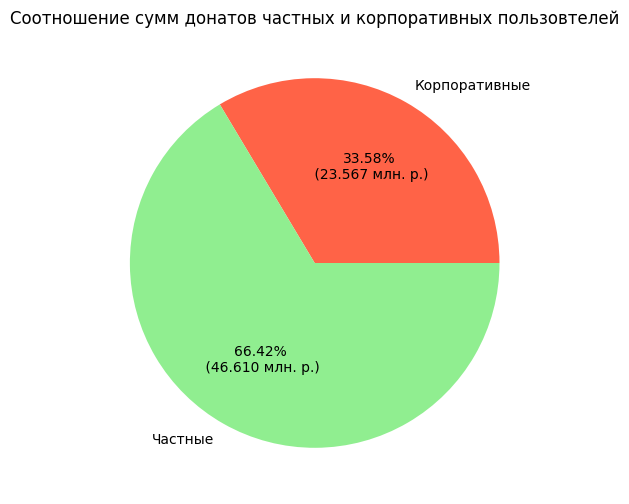

In [154]:
fig = plt.figure(figsize=(10, 6))
dd = [corp['donate'].sum(), tranz['donate'].sum()]
plt.pie(x = dd,
        labels = ['Корпоративные', 'Частные'], colors = ['tomato', 'lightgreen'],
        autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:,.3f} млн. р.)'.format(p*sum(dd)/10**8).replace(',', ' '))
plt.title('Соотношение сумм донатов частных и корпоративных пользовтелей')
plt.show()

Треть всех поступлений идет от компаний

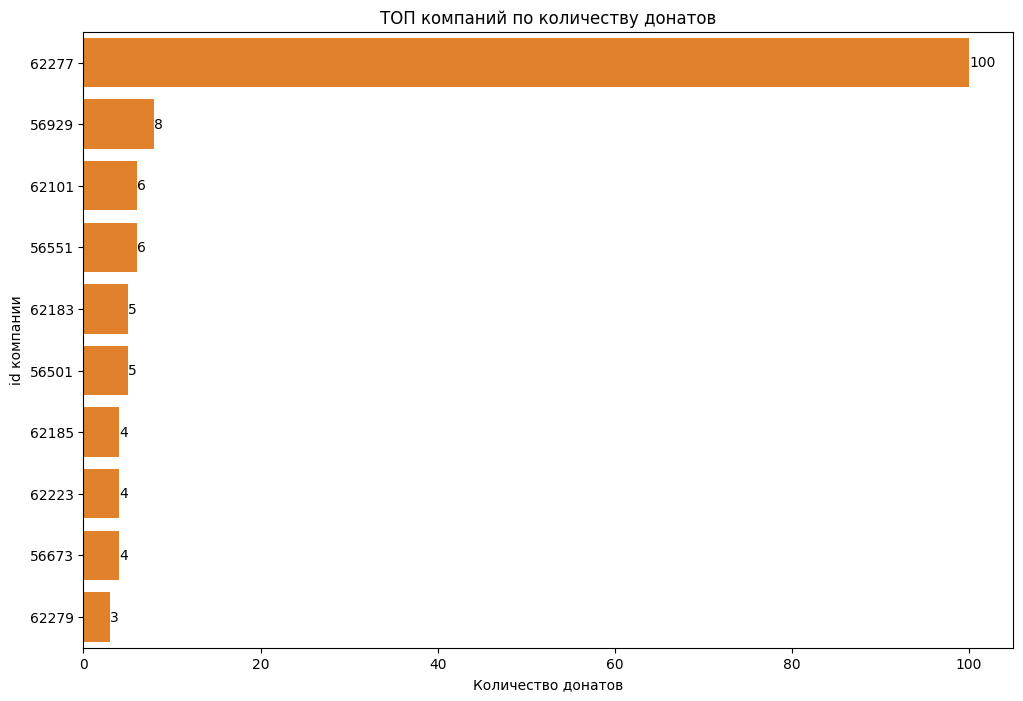

In [155]:
fig = plt.figure(figsize=(12, 8))
dd = corp.groupby('comp_id')['id'].count().sort_values().tail(10)[::-1]
dd.index = dd.index.map(str)
ax = sns.barplot(x=dd, y=dd.index, color='tab:orange')
ax.bar_label(ax.containers[0], fmt='{:,.0f}', fontsize=10, label_type='edge', color='black')
plt.title('ТОП компаний по количеству донатов')
plt.xlabel('Количество донатов')
plt.ylabel('id компании')
plt.show()

Как видно, в основном это разовые перечисления

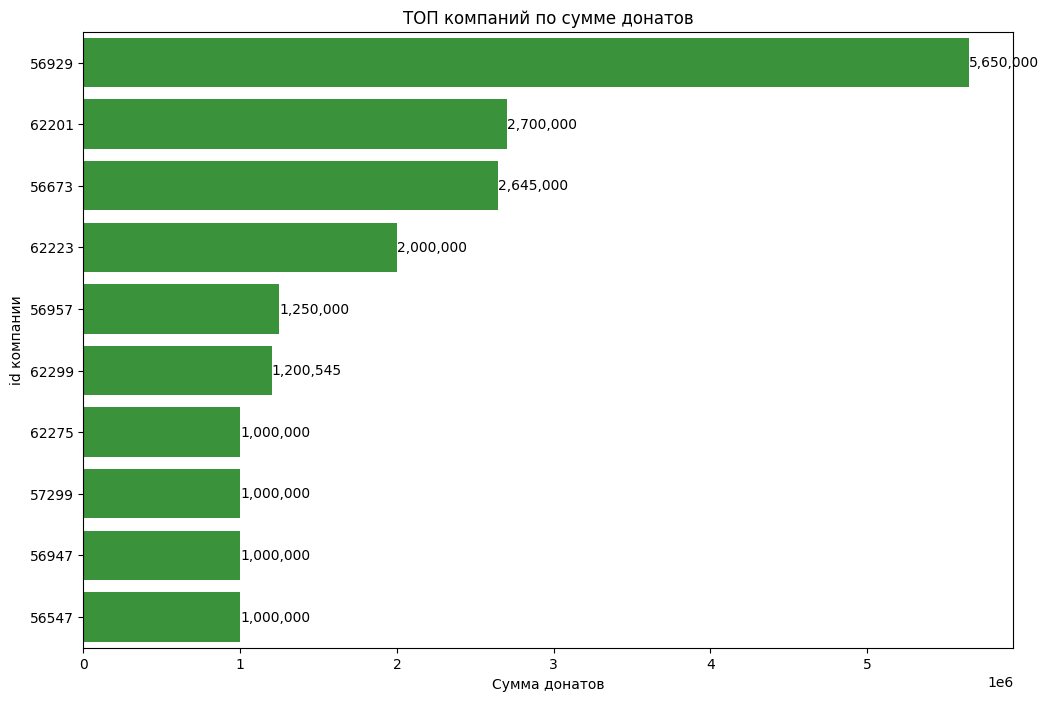

In [156]:
fig = plt.figure(figsize=(12, 8))
dd = corp.groupby('comp_id')['donate'].sum().sort_values().tail(10)[::-1]
dd.index = dd.index.map(str)
ax = sns.barplot(x=dd, y=dd.index, color='tab:green')
ax.bar_label(ax.containers[0], fmt='{:,.0f}', fontsize=10, label_type='edge', color='black')
plt.title('ТОП компаний по сумме донатов')
plt.xlabel('Сумма донатов')
plt.ylabel('id компании')
plt.show()

Динамика донатов от самых щедрых компаний

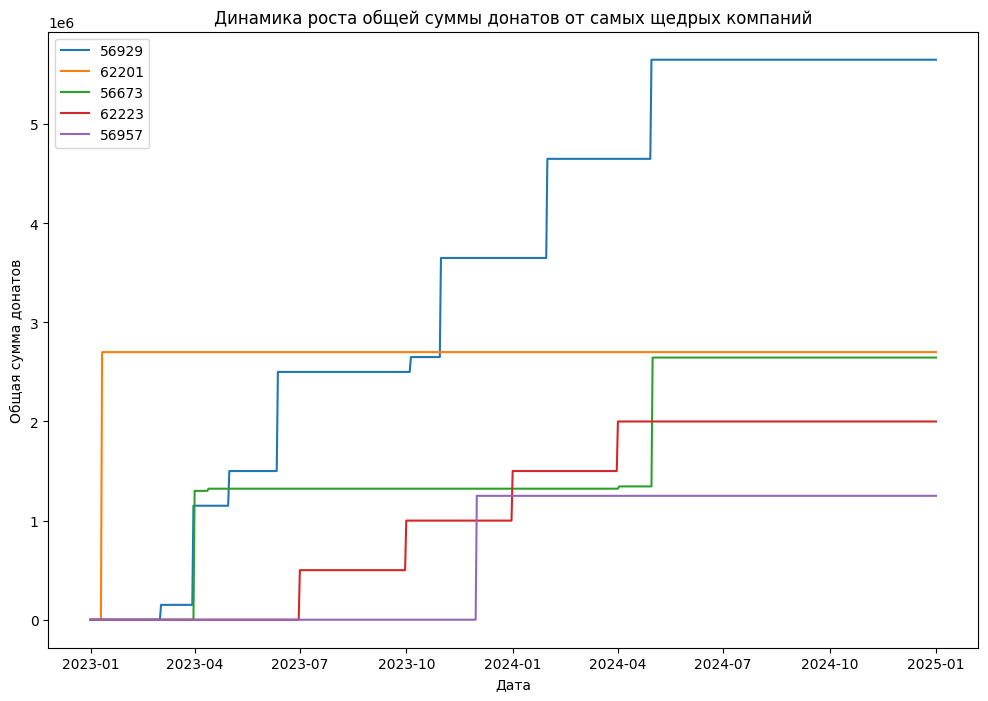

In [157]:
fig = plt.figure(figsize=(12, 8))
corp_top5 = corp.groupby('comp_id')['donate'].sum().sort_values().tail(5)[::-1]
for seg in corp_top5.index:
  dd = corp.query('comp_id == @seg').groupby('date')['donate'].sum().to_frame()
  date_range = pd.date_range(start='2023.01.01', end='2025.01.01', freq='D')
  dd = dd.reindex(date_range, fill_value=0)
  dd['donate_cumsum'] = dd['donate'].cumsum()
  plt.plot(dd.index, dd['donate_cumsum'], label = seg)

plt.title(f'Динамика роста общей суммы донатов от самых щедрых компаний')
plt.xlabel('Дата')
plt.ylabel('Общая сумма донатов')
plt.legend()
plt.show()

На корпоративные донаты приходится треть всей собранной суммы. Однако это разовые платежи - всего 178 транзакций за 2 года. Самые щедные компаний жертвовали либо один раз сразу большую суммы, либо делали 4-7 больших донатов

**Промежуточный итог**

Отдельным категорий жертводателей соответствуют разные парпаметры транзакций. Подписчики часто донатят не только по подписке, но и разовыми донатами по акциям.

## RFM анализ отдельных категорий донаторов

Проведен RFM-анализ отдельно по категориям. Ключевым тут будет определение границ рангов. Принцип определения рангов остается такой же — чтобы в каждом ранге было примерно одинаковое количество пользователей. В каждой категории границы будут свои.

### Подписчики

Определяем границ рангов для RFM анализа

In [158]:
uuu = get_user_table(tranz.query('type=="Подписчик"'))
uuu[['donate_sum', 'oper_frec', 'day_last']].quantile([0.01, 0.25, 0.33, 0.5, 0.66, 0.75, 0.99])

donate_sum  oper_frec  day_last
0.01      200.00       0.27      1.00
0.25     3300.00       0.87     17.00
0.33     4800.00       0.91     20.00
0.50     9000.00       0.96     31.00
0.66    13000.00       1.00     44.00
0.75    20000.00       1.00    101.00
0.99   160000.00       2.15    692.66

In [159]:
subscr_table = get_rfm_table(tranz.query('type == "Подписчик"'), [20, 60, 1.1, 0.9, 13000, 5300])
subscr_table

R  F  M  RFM  rfm_users  rfm_tr    rfm_sum
0   1  1  1  111         11     422  480103.00
1   1  1  2  112          3      85   27700.00
2   1  1  3  113          5      53   13393.00
3   1  2  1  121         45     919 2776070.02
4   1  2  2  122         50     959  440108.02
5   1  2  3  123         22     281   50000.00
6   1  3  1  131         17     257  545520.00
7   1  3  2  132         17     254  158160.00
8   1  3  3  133         21     213   53285.00
9   2  1  1  211         12     400  592530.00
10  2  1  2  212          5     163   47209.00
11  2  1  3  213          4      74   13180.00
12  2  2  1  221         70    1543 2396505.00
13  2  2  2  222         56    1186  531200.00
14  2  2  3  223         28     499   84520.00
15  2  3  1  231         11     172  339990.00
16  2  3  2  232         16     229  142710.00
17  2  3  3  233         17     170   49660.00
18  3  1  1  311          4      94  121870.00
19  3  1  2  312          6      93   52418.00
20  3  1  3  313          5      15    5100.00
21  3  2  1  321         11     147  615900.00
22  3  2  2  322         15     197  121600.00
23  3  2  3  323         69     326  120588.00
24  3  3  1  331         14     143  496500.00
25  3  3  2  332         20     181  165662.00
26  3  3  3  333         33     213   90330.00

In [160]:
#subscr_table.to_csv('subscr_rfm_table.csv')

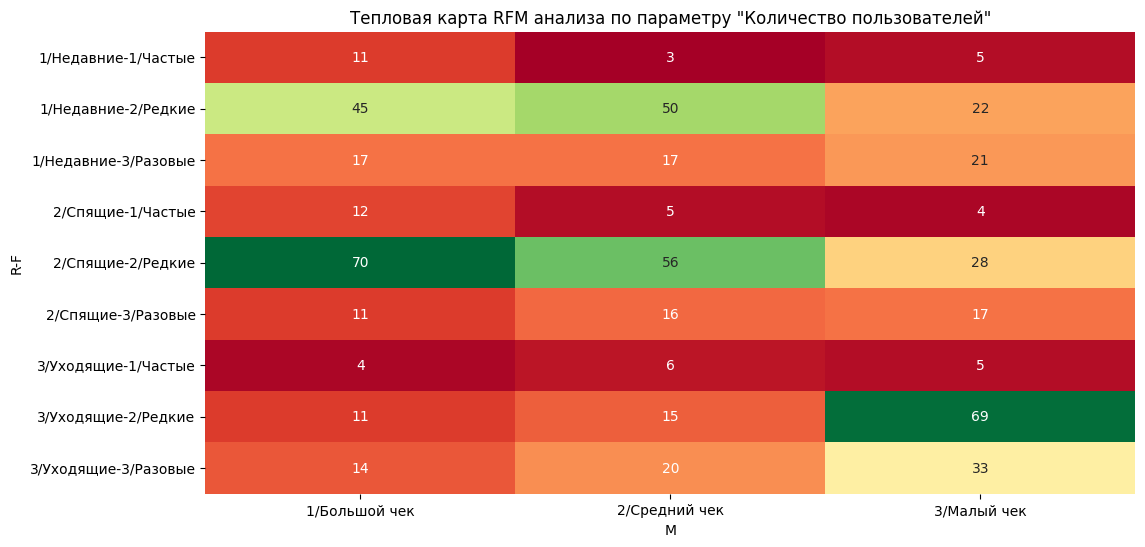

In [161]:
show_rfm_table_sns(subscr_table, 'rfm_users')

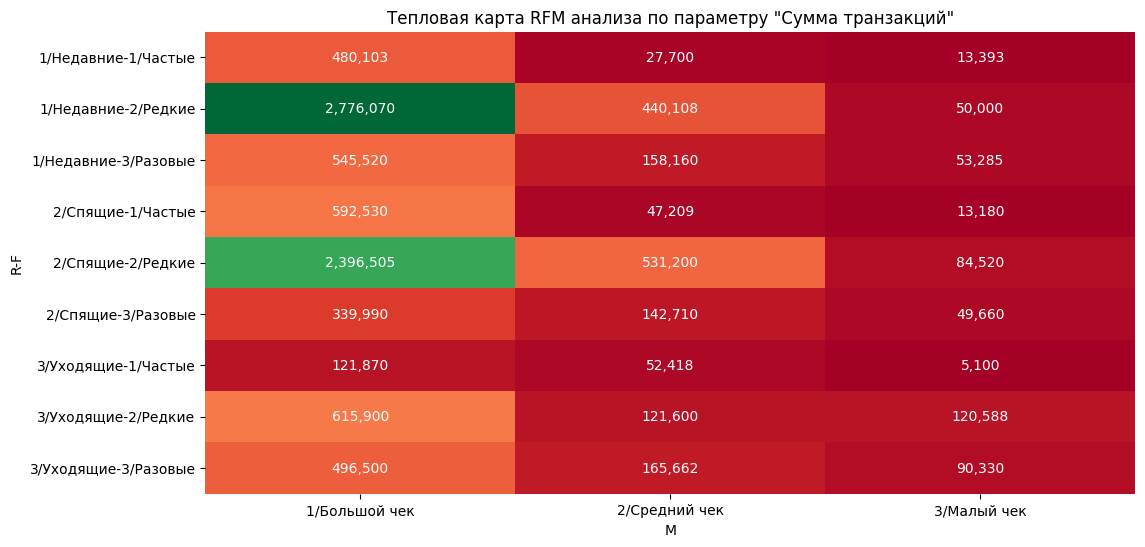

In [162]:
show_rfm_table_sns(subscr_table, 'rfm_sum')

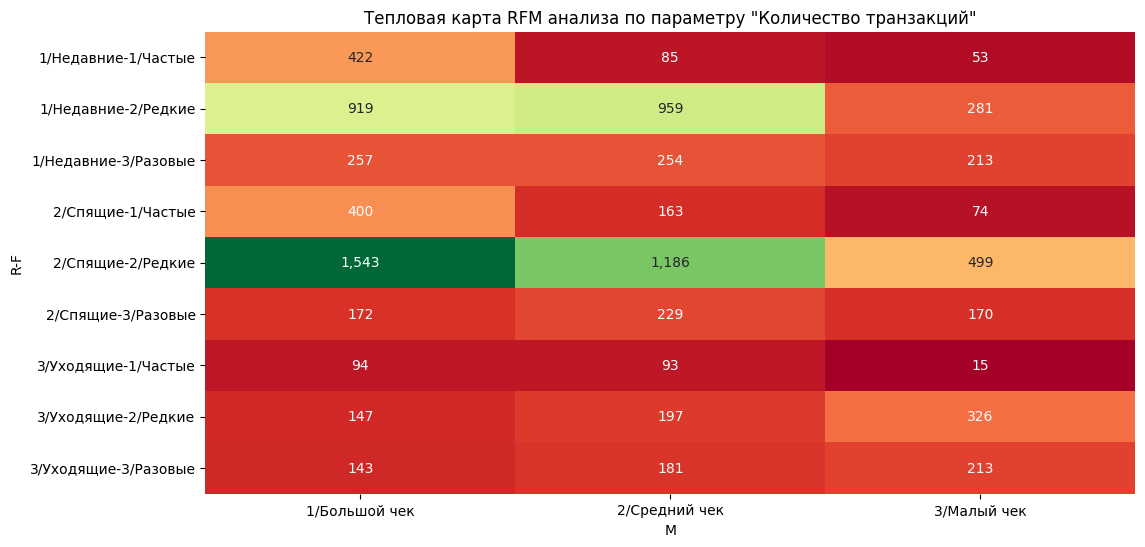

In [163]:
show_rfm_table_sns(subscr_table, 'rfm_tr')

In [164]:
dd = subscr_table.query("RFM.isin(['221', '121', '122', '222'])")[['RFM', 'rfm_users', 'rfm_tr', 'rfm_sum']]
dd.loc['sum'] = dd[['rfm_users', 'rfm_tr', 'rfm_sum']].sum()
dd

RFM  rfm_users  rfm_tr    rfm_sum
3    121      45.00  919.00 2776070.02
4    122      50.00  959.00  440108.02
12   221      70.00 1543.00 2396505.00
13   222      56.00 1186.00  531200.00
sum  NaN     221.00 4607.00 6143883.04

Наибольшее количество подписчиков в сегментах 221, 323, 222, 122, 121.
Наибольшее количество транзакций делают подписчики из сегментов 221, 222, 121, 122.
Самые ценные сегменты по сумме донатов: 121 и 221.

Итого наиболее ценные сегменты среди подписчиков - 221, 121, 122, 222
Всего вних 221 подписчиков, которые сделали 4600 донатов на общую сумму 6.1 млн рублей.

### Простые донаторы

In [165]:
uuu = get_user_table(tranz.query('type=="Простой"'))
uuu[['donate_sum', 'oper_frec', 'day_last']].quantile([0.01, 0.25, 0.33, 0.5, 0.66, 0.75, 0.99])

donate_sum  oper_frec  day_last
0.01      200.00       0.10      1.00
0.25     1280.00       0.25     94.00
0.33     1710.00       0.29    120.00
0.50     3000.00       0.40    214.00
0.66     5000.00       0.67    287.00
0.75     6060.00       1.00    369.00
0.99   119920.00       3.00    648.88

In [166]:
simple_rfm = get_rfm_table(tranz.query('type =="Простой"'), [120, 240, 1.1, 0.3, 5000, 1700])
simple_rfm

R  F  M  RFM  rfm_users  rfm_tr    rfm_sum
0   1  1  1  111         21     417  522670.00
1   1  1  2  112         19     109   66156.00
2   1  1  3  113         35     101   24462.00
3   1  2  1  121        104     938 4793409.22
4   1  2  2  122         45     308  148100.00
5   1  2  3  123         43     160   39701.00
6   1  3  1  131         89     297 3275247.00
7   1  3  2  132         79     253  262200.00
8   1  3  3  133         51     132   56653.00
9   2  1  1  211         16     325 1540734.00
10  2  1  2  212         14      43   39865.00
11  2  1  3  213         18      56   17495.00
12  2  2  1  221         50     300  948107.00
13  2  2  2  222         43     156  133245.00
14  2  2  3  223         47     127   35514.00
15  2  3  1  231         46     145  452460.98
16  2  3  2  232         65     158  205030.00
17  2  3  3  233         45      99   41925.00
18  3  1  1  311         21      68  911858.00
19  3  1  2  312         53     166  155408.00
20  3  1  3  313         52     122   50725.00
21  3  2  1  321        103     367 2654525.22
22  3  2  2  322        133     393  399878.00
23  3  2  3  323        132     310  116534.00
24  3  3  1  331         39      96  471576.00
25  3  3  2  332         68     163  213927.00
26  3  3  3  333         72     155   69368.00

In [167]:
#simple_rfm.to_csv('simple_rfm.csv')

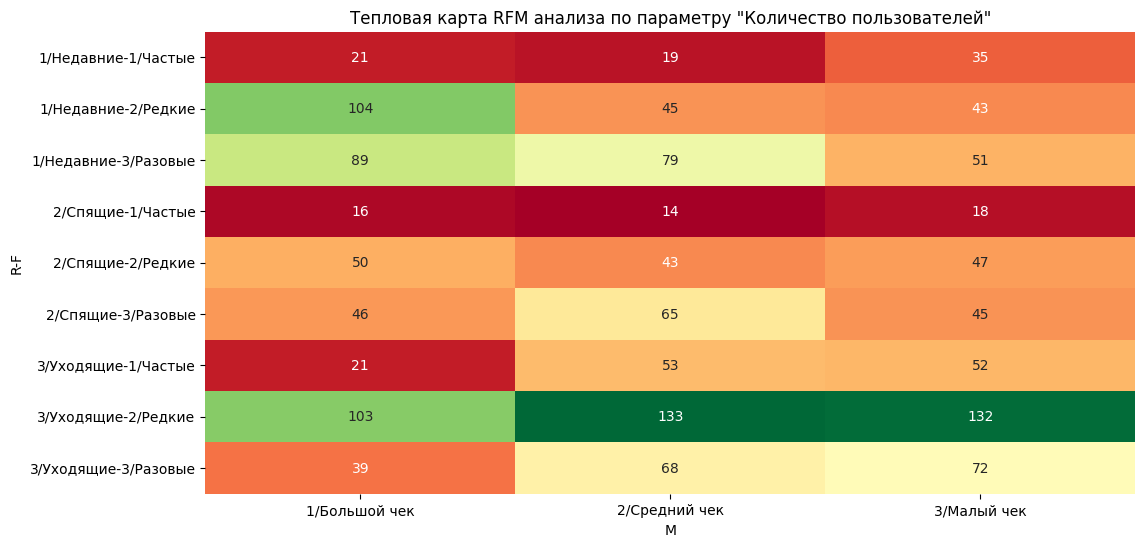

In [168]:
show_rfm_table_sns(simple_rfm, 'rfm_users')

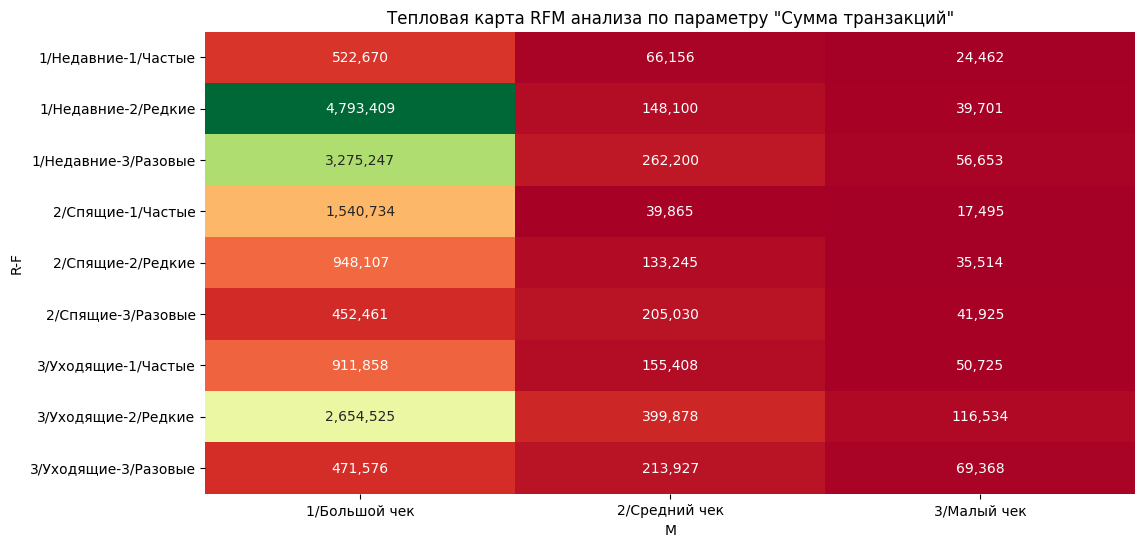

In [169]:
show_rfm_table_sns(simple_rfm, 'rfm_sum')

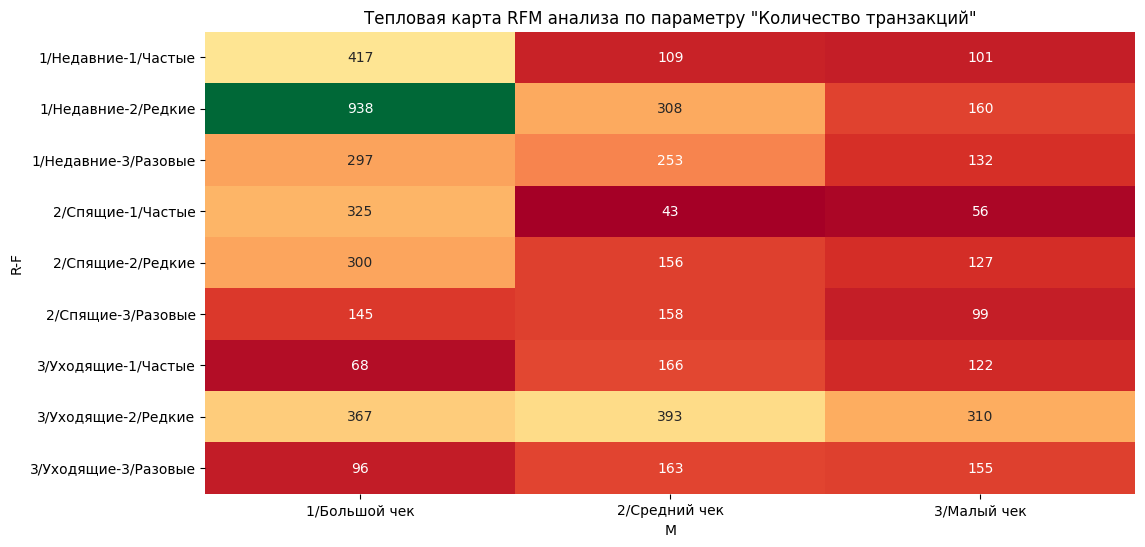

In [170]:

show_rfm_table_sns(simple_rfm, 'rfm_tr')

Лучшие сегменты

In [171]:
dd = simple_rfm.query("RFM.isin(['121', '131'])")[['RFM', 'rfm_users', 'rfm_tr', 'rfm_sum']]
dd.loc['sum'] = dd[['rfm_users', 'rfm_tr', 'rfm_sum']].sum()
dd

RFM  rfm_users  rfm_tr    rfm_sum
3    121     104.00  938.00 4793409.22
6    131      89.00  297.00 3275247.00
sum  NaN     193.00 1235.00 8068656.22

Худшие сегменты

In [172]:
dd = simple_rfm.query("RFM.isin(['322', '323', '321'])")[['RFM', 'rfm_users', 'rfm_tr', 'rfm_sum']]
dd.loc['sum'] = dd[['rfm_users', 'rfm_tr', 'rfm_sum']].sum()
dd

RFM  rfm_users  rfm_tr    rfm_sum
21   321     103.00  367.00 2654525.22
22   322     133.00  393.00  399878.00
23   323     132.00  310.00  116534.00
sum  NaN     368.00 1070.00 3170937.22

Наибольшее количество простых донаторов в сегментах 322, 323, 121, 321.
Наибольшее количество транзакций делают простые донаторы из сегментов 121
Самые ценные сегменты по сумме донатов: 121, 131

Итого наиболее ценные сегменты среди подписчиков - 121, 131
Всего вних 193 человека, которые сделали 1235 донатов на общую сумму 8 млн рублей.

Проблемные сегменты - 322, 323, 321
В них "уходящие" 368 человек, которые редко делали донаты на небольшие суммы.

## Когортный анализ отдельных категорий донаторов

### Когортный анализ подписчиков

In [173]:
subscr_chogort_table = get_chogort_table(tranz.query('type == "Подписчик"'))
subscr_chogort_table.head(5)

tr_mon  user_count  tr_count  donate_sum  tr_y  tr_m       ch  m_live  \
0       1         267       281   234922.00  2023     1  2023_01       1   
1       2         249       275   227789.00  2023     2  2023_01       2   
2       3         242       284   236104.00  2023     3  2023_01       3   
3       4         238       262   232733.00  2023     4  2023_01       4   
4       5         234       255   226623.00  2023     5  2023_01       5   

         ltv     ltv_m     rr   cr  
0  234922.00 234922.00 100.00 1.00  
1  462711.00 231356.00  93.26 0.93  
2  698815.00 232938.00  90.64 0.97  
3  931548.00 232887.00  89.14 0.98  
4 1158171.00 231634.00  87.64 0.98

In [174]:
subscr_chogort_table.to_csv('subscr_chogort_table.csv')

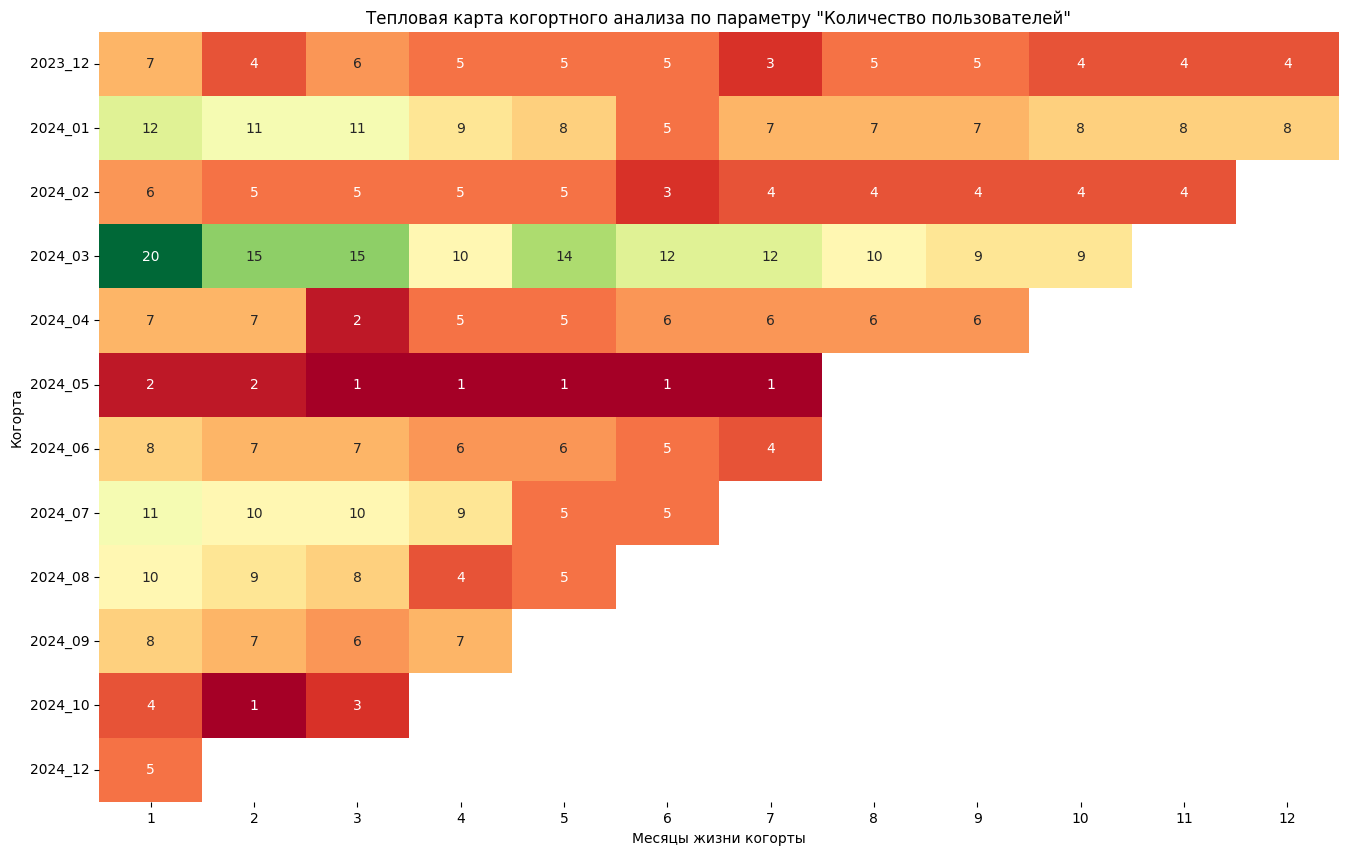

In [175]:
show_chogort_table_sns(subscr_chogort_table, col='user_count', ml=12)

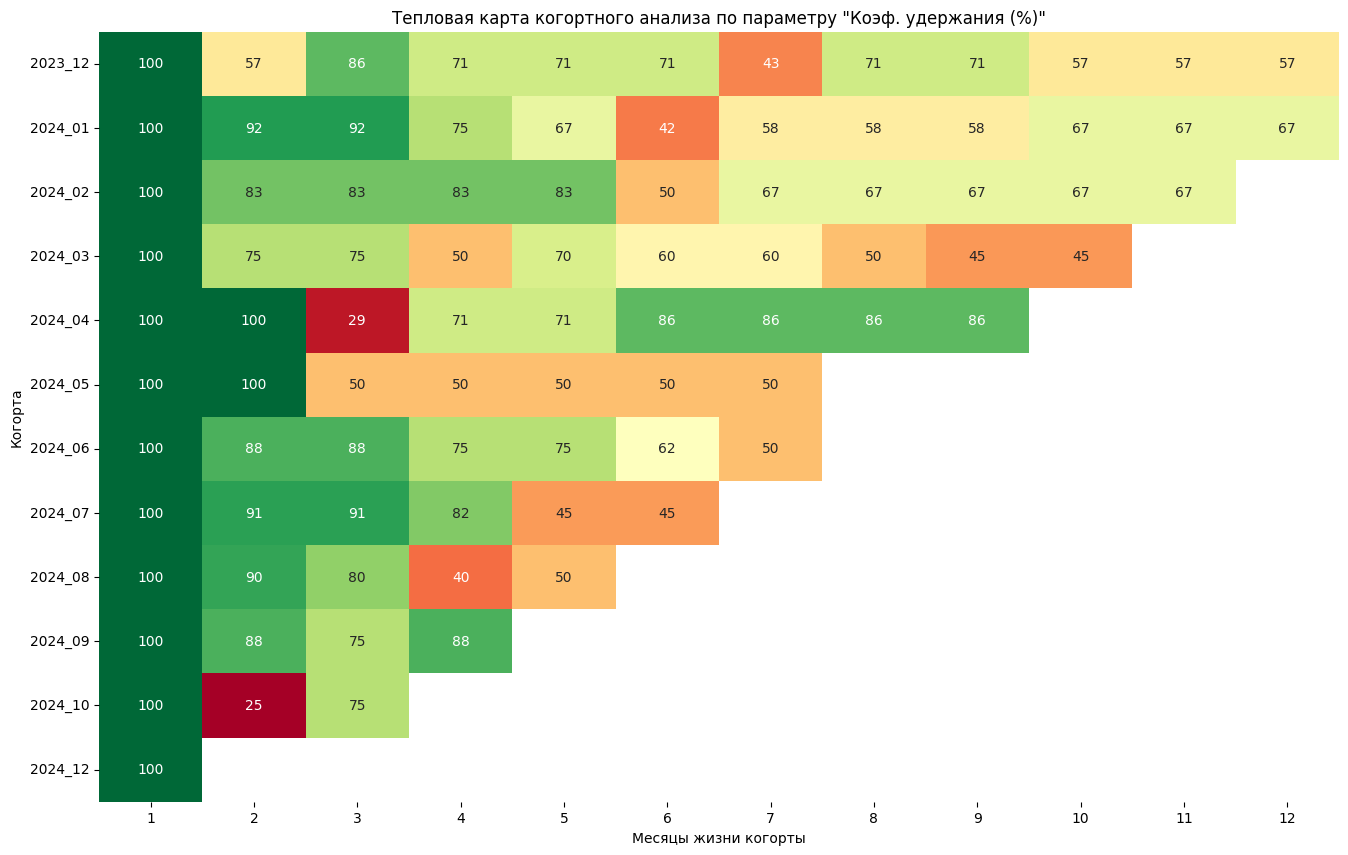

In [176]:
show_chogort_table_sns(subscr_chogort_table, col='rr', ml=12)

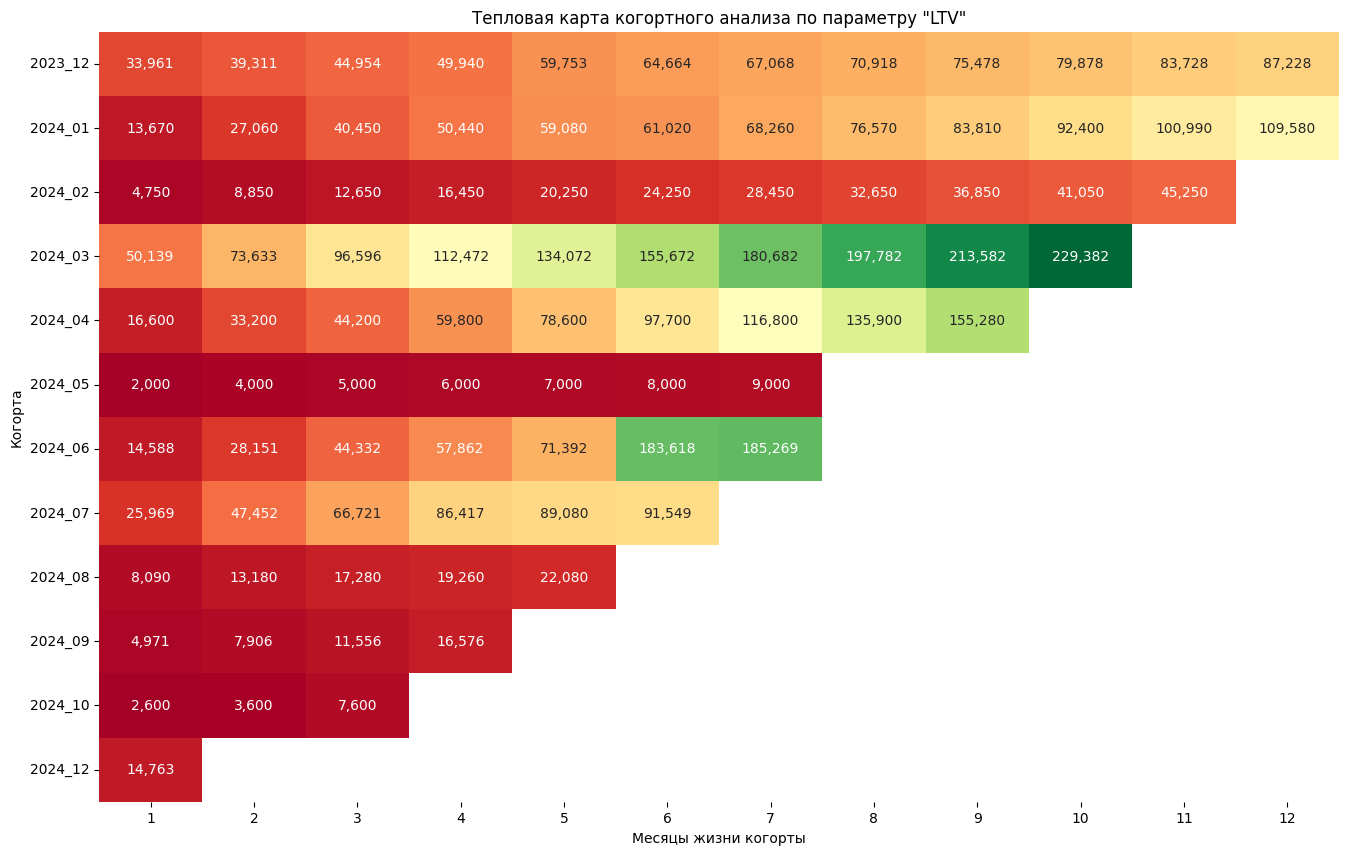

In [177]:
show_chogort_table_sns(subscr_chogort_table, col='ltv', ml=12)

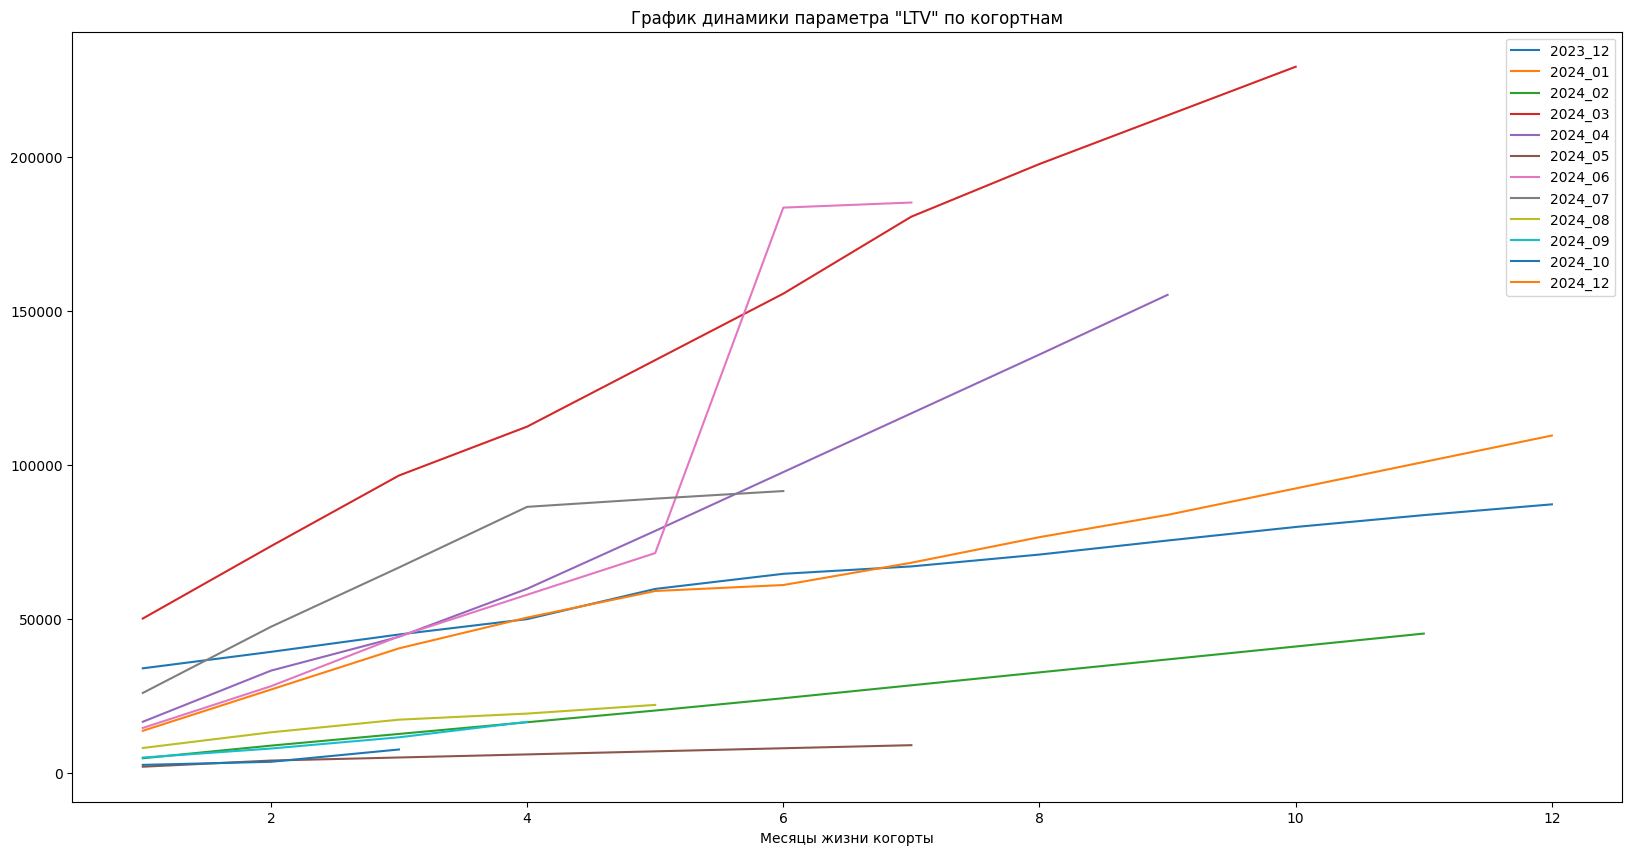

In [178]:
graf_chogort(subscr_chogort_table, col='ltv', ml=12)

Общие тренды
- Снижение Retention Rate (RR) с течением времени: Большинство когорт теряют около 50-70% пользователей за год.
- У многих когорт LTV_m стабилизируется после 6-12 месяцев: Основной доход генерируется в первые 6 месяцев.

Успешные когорты
- Когорта 2023_03: LTV: 2.02 млн руб. за 22 месяца. Высокий RR: 76.67% на 13-м месяце.

Проблемные когорты
- Когорта 2023_06: Низкий RR: 50% на 12-м месяце.
- Когорта 2024_05: Всего 2 пользователя. Возможно, был технический сбоой.


### Когортный анализ по простых донаторам

In [179]:
simple_chogort_table = get_chogort_table(tranz.query('type == "Простой"'))
simple_chogort_table.head(5)

tr_mon  user_count  tr_count  donate_sum  tr_y  tr_m       ch  m_live  \
0       1          61        71   210399.00  2023     1  2023_01       1   
1       2          19        21    50600.00  2023     2  2023_01       2   
2       3          35        61   108890.00  2023     3  2023_01       3   
3       4          22        28    28310.00  2023     4  2023_01       4   
4       5          23        30   116187.00  2023     5  2023_01       5   

        ltv     ltv_m     rr   cr  
0 210399.00 210399.00 100.00 1.00  
1 260999.00 130500.00  31.15 0.31  
2 369889.00 123296.00  57.38 1.84  
3 398199.00  99550.00  36.07 0.63  
4 514386.00 102877.00  37.70 1.05

In [180]:
#simple_chogort_table.to_csv('simple_chogort_table.csv')

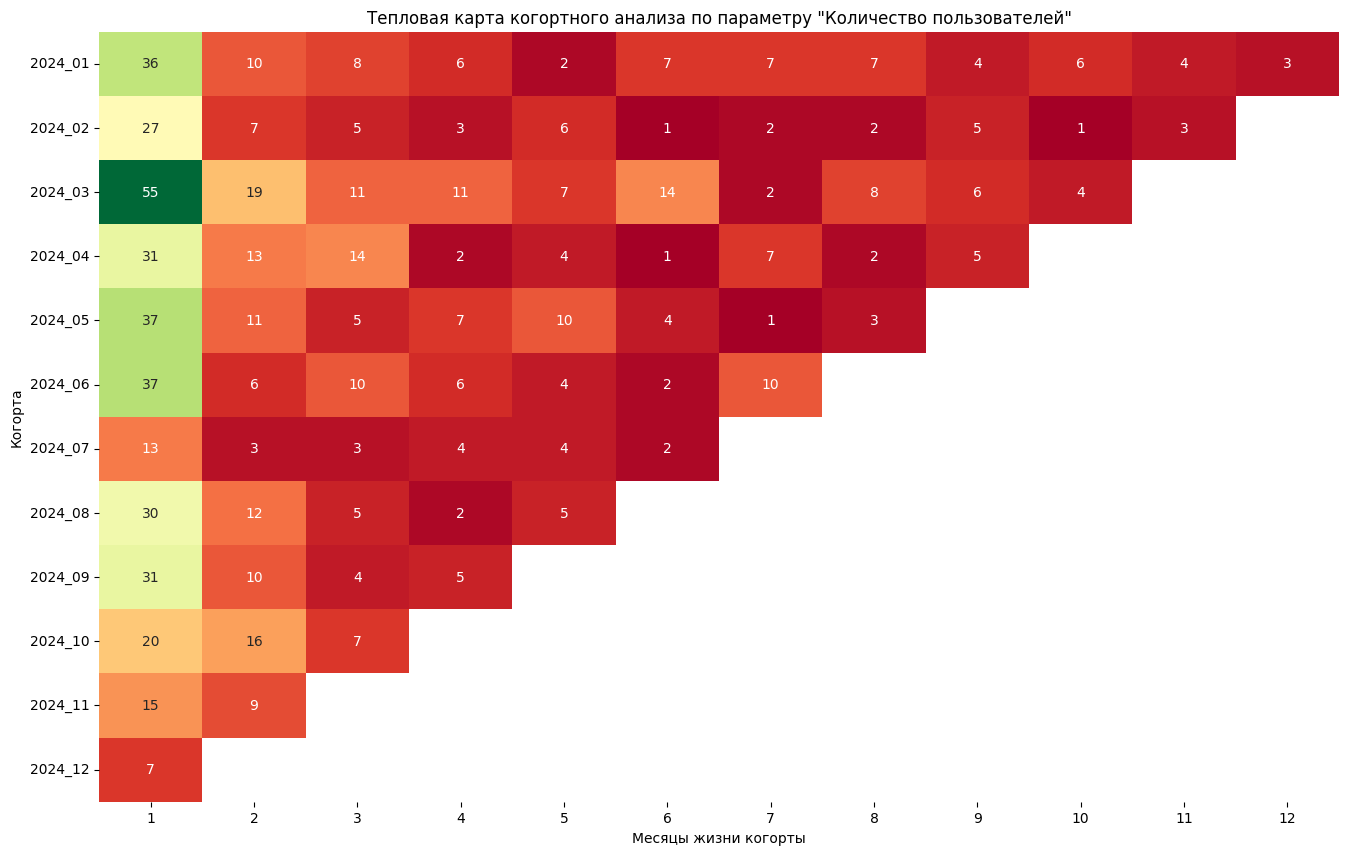

In [181]:
show_chogort_table_sns(simple_chogort_table, col='user_count', ml=12)

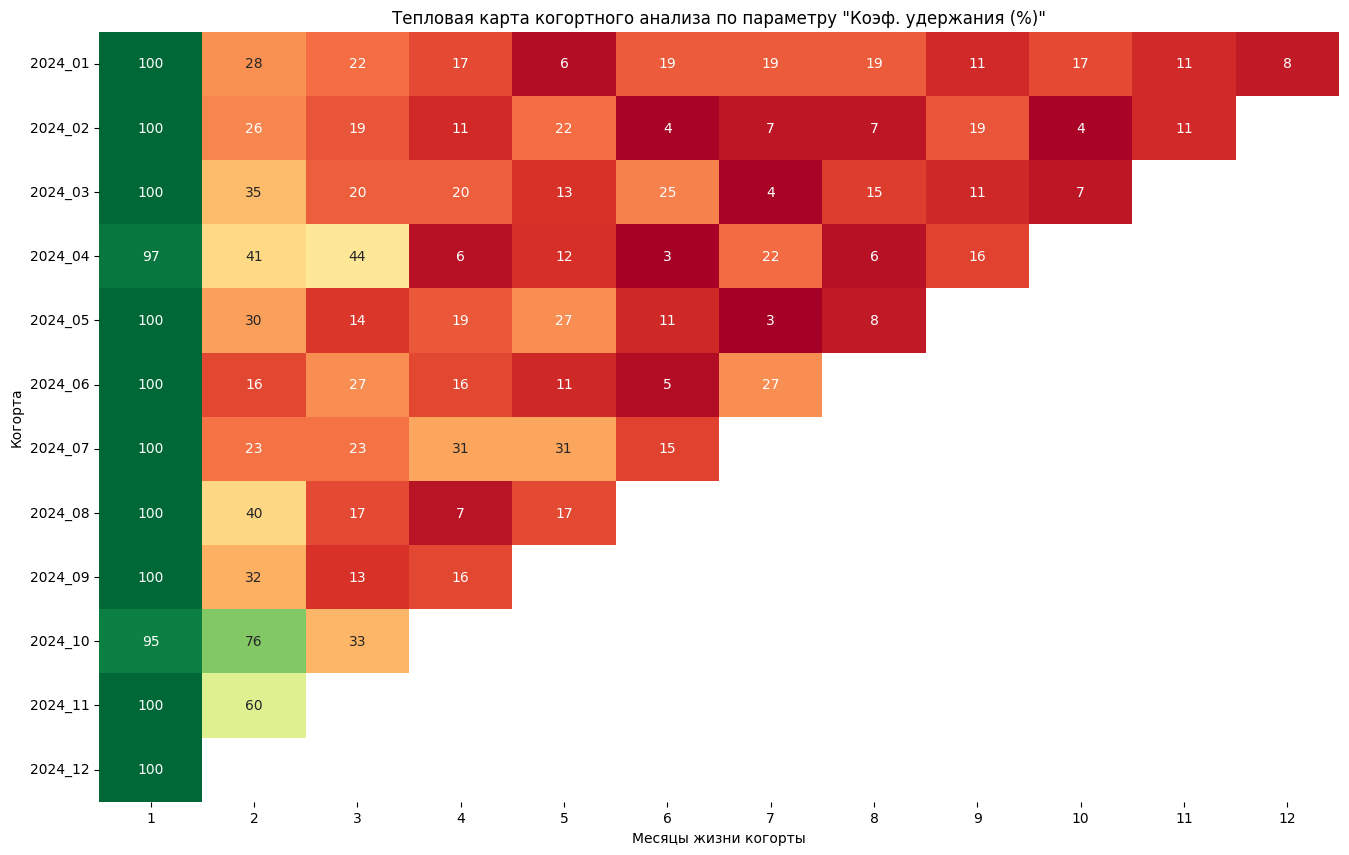

In [182]:
show_chogort_table_sns(simple_chogort_table, col='rr', ml=12)

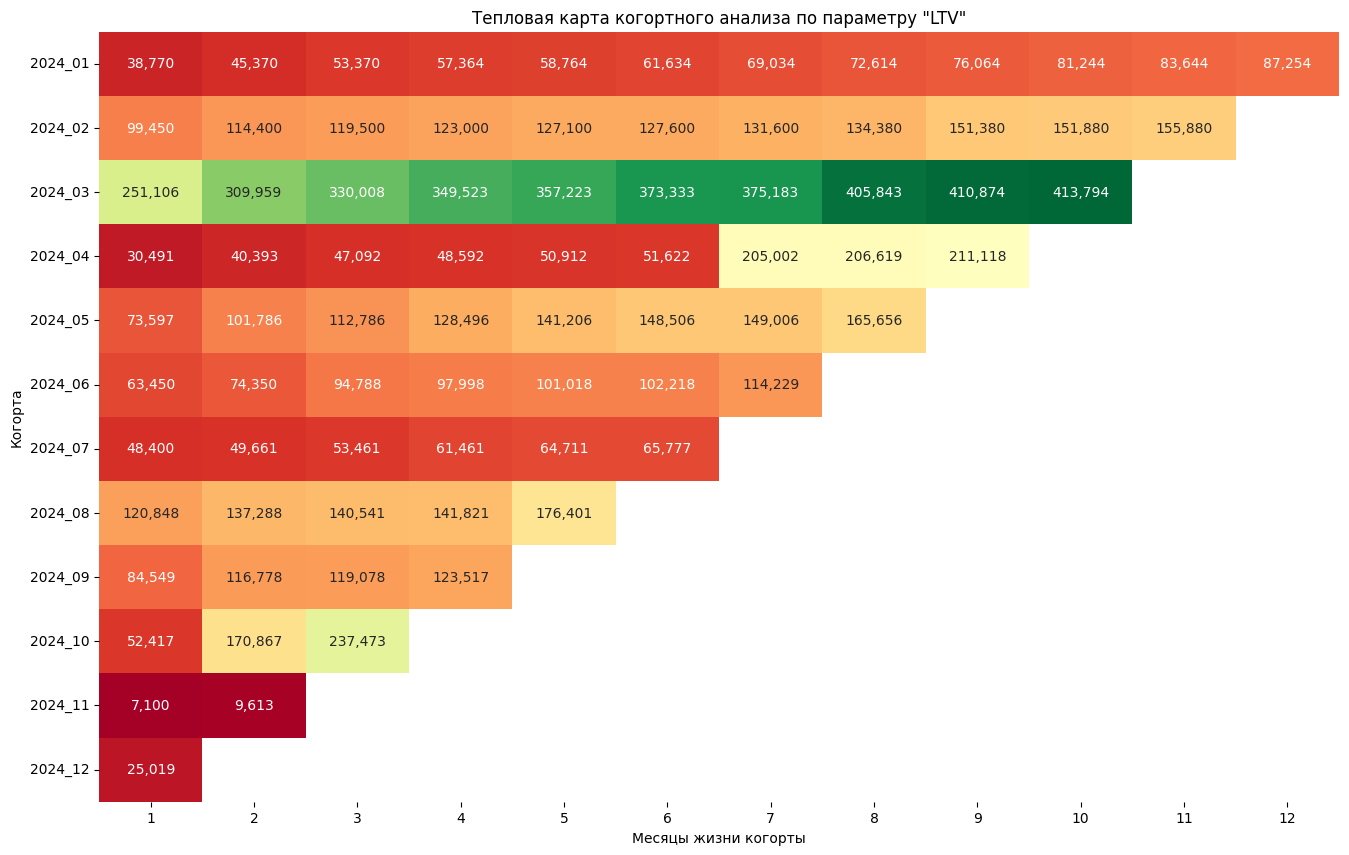

In [183]:
show_chogort_table_sns(simple_chogort_table, col='ltv', ml=12)

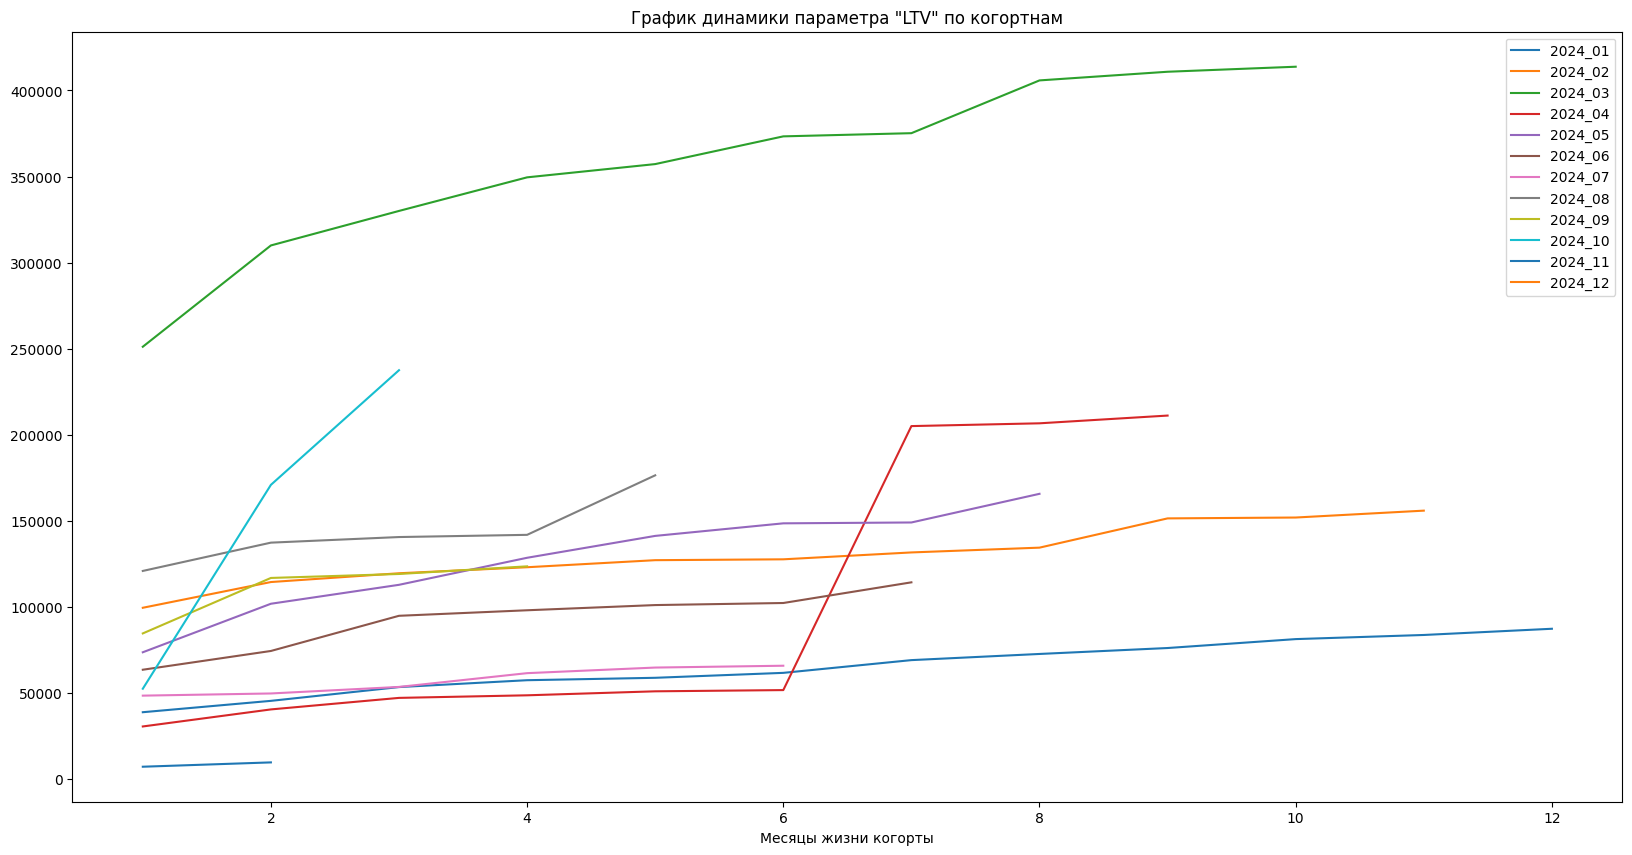

In [184]:
graf_chogort(simple_chogort_table, col='ltv', ml=12)

Общие тренды
- Высокий отток доноров. Большинство когорт теряют 50-80% доноров в течение года.
- Большинство доноров совершают разовые пожертвования, не возвращаясь.

Успешные когорты
- Когорта 2023_03: Суммарные пожертвования: 1.94 млн руб. за 22 месяца. Высокий RR на 13-м месяце (21.28%), вероятно, за счет крупных доноров.

Проблемные когорты
- Когорта 2023_06: Низкий RR: 5.71% на 24-м месяце. Проблема: Доноры быстро перестают жертвовать.
- Когорта 2024_05: Всего 37 доноров, RR падает до 8.11% на 8-м месяце. Проблема: Малая вовлеченность или неэффективные каналы привлечения.

Аномалии
- Резкие скачки пожертвований: Например, когорта 2024_04: на 7-м месяце пожертвования выросли до 153.4 тыс. руб. (возможно, крупный разовый донат).
- Сезонность: Снижение RR летом (например, июнь 2023 для 2023_02) — возможно, из-за отпусков.


**Промежуточный итог**

Пользователи в разных категориях ведут себя по-разному. Корпоративные донаторы жертвую редко но помногу - треть в общей сумме сборов. Разовые донаторы приносят

In [185]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-16 20:37:53.758906+04:00
 От начала рассчета прошло 0:00:58.997847


# Выводы

Полные выводы напишу позже =)

Пока видна большая поляризация пользователей на разовых и подписчиков. Разовых 2/3, а подписчиков менее 10%, при этом они приносят сопоставимые деньги...


Есть 3-4 акции, которые хорошо сыграли в последние 2 года. Видимо, стоит повторить их опыт.